In [1]:
import csv
import sys
import glob, os
import copy
import gc
from tqdm import tqdm
import time
import math
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon, Point
import shapely.wkt
import shapely.affinity
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
import rasterio.mask
import gdal
import ogr
import numpy as np
import random
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
import psutil
sys.setrecursionlimit(10**6)
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from torchsummary import summary
#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import albumentations as album

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [6]:
import os
print(len(os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL")))
os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL")

4582


['MUL_AOI_4_Shanghai_img1001.tif',
 'MUL_AOI_4_Shanghai_img1002.tif',
 'MUL_AOI_4_Shanghai_img1003.tif',
 'MUL_AOI_4_Shanghai_img1005.tif',
 'MUL_AOI_4_Shanghai_img1007.tif',
 'MUL_AOI_4_Shanghai_img1008.tif',
 'MUL_AOI_4_Shanghai_img1009.tif',
 'MUL_AOI_4_Shanghai_img1010.tif',
 'MUL_AOI_4_Shanghai_img1012.tif',
 'MUL_AOI_4_Shanghai_img1013.tif',
 'MUL_AOI_4_Shanghai_img1014.tif',
 'MUL_AOI_4_Shanghai_img1015.tif',
 'MUL_AOI_4_Shanghai_img1016.tif',
 'MUL_AOI_4_Shanghai_img1017.tif',
 'MUL_AOI_4_Shanghai_img1018.tif',
 'MUL_AOI_4_Shanghai_img1020.tif',
 'MUL_AOI_4_Shanghai_img1022.tif',
 'MUL_AOI_4_Shanghai_img1023.tif',
 'MUL_AOI_4_Shanghai_img1024.tif',
 'MUL_AOI_4_Shanghai_img513.tif',
 'MUL_AOI_4_Shanghai_img5132.tif',
 'MUL_AOI_4_Shanghai_img5133.tif',
 'MUL_AOI_4_Shanghai_img5138.tif',
 'MUL_AOI_4_Shanghai_img5139.tif',
 'MUL_AOI_4_Shanghai_img514.tif',
 'MUL_AOI_4_Shanghai_img5140.tif',
 'MUL_AOI_4_Shanghai_img5141.tif',
 'MUL_AOI_4_Shanghai_img5142.tif',
 'MUL_AOI_4_Shanghai_i

(224, 224, 8)
(224, 224, 3)


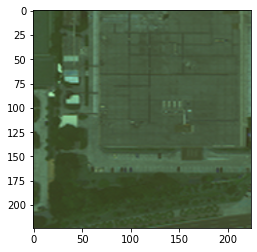

In [18]:
img = rio.open("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL/MUL_AOI_4_Shanghai_img1010.tif")
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
print(data.shape)
data = np.stack([data[:,:,1], data[:,:,2], data[:,:,4]], axis=2)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [36]:
import os
print(len(os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL-PanSharpen")))
os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL-PanSharpen")

4582


['MUL-PanSharpen_AOI_4_Shanghai_img1001.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1002.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1003.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1005.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1007.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1008.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1009.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1010.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1012.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1013.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img1014.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3866.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3868.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3869.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3871.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3872.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3873.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3874.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3875.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3880.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_img3882.tif',
 'MUL-PanSharpen_AOI_4_Shanghai_im

(224, 224, 8)
(224, 224, 3)


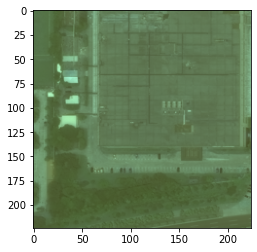

In [35]:
img = rio.open("../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_4_Shanghai_img1010.tif")
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
print(data.shape)
data = np.stack([data[:,:,1], data[:,:,2], data[:,:,4]], axis=2)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [7]:
import os
print(len(os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/PAN")))
os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/PAN")

4582


['PAN_AOI_4_Shanghai_img1001.tif',
 'PAN_AOI_4_Shanghai_img1002.tif',
 'PAN_AOI_4_Shanghai_img1003.tif',
 'PAN_AOI_4_Shanghai_img1005.tif',
 'PAN_AOI_4_Shanghai_img1007.tif',
 'PAN_AOI_4_Shanghai_img1008.tif',
 'PAN_AOI_4_Shanghai_img1009.tif',
 'PAN_AOI_4_Shanghai_img1010.tif',
 'PAN_AOI_4_Shanghai_img1012.tif',
 'PAN_AOI_4_Shanghai_img1013.tif',
 'PAN_AOI_4_Shanghai_img1014.tif',
 'PAN_AOI_4_Shanghai_img1015.tif',
 'PAN_AOI_4_Shanghai_img1016.tif',
 'PAN_AOI_4_Shanghai_img1017.tif',
 'PAN_AOI_4_Shanghai_img1018.tif',
 'PAN_AOI_4_Shanghai_img1020.tif',
 'PAN_AOI_4_Shanghai_img1022.tif',
 'PAN_AOI_4_Shanghai_img1023.tif',
 'PAN_AOI_4_Shanghai_img1024.tif',
 'PAN_AOI_4_Shanghai_img5424.tif',
 'PAN_AOI_4_Shanghai_img5428.tif',
 'PAN_AOI_4_Shanghai_img5429.tif',
 'PAN_AOI_4_Shanghai_img543.tif',
 'PAN_AOI_4_Shanghai_img5430.tif',
 'PAN_AOI_4_Shanghai_img5431.tif',
 'PAN_AOI_4_Shanghai_img5433.tif',
 'PAN_AOI_4_Shanghai_img5437.tif',
 'PAN_AOI_4_Shanghai_img5438.tif',
 'PAN_AOI_4_Shanghai_

(224, 224, 1)
(224, 224)


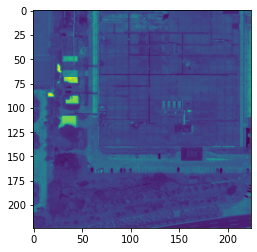

In [26]:
img = rio.open("../building_detection_data_shanghai/AOI_4_Shanghai_Train/PAN/PAN_AOI_4_Shanghai_img1010.tif")
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
print(data.shape)
if data.max()!= 0:
    data = data / data.max()
img = np.array(data)
_img = np.squeeze(img)
print(_img.shape)
plt.imshow(_img)

In [37]:
import os
print(len(os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen")))
os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen")

4582


['RGB-PanSharpen_AOI_4_Shanghai_img1001.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1002.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1003.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1005.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1007.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1008.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1009.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1010.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1012.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1013.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1014.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1015.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1016.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1017.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1018.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1020.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1022.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1023.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1024.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img1025.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_img4272.tif',
 'RGB-PanSharpen_AOI_4_Shanghai_im

(224, 224, 3)


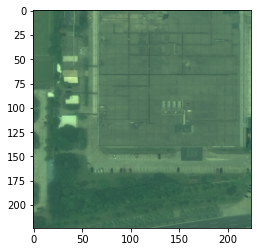

In [38]:
img = rio.open("../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1010.tif")
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
print(data.shape)
if data.max()!= 0:
    data = data / data.max()
img = np.array(data)
plt.imshow(img)

In [30]:
import os
print(len(os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings")))
os.listdir("../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings")

4582


['buildings_AOI_4_Shanghai_img1001.geojson',
 'buildings_AOI_4_Shanghai_img1002.geojson',
 'buildings_AOI_4_Shanghai_img1003.geojson',
 'buildings_AOI_4_Shanghai_img1005.geojson',
 'buildings_AOI_4_Shanghai_img1007.geojson',
 'buildings_AOI_4_Shanghai_img1008.geojson',
 'buildings_AOI_4_Shanghai_img1009.geojson',
 'buildings_AOI_4_Shanghai_img1010.geojson',
 'buildings_AOI_4_Shanghai_img1012.geojson',
 'buildings_AOI_4_Shanghai_img1013.geojson',
 'buildings_AOI_4_Shanghai_img1014.geojson',
 'buildings_AOI_4_Shanghai_img1015.geojson',
 'buildings_AOI_4_Shanghai_img1016.geojson',
 'buildings_AOI_4_Shanghai_img1017.geojson',
 'buildings_AOI_4_Shanghai_img1018.geojson',
 'buildings_AOI_4_Shanghai_img1020.geojson',
 'buildings_AOI_4_Shanghai_img1022.geojson',
 'buildings_AOI_4_Shanghai_img1023.geojson',
 'buildings_AOI_4_Shanghai_img5319.geojson',
 'buildings_AOI_4_Shanghai_img532.geojson',
 'buildings_AOI_4_Shanghai_img5323.geojson',
 'buildings_AOI_4_Shanghai_img5324.geojson',
 'buildings

In [ ]:
mask = rio.open('../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1010.geojson')
data = mask.read()
data = data.transpose(1,2,0)
print(data.shape)
mask = np.array(data)
plt.imshow(mask)

In [53]:
#  get data list
path_3band = '../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/'
path_8band = '../building_detection_data_shanghai/AOI_4_Shanghai_Train/MUL-PanSharpen/'
path_geojson = '../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/'
path_mask_img = '../building_detection_data_shanghai/AOI_4_Shanghai_Train/MaskImages/'

def get_list(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

list_3band = get_list(path_3band)
list_8band = get_list(path_8band)
list_geojson = get_list(path_geojson)

In [71]:
list_num = []

for i in range(len(list_geojson)):
    replaced = list_geojson[i].replace("buildings_AOI_4_Shanghai_img", "")
    replaced = replaced.replace(".geojson", "")
    list_num.append(int(replaced))
list_num

[1001,
 1002,
 1003,
 1005,
 1007,
 1008,
 1009,
 1010,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1020,
 1022,
 1023,
 5319,
 532,
 5323,
 5324,
 5325,
 5328,
 533,
 5330,
 5331,
 5333,
 5334,
 5335,
 5336,
 3394,
 3395,
 3397,
 34,
 3402,
 3403,
 3405,
 3406,
 3408,
 341,
 3412,
 3413,
 3414,
 3415,
 3416,
 3418,
 3419,
 3421,
 3423,
 1024,
 1056,
 1072,
 1098,
 1131,
 1148,
 1171,
 121,
 1241,
 1267,
 1301,
 6509,
 651,
 6512,
 6513,
 6515,
 6518,
 6519,
 652,
 6520,
 6522,
 6523,
 6528,
 6529,
 653,
 6532,
 6534,
 6535,
 2116,
 2117,
 2118,
 2119,
 2123,
 2124,
 2125,
 2126,
 2127,
 2128,
 2130,
 2132,
 2134,
 2135,
 2136,
 2138,
 2139,
 214,
 2140,
 2143,
 2144,
 2145,
 4469,
 447,
 4470,
 4471,
 4472,
 4473,
 4474,
 4476,
 4477,
 4479,
 448,
 4480,
 4482,
 4483,
 4486,
 4487,
 4488,
 4490,
 7248,
 7249,
 7250,
 7253,
 7254,
 7255,
 7257,
 7258,
 7260,
 7261,
 7262,
 7263,
 7264,
 7266,
 7267,
 7268,
 6156,
 6160,
 6161,
 6162,
 6163,
 6164,
 6166,
 6167,
 617,
 6172,
 6173

In [52]:
source_ds = ogr.Open('../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1010.geojson')
source_ds.GetLayer()

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7f8ebcba7bd0> >

In [57]:
gjp = os.path.join(path_geojson, 'buildings_AOI_4_Shanghai_img1010.geojson')
source_ds = ogr.Open(gjp)
source_ds.GetLayer()

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7f8d4ba4ef00> >

In [72]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(list_num):

        src_raster_filename = "RGB-PanSharpen_AOI_4_Shanghai_img{}.tif".format(idx)
        src_vector_filename = "buildings_AOI_4_Shanghai_img{}.geojson".format(idx)
        dst_filename = "AOI_4_Shanghai_img{}.tif".format(idx)

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)
        
#         print(src_raster_filename, src_vector_filename)
#         print(src_raster_path, src_vector_path)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [73]:
build_labels(path_3band, path_geojson, path_mask_img)

  0%|          | 6/4582 [00:00<01:41, 45.13it/s]

[INFO] Found 4582 geojson files. Preparing building mask images...
RGB-PanSharpen_AOI_4_Shanghai_img1001.tif buildings_AOI_4_Shanghai_img1001.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1001.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1001.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1002.tif buildings_AOI_4_Shanghai_img1002.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1002.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1002.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1003.tif buildings_AOI_4_Shanghai_img1003.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1003.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1003.ge

  0%|          | 11/4582 [00:00<02:12, 34.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1013.tif buildings_AOI_4_Shanghai_img1013.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1013.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1013.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1014.tif buildings_AOI_4_Shanghai_img1014.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1014.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1014.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1015.tif buildings_AOI_4_Shanghai_img1015.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1015.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1015.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1016.tif buildings_AOI_4_Sha

  0%|          | 19/4582 [00:00<02:42, 28.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1020.tif buildings_AOI_4_Shanghai_img1020.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1020.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1020.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1022.tif buildings_AOI_4_Shanghai_img1022.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1022.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1022.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1023.tif buildings_AOI_4_Shanghai_img1023.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1023.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1023.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5319.tif buildings_AOI_4_Sha

  0%|          | 22/4582 [00:00<02:49, 26.96it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5323.tif buildings_AOI_4_Shanghai_img5323.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5323.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5323.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5324.tif buildings_AOI_4_Shanghai_img5324.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5324.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5324.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5325.tif buildings_AOI_4_Shanghai_img5325.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5325.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5325.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5328.tif buildings_AOI_4_Sha

  1%|          | 32/4582 [00:00<02:07, 35.68it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5331.tif buildings_AOI_4_Shanghai_img5331.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5331.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5331.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5333.tif buildings_AOI_4_Shanghai_img5333.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5333.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5333.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5334.tif buildings_AOI_4_Shanghai_img5334.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5334.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5334.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5335.tif buildings_AOI_4_Sha

  1%|          | 43/4582 [00:01<01:43, 43.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3406.tif buildings_AOI_4_Shanghai_img3406.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3406.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3406.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3408.tif buildings_AOI_4_Shanghai_img3408.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3408.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3408.geojson
RGB-PanSharpen_AOI_4_Shanghai_img341.tif buildings_AOI_4_Shanghai_img341.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img341.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img341.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3412.tif buildings_AOI_4_Shangha

  1%|          | 53/4582 [00:01<01:54, 39.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3419.tif buildings_AOI_4_Shanghai_img3419.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3419.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3419.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3421.tif buildings_AOI_4_Shanghai_img3421.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3421.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3421.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3423.tif buildings_AOI_4_Shanghai_img3423.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3423.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3423.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1024.tif buildings_AOI_4_Sha

  1%|▏         | 58/4582 [00:01<02:02, 37.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1148.tif buildings_AOI_4_Shanghai_img1148.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1148.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1148.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1171.tif buildings_AOI_4_Shanghai_img1171.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1171.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1171.geojson
RGB-PanSharpen_AOI_4_Shanghai_img121.tif buildings_AOI_4_Shanghai_img121.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img121.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img121.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1241.tif buildings_AOI_4_Shangha

  1%|▏         | 66/4582 [00:01<02:07, 35.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img651.tif buildings_AOI_4_Shanghai_img651.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img651.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img651.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6512.tif buildings_AOI_4_Shanghai_img6512.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6512.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6512.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6513.tif buildings_AOI_4_Shanghai_img6513.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6513.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6513.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6515.tif buildings_AOI_4_Shangha

  2%|▏         | 75/4582 [00:02<02:09, 34.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6520.tif buildings_AOI_4_Shanghai_img6520.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6520.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6520.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6522.tif buildings_AOI_4_Shanghai_img6522.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6522.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6522.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6523.tif buildings_AOI_4_Shanghai_img6523.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6523.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6523.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6528.tif buildings_AOI_4_Sha

  2%|▏         | 86/4582 [00:02<01:46, 42.15it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6535.tif buildings_AOI_4_Shanghai_img6535.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6535.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6535.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2116.tif buildings_AOI_4_Shanghai_img2116.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2116.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2116.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2117.tif buildings_AOI_4_Shanghai_img2117.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2117.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2117.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2118.tif buildings_AOI_4_Sha

  2%|▏         | 91/4582 [00:02<01:56, 38.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2128.tif buildings_AOI_4_Shanghai_img2128.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2128.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2128.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2130.tif buildings_AOI_4_Shanghai_img2130.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2130.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2130.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2132.tif buildings_AOI_4_Shanghai_img2132.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2132.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2132.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2134.tif buildings_AOI_4_Sha

  2%|▏         | 100/4582 [00:02<01:58, 37.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2139.tif buildings_AOI_4_Shanghai_img2139.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2139.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2139.geojson
RGB-PanSharpen_AOI_4_Shanghai_img214.tif buildings_AOI_4_Shanghai_img214.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img214.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img214.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2140.tif buildings_AOI_4_Shanghai_img2140.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2140.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2140.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2143.tif buildings_AOI_4_Shangha

  2%|▏         | 112/4582 [00:02<01:35, 46.98it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4470.tif buildings_AOI_4_Shanghai_img4470.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4470.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4470.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4471.tif buildings_AOI_4_Shanghai_img4471.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4471.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4471.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4472.tif buildings_AOI_4_Shanghai_img4472.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4472.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4472.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4473.tif buildings_AOI_4_Sha

  3%|▎         | 122/4582 [00:03<01:44, 42.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4487.tif buildings_AOI_4_Shanghai_img4487.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4487.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4487.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4488.tif buildings_AOI_4_Shanghai_img4488.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4488.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4488.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4490.tif buildings_AOI_4_Shanghai_img4490.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4490.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4490.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7248.tif buildings_AOI_4_Sha

  3%|▎         | 133/4582 [00:03<01:35, 46.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7255.tif buildings_AOI_4_Shanghai_img7255.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7255.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7255.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7257.tif buildings_AOI_4_Shanghai_img7257.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7257.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7257.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7258.tif buildings_AOI_4_Shanghai_img7258.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7258.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7258.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7260.tif buildings_AOI_4_Sha

  3%|▎         | 143/4582 [00:03<01:35, 46.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6156.tif buildings_AOI_4_Shanghai_img6156.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6156.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6156.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6160.tif buildings_AOI_4_Shanghai_img6160.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6160.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6160.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6161.tif buildings_AOI_4_Shanghai_img6161.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6161.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6161.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6162.tif buildings_AOI_4_Sha

  3%|▎         | 148/4582 [00:03<01:38, 44.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6172.tif buildings_AOI_4_Shanghai_img6172.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6172.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6172.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6173.tif buildings_AOI_4_Shanghai_img6173.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6173.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6173.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6174.tif buildings_AOI_4_Shanghai_img6174.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6174.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6174.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6176.tif buildings_AOI_4_Sha

  3%|▎         | 158/4582 [00:04<01:51, 39.70it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6182.tif buildings_AOI_4_Shanghai_img6182.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6182.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6182.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6184.tif buildings_AOI_4_Shanghai_img6184.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6184.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6184.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6186.tif buildings_AOI_4_Shanghai_img6186.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6186.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6186.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6187.tif buildings_AOI_4_Sha

  4%|▎         | 163/4582 [00:04<01:48, 40.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2868.tif buildings_AOI_4_Shanghai_img2868.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2868.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2868.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2870.tif buildings_AOI_4_Shanghai_img2870.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2870.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2870.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2871.tif buildings_AOI_4_Shanghai_img2871.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2871.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2871.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2872.tif buildings_AOI_4_Sha

  4%|▍         | 177/4582 [00:04<01:23, 52.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2884.tif buildings_AOI_4_Shanghai_img2884.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2884.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2884.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2887.tif buildings_AOI_4_Shanghai_img2887.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2887.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2887.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2891.tif buildings_AOI_4_Shanghai_img2891.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2891.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2891.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2892.tif buildings_AOI_4_Sha

  4%|▍         | 189/4582 [00:04<01:27, 50.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4881.tif buildings_AOI_4_Shanghai_img4881.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4881.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4881.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4882.tif buildings_AOI_4_Shanghai_img4882.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4882.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4882.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4883.tif buildings_AOI_4_Shanghai_img4883.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4883.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4883.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4885.tif buildings_AOI_4_Sha

  4%|▍         | 201/4582 [00:04<01:32, 47.37it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4894.tif buildings_AOI_4_Shanghai_img4894.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4894.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4894.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4895.tif buildings_AOI_4_Shanghai_img4895.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4895.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4895.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4896.tif buildings_AOI_4_Shanghai_img4896.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4896.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4896.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4897.tif buildings_AOI_4_Sha

  5%|▍         | 211/4582 [00:05<01:34, 46.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img152.tif buildings_AOI_4_Shanghai_img152.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img152.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img152.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1520.tif buildings_AOI_4_Shanghai_img1520.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1520.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1520.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1522.tif buildings_AOI_4_Shanghai_img1522.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1522.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1522.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1524.tif buildings_AOI_4_Shangha

  5%|▍         | 217/4582 [00:05<01:30, 48.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3858.tif buildings_AOI_4_Shanghai_img3858.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3858.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3858.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3859.tif buildings_AOI_4_Shanghai_img3859.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3859.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3859.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3861.tif buildings_AOI_4_Shanghai_img3861.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3861.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3861.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3863.tif buildings_AOI_4_Sha

  5%|▍         | 228/4582 [00:05<01:33, 46.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3873.tif buildings_AOI_4_Shanghai_img3873.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3873.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3873.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6927.tif buildings_AOI_4_Shanghai_img6927.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6927.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6927.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6928.tif buildings_AOI_4_Shanghai_img6928.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6928.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6928.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6929.tif buildings_AOI_4_Sha

  5%|▌         | 239/4582 [00:05<01:28, 48.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img694.tif buildings_AOI_4_Shanghai_img694.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img694.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img694.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6943.tif buildings_AOI_4_Shanghai_img6943.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6943.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6943.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6944.tif buildings_AOI_4_Shanghai_img6944.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6944.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6944.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5701.tif buildings_AOI_4_Shangha

  5%|▌         | 251/4582 [00:05<01:37, 44.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img572.tif buildings_AOI_4_Shanghai_img572.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img572.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img572.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5721.tif buildings_AOI_4_Shanghai_img5721.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5721.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5721.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5723.tif buildings_AOI_4_Shanghai_img5723.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5723.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5723.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7540.tif buildings_AOI_4_Shangha

  6%|▌         | 256/4582 [00:06<01:43, 41.71it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7548.tif buildings_AOI_4_Shanghai_img7548.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7548.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7548.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7549.tif buildings_AOI_4_Shanghai_img7549.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7549.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7549.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7551.tif buildings_AOI_4_Shanghai_img7551.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7551.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7551.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7552.tif buildings_AOI_4_Sha

  6%|▌         | 266/4582 [00:06<01:42, 42.02it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7557.tif buildings_AOI_4_Shanghai_img7557.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7557.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7557.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2490.tif buildings_AOI_4_Shanghai_img2490.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2490.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2490.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2491.tif buildings_AOI_4_Shanghai_img2491.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2491.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2491.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2494.tif buildings_AOI_4_Sha

  6%|▌         | 277/4582 [00:06<01:50, 38.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2501.tif buildings_AOI_4_Shanghai_img2501.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2501.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2501.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2502.tif buildings_AOI_4_Shanghai_img2502.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2502.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2502.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2507.tif buildings_AOI_4_Shanghai_img2507.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2507.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2507.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2509.tif buildings_AOI_4_Sha

  6%|▌         | 282/4582 [00:06<02:07, 33.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2515.tif buildings_AOI_4_Shanghai_img2515.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2515.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2515.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2516.tif buildings_AOI_4_Shanghai_img2516.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2516.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2516.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2518.tif buildings_AOI_4_Shanghai_img2518.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2518.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2518.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2519.tif buildings_AOI_4_Sha

  6%|▋         | 290/4582 [00:07<02:09, 33.23it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2522.tif buildings_AOI_4_Shanghai_img2522.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2522.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2522.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3170.tif buildings_AOI_4_Shanghai_img3170.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3170.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3170.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3173.tif buildings_AOI_4_Shanghai_img3173.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3173.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3173.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3174.tif buildings_AOI_4_Sha

  7%|▋         | 299/4582 [00:07<02:00, 35.64it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3184.tif buildings_AOI_4_Shanghai_img3184.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3184.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3184.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3185.tif buildings_AOI_4_Shanghai_img3185.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3185.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3185.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3186.tif buildings_AOI_4_Shanghai_img3186.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3186.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3186.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3187.tif buildings_AOI_4_Sha

  7%|▋         | 309/4582 [00:07<01:44, 40.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3196.tif buildings_AOI_4_Shanghai_img3196.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3196.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3196.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3197.tif buildings_AOI_4_Shanghai_img3197.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3197.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3197.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3198.tif buildings_AOI_4_Shanghai_img3198.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3198.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3198.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3199.tif buildings_AOI_4_Sha

  7%|▋         | 314/4582 [00:07<01:46, 40.12it/s]

RGB-PanSharpen_AOI_4_Shanghai_img187.tif buildings_AOI_4_Shanghai_img187.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img187.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img187.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1870.tif buildings_AOI_4_Shanghai_img1870.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1870.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1870.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1871.tif buildings_AOI_4_Shanghai_img1871.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1871.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1871.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1872.tif buildings_AOI_4_Shangha

  7%|▋         | 324/4582 [00:07<01:41, 42.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img188.tif buildings_AOI_4_Shanghai_img188.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img188.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img188.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1880.tif buildings_AOI_4_Shanghai_img1880.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1880.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1880.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1881.tif buildings_AOI_4_Shanghai_img1881.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1881.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1881.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1884.tif buildings_AOI_4_Shangha

  7%|▋         | 334/4582 [00:08<01:43, 41.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6336.tif buildings_AOI_4_Shanghai_img6336.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6336.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6336.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6339.tif buildings_AOI_4_Shanghai_img6339.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6339.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6339.geojson
RGB-PanSharpen_AOI_4_Shanghai_img634.tif buildings_AOI_4_Shanghai_img634.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img634.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img634.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6340.tif buildings_AOI_4_Shangha

  8%|▊         | 344/4582 [00:08<01:48, 39.18it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6347.tif buildings_AOI_4_Shanghai_img6347.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6347.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6347.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6349.tif buildings_AOI_4_Shanghai_img6349.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6349.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6349.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6350.tif buildings_AOI_4_Shanghai_img6350.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6350.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6350.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6352.tif buildings_AOI_4_Sha

  8%|▊         | 348/4582 [00:08<01:50, 38.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6362.tif buildings_AOI_4_Shanghai_img6362.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6362.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6362.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6363.tif buildings_AOI_4_Shanghai_img6363.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6363.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6363.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6364.tif buildings_AOI_4_Shanghai_img6364.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6364.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6364.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6365.tif buildings_AOI_4_Sha

  8%|▊         | 356/4582 [00:08<02:03, 34.25it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5115.tif buildings_AOI_4_Shanghai_img5115.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5115.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5115.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5116.tif buildings_AOI_4_Shanghai_img5116.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5116.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5116.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5118.tif buildings_AOI_4_Shanghai_img5118.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5118.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5118.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5119.tif buildings_AOI_4_Sha

  8%|▊         | 364/4582 [00:09<02:06, 33.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5127.tif buildings_AOI_4_Shanghai_img5127.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5127.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5127.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5128.tif buildings_AOI_4_Shanghai_img5128.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5128.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5128.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5129.tif buildings_AOI_4_Shanghai_img5129.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5129.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5129.geojson
RGB-PanSharpen_AOI_4_Shanghai_img513.tif buildings_AOI_4_Shan

  8%|▊         | 368/4582 [00:09<02:07, 33.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5139.tif buildings_AOI_4_Shanghai_img5139.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5139.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5139.geojson
RGB-PanSharpen_AOI_4_Shanghai_img514.tif buildings_AOI_4_Shanghai_img514.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img514.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img514.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4666.tif buildings_AOI_4_Shanghai_img4666.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4666.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4666.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4667.tif buildings_AOI_4_Shangha

  8%|▊         | 376/4582 [00:09<02:16, 30.84it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4675.tif buildings_AOI_4_Shanghai_img4675.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4675.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4675.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4677.tif buildings_AOI_4_Shanghai_img4677.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4677.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4677.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4679.tif buildings_AOI_4_Shanghai_img4679.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4679.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4679.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4681.tif buildings_AOI_4_Sha

  8%|▊         | 384/4582 [00:09<02:15, 31.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4688.tif buildings_AOI_4_Shanghai_img4688.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4688.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4688.geojson
RGB-PanSharpen_AOI_4_Shanghai_img469.tif buildings_AOI_4_Shanghai_img469.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img469.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img469.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4690.tif buildings_AOI_4_Shanghai_img4690.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4690.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4690.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4691.tif buildings_AOI_4_Shangha

  9%|▊         | 390/4582 [00:09<01:54, 36.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3610.tif buildings_AOI_4_Shanghai_img3610.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3610.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3610.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3617.tif buildings_AOI_4_Shanghai_img3617.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3617.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3617.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3618.tif buildings_AOI_4_Shanghai_img3618.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3618.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3618.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3619.tif buildings_AOI_4_Sha

  9%|▊         | 399/4582 [00:10<01:50, 37.73it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3628.tif buildings_AOI_4_Shanghai_img3628.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3628.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3628.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3633.tif buildings_AOI_4_Shanghai_img3633.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3633.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3633.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3634.tif buildings_AOI_4_Shanghai_img3634.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3634.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3634.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3635.tif buildings_AOI_4_Sha

  9%|▉         | 407/4582 [00:10<01:51, 37.45it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3641.tif buildings_AOI_4_Shanghai_img3641.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3641.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3641.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1243.tif buildings_AOI_4_Shanghai_img1243.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1243.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1243.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1246.tif buildings_AOI_4_Shanghai_img1246.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1246.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1246.geojson
RGB-PanSharpen_AOI_4_Shanghai_img125.tif buildings_AOI_4_Shan

  9%|▉         | 416/4582 [00:10<01:43, 40.29it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1255.tif buildings_AOI_4_Shanghai_img1255.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1255.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1255.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1257.tif buildings_AOI_4_Shanghai_img1257.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1257.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1257.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1259.tif buildings_AOI_4_Shanghai_img1259.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1259.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1259.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1262.tif buildings_AOI_4_Sha

  9%|▉         | 426/4582 [00:10<01:48, 38.41it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4196.tif buildings_AOI_4_Shanghai_img4196.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4196.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4196.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4198.tif buildings_AOI_4_Shanghai_img4198.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4198.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4198.geojson
RGB-PanSharpen_AOI_4_Shanghai_img42.tif buildings_AOI_4_Shanghai_img42.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img42.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img42.geojson
RGB-PanSharpen_AOI_4_Shanghai_img420.tif buildings_AOI_4_Shanghai_img

  9%|▉         | 434/4582 [00:10<01:53, 36.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4204.tif buildings_AOI_4_Shanghai_img4204.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4204.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4204.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4206.tif buildings_AOI_4_Shanghai_img4206.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4206.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4206.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4209.tif buildings_AOI_4_Shanghai_img4209.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4209.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4209.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4211.tif buildings_AOI_4_Sha

 10%|▉         | 443/4582 [00:11<01:49, 37.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4802.tif buildings_AOI_4_Shanghai_img4802.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4802.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4802.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4823.tif buildings_AOI_4_Shanghai_img4823.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4823.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4823.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4840.tif buildings_AOI_4_Shanghai_img4840.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4840.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4840.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4858.tif buildings_AOI_4_Sha

 10%|▉         | 448/4582 [00:11<01:49, 37.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4976.tif buildings_AOI_4_Shanghai_img4976.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4976.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4976.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6750.tif buildings_AOI_4_Shanghai_img6750.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6750.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6750.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6753.tif buildings_AOI_4_Shanghai_img6753.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6753.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6753.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6755.tif buildings_AOI_4_Sha

 10%|▉         | 456/4582 [00:11<01:53, 36.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6764.tif buildings_AOI_4_Shanghai_img6764.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6764.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6764.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6765.tif buildings_AOI_4_Shanghai_img6765.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6765.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6765.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6766.tif buildings_AOI_4_Shanghai_img6766.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6766.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6766.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6771.tif buildings_AOI_4_Sha

 10%|█         | 465/4582 [00:11<01:45, 39.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img678.tif buildings_AOI_4_Shanghai_img678.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img678.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img678.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6781.tif buildings_AOI_4_Shanghai_img6781.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6781.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6781.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6784.tif buildings_AOI_4_Shanghai_img6784.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6784.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6784.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6785.tif buildings_AOI_4_Shangha

 10%|█         | 473/4582 [00:12<02:00, 34.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7110.tif buildings_AOI_4_Shanghai_img7110.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7110.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7110.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7111.tif buildings_AOI_4_Shanghai_img7111.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7111.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7111.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7112.tif buildings_AOI_4_Shanghai_img7112.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7112.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7112.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7113.tif buildings_AOI_4_Sha

 10%|█         | 477/4582 [00:12<02:13, 30.86it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7118.tif buildings_AOI_4_Shanghai_img7118.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7118.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7118.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7119.tif buildings_AOI_4_Shanghai_img7119.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7119.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7119.geojson
RGB-PanSharpen_AOI_4_Shanghai_img712.tif buildings_AOI_4_Shanghai_img712.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img712.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img712.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7121.tif buildings_AOI_4_Shangha

 11%|█         | 485/4582 [00:12<02:20, 29.18it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7124.tif buildings_AOI_4_Shanghai_img7124.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7124.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7124.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5469.tif buildings_AOI_4_Shanghai_img5469.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5469.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5469.geojson
RGB-PanSharpen_AOI_4_Shanghai_img547.tif buildings_AOI_4_Shanghai_img547.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img547.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img547.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5471.tif buildings_AOI_4_Shangha

 11%|█         | 492/4582 [00:12<02:14, 30.45it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5477.tif buildings_AOI_4_Shanghai_img5477.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5477.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5477.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5479.tif buildings_AOI_4_Shanghai_img5479.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5479.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5479.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5480.tif buildings_AOI_4_Shanghai_img5480.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5480.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5480.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5481.tif buildings_AOI_4_Sha

 11%|█         | 500/4582 [00:12<02:09, 31.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5489.tif buildings_AOI_4_Shanghai_img5489.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5489.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5489.geojson
RGB-PanSharpen_AOI_4_Shanghai_img549.tif buildings_AOI_4_Shanghai_img549.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img549.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img549.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5490.tif buildings_AOI_4_Shanghai_img5490.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5490.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5490.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5491.tif buildings_AOI_4_Shangha

 11%|█         | 504/4582 [00:13<02:02, 33.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5498.tif buildings_AOI_4_Shanghai_img5498.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5498.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5498.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5499.tif buildings_AOI_4_Shanghai_img5499.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5499.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5499.geojson
RGB-PanSharpen_AOI_4_Shanghai_img550.tif buildings_AOI_4_Shanghai_img550.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img550.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img550.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5501.tif buildings_AOI_4_Shangha

 11%|█         | 512/4582 [00:13<02:04, 32.64it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7424.tif buildings_AOI_4_Shanghai_img7424.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7424.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7424.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7427.tif buildings_AOI_4_Shanghai_img7427.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7427.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7427.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7428.tif buildings_AOI_4_Shanghai_img7428.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7428.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7428.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7429.tif buildings_AOI_4_Sha

 11%|█▏        | 526/4582 [00:13<01:24, 48.16it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7440.tif buildings_AOI_4_Shanghai_img7440.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7440.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7440.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7442.tif buildings_AOI_4_Shanghai_img7442.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7442.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7442.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7443.tif buildings_AOI_4_Shanghai_img7443.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7443.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7443.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7445.tif buildings_AOI_4_Sha

 12%|█▏        | 531/4582 [00:13<01:35, 42.28it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2719.tif buildings_AOI_4_Shanghai_img2719.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2719.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2719.geojson
RGB-PanSharpen_AOI_4_Shanghai_img272.tif buildings_AOI_4_Shanghai_img272.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img272.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img272.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2721.tif buildings_AOI_4_Shanghai_img2721.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2721.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2721.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2722.tif buildings_AOI_4_Shangha

 12%|█▏        | 540/4582 [00:14<01:58, 34.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2729.tif buildings_AOI_4_Shanghai_img2729.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2729.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2729.geojson
RGB-PanSharpen_AOI_4_Shanghai_img273.tif buildings_AOI_4_Shanghai_img273.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img273.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img273.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2311.tif buildings_AOI_4_Shanghai_img2311.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2311.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2311.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2312.tif buildings_AOI_4_Shangha

 12%|█▏        | 544/4582 [00:14<02:02, 33.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img232.tif buildings_AOI_4_Shanghai_img232.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img232.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img232.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2320.tif buildings_AOI_4_Shanghai_img2320.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2320.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2320.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2321.tif buildings_AOI_4_Shanghai_img2321.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2321.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2321.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2322.tif buildings_AOI_4_Shangha

 12%|█▏        | 552/4582 [00:14<01:59, 33.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2328.tif buildings_AOI_4_Shanghai_img2328.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2328.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2328.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2333.tif buildings_AOI_4_Shanghai_img2333.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2333.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2333.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2334.tif buildings_AOI_4_Shanghai_img2334.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2334.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2334.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2336.tif buildings_AOI_4_Sha

 12%|█▏        | 560/4582 [00:14<02:07, 31.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6005.tif buildings_AOI_4_Shanghai_img6005.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6005.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6005.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6006.tif buildings_AOI_4_Shanghai_img6006.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6006.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6006.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6007.tif buildings_AOI_4_Shanghai_img6007.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6007.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6007.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6009.tif buildings_AOI_4_Sha

 12%|█▏        | 564/4582 [00:14<02:09, 30.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6014.tif buildings_AOI_4_Shanghai_img6014.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6014.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6014.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6015.tif buildings_AOI_4_Shanghai_img6015.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6015.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6015.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6017.tif buildings_AOI_4_Shanghai_img6017.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6017.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6017.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6019.tif buildings_AOI_4_Sha

 13%|█▎        | 574/4582 [00:15<01:53, 35.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1729.tif buildings_AOI_4_Shanghai_img1729.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1729.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1729.geojson
RGB-PanSharpen_AOI_4_Shanghai_img173.tif buildings_AOI_4_Shanghai_img173.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img173.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img173.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1730.tif buildings_AOI_4_Shanghai_img1730.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1730.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1730.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1732.tif buildings_AOI_4_Shangha

 13%|█▎        | 585/4582 [00:15<01:44, 38.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1744.tif buildings_AOI_4_Shanghai_img1744.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1744.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1744.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1745.tif buildings_AOI_4_Shanghai_img1745.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1745.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1745.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1746.tif buildings_AOI_4_Shanghai_img1746.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1746.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1746.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1749.tif buildings_AOI_4_Sha

 13%|█▎        | 593/4582 [00:15<01:54, 34.69it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1753.tif buildings_AOI_4_Shanghai_img1753.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1753.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1753.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3056.tif buildings_AOI_4_Shanghai_img3056.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3056.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3056.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3058.tif buildings_AOI_4_Shanghai_img3058.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3058.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3058.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3059.tif buildings_AOI_4_Sha

 13%|█▎        | 597/4582 [00:15<02:07, 31.28it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3066.tif buildings_AOI_4_Shanghai_img3066.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3066.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3066.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3067.tif buildings_AOI_4_Shanghai_img3067.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3067.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3067.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3068.tif buildings_AOI_4_Shanghai_img3068.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3068.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3068.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3069.tif buildings_AOI_4_Sha

 13%|█▎        | 604/4582 [00:16<02:21, 28.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3075.tif buildings_AOI_4_Shanghai_img3075.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3075.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3075.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3077.tif buildings_AOI_4_Shanghai_img3077.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3077.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3077.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3078.tif buildings_AOI_4_Shanghai_img3078.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3078.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3078.geojson
RGB-PanSharpen_AOI_4_Shanghai_img308.tif buildings_AOI_4_Shan

 13%|█▎        | 612/4582 [00:16<01:57, 33.87it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3083.tif buildings_AOI_4_Shanghai_img3083.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3083.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3083.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3085.tif buildings_AOI_4_Shanghai_img3085.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3085.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3085.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3086.tif buildings_AOI_4_Shanghai_img3086.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3086.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3086.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3087.tif buildings_AOI_4_Sha

 14%|█▎        | 621/4582 [00:16<01:53, 34.89it/s]

RGB-PanSharpen_AOI_4_Shanghai_img810.tif buildings_AOI_4_Shanghai_img810.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img810.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img810.geojson
RGB-PanSharpen_AOI_4_Shanghai_img811.tif buildings_AOI_4_Shanghai_img811.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img811.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img811.geojson
RGB-PanSharpen_AOI_4_Shanghai_img814.tif buildings_AOI_4_Shanghai_img814.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img814.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img814.geojson
RGB-PanSharpen_AOI_4_Shanghai_img815.tif buildings_AOI_4_Shanghai_img815.

 14%|█▎        | 629/4582 [00:16<01:52, 35.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img820.tif buildings_AOI_4_Shanghai_img820.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img820.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img820.geojson
RGB-PanSharpen_AOI_4_Shanghai_img821.tif buildings_AOI_4_Shanghai_img821.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img821.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img821.geojson
RGB-PanSharpen_AOI_4_Shanghai_img822.tif buildings_AOI_4_Shanghai_img822.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img822.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img822.geojson
RGB-PanSharpen_AOI_4_Shanghai_img823.tif buildings_AOI_4_Shanghai_img823.

 14%|█▍        | 637/4582 [00:16<01:47, 36.81it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3318.tif buildings_AOI_4_Shanghai_img3318.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3318.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3318.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3319.tif buildings_AOI_4_Shanghai_img3319.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3319.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3319.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3322.tif buildings_AOI_4_Shanghai_img3322.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3322.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3322.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3323.tif buildings_AOI_4_Sha

 14%|█▍        | 641/4582 [00:17<01:54, 34.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img333.tif buildings_AOI_4_Shanghai_img333.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img333.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img333.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3330.tif buildings_AOI_4_Shanghai_img3330.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3330.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3330.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3331.tif buildings_AOI_4_Shanghai_img3331.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3331.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3331.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3333.tif buildings_AOI_4_Shangha

 14%|█▍        | 649/4582 [00:17<02:04, 31.71it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4049.tif buildings_AOI_4_Shanghai_img4049.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4049.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4049.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4051.tif buildings_AOI_4_Shanghai_img4051.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4051.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4051.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4052.tif buildings_AOI_4_Shanghai_img4052.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4052.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4052.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4058.tif buildings_AOI_4_Sha

 14%|█▍        | 657/4582 [00:17<02:01, 32.37it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4064.tif buildings_AOI_4_Shanghai_img4064.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4064.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4064.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4066.tif buildings_AOI_4_Shanghai_img4066.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4066.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4066.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4068.tif buildings_AOI_4_Shanghai_img4068.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4068.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4068.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6627.tif buildings_AOI_4_Sha

 14%|█▍        | 661/4582 [00:17<02:04, 31.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6632.tif buildings_AOI_4_Shanghai_img6632.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6632.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6632.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6633.tif buildings_AOI_4_Shanghai_img6633.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6633.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6633.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6635.tif buildings_AOI_4_Shanghai_img6635.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6635.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6635.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6636.tif buildings_AOI_4_Sha

 15%|█▍        | 669/4582 [00:17<02:01, 32.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6642.tif buildings_AOI_4_Shanghai_img6642.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6642.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6642.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6643.tif buildings_AOI_4_Shanghai_img6643.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6643.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6643.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6647.tif buildings_AOI_4_Shanghai_img6647.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6647.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6647.geojson
RGB-PanSharpen_AOI_4_Shanghai_img665.tif buildings_AOI_4_Shan

 15%|█▍        | 682/4582 [00:18<01:27, 44.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4549.tif buildings_AOI_4_Shanghai_img4549.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4549.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4549.geojson
RGB-PanSharpen_AOI_4_Shanghai_img455.tif buildings_AOI_4_Shanghai_img455.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img455.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img455.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4551.tif buildings_AOI_4_Shanghai_img4551.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4551.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4551.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4552.tif buildings_AOI_4_Shangha

 15%|█▌        | 694/4582 [00:18<01:22, 47.38it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4561.tif buildings_AOI_4_Shanghai_img4561.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4561.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4561.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4562.tif buildings_AOI_4_Shanghai_img4562.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4562.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4562.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4563.tif buildings_AOI_4_Shanghai_img4563.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4563.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4563.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4564.tif buildings_AOI_4_Sha

 15%|█▌        | 704/4582 [00:18<01:28, 43.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4329.tif buildings_AOI_4_Shanghai_img4329.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4329.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4329.geojson
RGB-PanSharpen_AOI_4_Shanghai_img433.tif buildings_AOI_4_Shanghai_img433.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img433.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img433.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4331.tif buildings_AOI_4_Shanghai_img4331.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4331.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4331.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4335.tif buildings_AOI_4_Shangha

 15%|█▌        | 709/4582 [00:18<01:26, 44.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4344.tif buildings_AOI_4_Shanghai_img4344.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4344.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4344.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4348.tif buildings_AOI_4_Shanghai_img4348.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4348.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4348.geojson
RGB-PanSharpen_AOI_4_Shanghai_img435.tif buildings_AOI_4_Shanghai_img435.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img435.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img435.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4351.tif buildings_AOI_4_Shangha

 16%|█▌        | 719/4582 [00:19<01:34, 41.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img436.tif buildings_AOI_4_Shanghai_img436.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img436.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img436.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4360.tif buildings_AOI_4_Shanghai_img4360.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4360.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4360.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4361.tif buildings_AOI_4_Shanghai_img4361.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4361.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4361.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7344.tif buildings_AOI_4_Shangha

 16%|█▌        | 729/4582 [00:19<01:30, 42.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7352.tif buildings_AOI_4_Shanghai_img7352.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7352.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7352.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7353.tif buildings_AOI_4_Shanghai_img7353.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7353.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7353.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7354.tif buildings_AOI_4_Shanghai_img7354.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7354.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7354.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7357.tif buildings_AOI_4_Sha

 16%|█▌        | 740/4582 [00:19<01:22, 46.56it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5885.tif buildings_AOI_4_Shanghai_img5885.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5885.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5885.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5886.tif buildings_AOI_4_Shanghai_img5886.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5886.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5886.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5887.tif buildings_AOI_4_Shanghai_img5887.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5887.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5887.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5888.tif buildings_AOI_4_Sha

 16%|█▋        | 750/4582 [00:19<01:30, 42.33it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5895.tif buildings_AOI_4_Shanghai_img5895.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5895.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5895.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5896.tif buildings_AOI_4_Shanghai_img5896.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5896.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5896.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5897.tif buildings_AOI_4_Shanghai_img5897.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5897.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5897.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5899.tif buildings_AOI_4_Sha

 16%|█▋        | 755/4582 [00:19<01:33, 40.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5902.tif buildings_AOI_4_Shanghai_img5902.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5902.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5902.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5904.tif buildings_AOI_4_Shanghai_img5904.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5904.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5904.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1132.tif buildings_AOI_4_Shanghai_img1132.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1132.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1132.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1134.tif buildings_AOI_4_Sha

 17%|█▋        | 765/4582 [00:20<01:27, 43.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img114.tif buildings_AOI_4_Shanghai_img114.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img114.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img114.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1140.tif buildings_AOI_4_Shanghai_img1140.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1140.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1140.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1141.tif buildings_AOI_4_Shanghai_img1141.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1141.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1141.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1142.tif buildings_AOI_4_Shangha

 17%|█▋        | 776/4582 [00:20<01:23, 45.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3489.tif buildings_AOI_4_Shanghai_img3489.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3489.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3489.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3491.tif buildings_AOI_4_Shanghai_img3491.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3491.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3491.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3493.tif buildings_AOI_4_Shanghai_img3493.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3493.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3493.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3495.tif buildings_AOI_4_Sha

 17%|█▋        | 786/4582 [00:20<01:36, 39.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3500.tif buildings_AOI_4_Shanghai_img3500.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3500.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3500.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3502.tif buildings_AOI_4_Shanghai_img3502.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3502.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3502.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3503.tif buildings_AOI_4_Shanghai_img3503.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3503.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3503.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3505.tif buildings_AOI_4_Sha

 17%|█▋        | 791/4582 [00:20<01:44, 36.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img351.tif buildings_AOI_4_Shanghai_img351.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img351.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img351.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4805.tif buildings_AOI_4_Shanghai_img4805.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4805.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4805.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4806.tif buildings_AOI_4_Shanghai_img4806.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4806.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4806.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4807.tif buildings_AOI_4_Shangha

 17%|█▋        | 795/4582 [00:20<01:54, 33.13it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4812.tif buildings_AOI_4_Shanghai_img4812.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4812.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4812.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4813.tif buildings_AOI_4_Shanghai_img4813.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4813.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4813.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4814.tif buildings_AOI_4_Shanghai_img4814.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4814.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4814.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4815.tif buildings_AOI_4_Sha

 18%|█▊        | 805/4582 [00:21<01:40, 37.60it/s]

RGB-PanSharpen_AOI_4_Shanghai_img482.tif buildings_AOI_4_Shanghai_img482.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img482.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img482.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4820.tif buildings_AOI_4_Shanghai_img4820.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4820.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4820.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4822.tif buildings_AOI_4_Shanghai_img4822.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4822.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4822.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3697.tif buildings_AOI_4_Shangha

 18%|█▊        | 813/4582 [00:21<01:48, 34.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3703.tif buildings_AOI_4_Shanghai_img3703.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3703.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3703.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3704.tif buildings_AOI_4_Shanghai_img3704.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3704.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3704.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3705.tif buildings_AOI_4_Shanghai_img3705.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3705.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3705.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3711.tif buildings_AOI_4_Sha

 18%|█▊        | 823/4582 [00:21<01:38, 38.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3720.tif buildings_AOI_4_Shanghai_img3720.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3720.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3720.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3721.tif buildings_AOI_4_Shanghai_img3721.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3721.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3721.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3723.tif buildings_AOI_4_Shanghai_img3723.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3723.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3723.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3727.tif buildings_AOI_4_Sha

 18%|█▊        | 828/4582 [00:21<01:31, 41.03it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3735.tif buildings_AOI_4_Shanghai_img3735.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3735.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3735.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3205.tif buildings_AOI_4_Shanghai_img3205.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3205.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3205.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3239.tif buildings_AOI_4_Shanghai_img3239.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3239.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3239.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3270.tif buildings_AOI_4_Sha

 18%|█▊        | 837/4582 [00:22<01:41, 36.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3393.tif buildings_AOI_4_Shanghai_img3393.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3393.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3393.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3424.tif buildings_AOI_4_Shanghai_img3424.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3424.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3424.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3463.tif buildings_AOI_4_Shanghai_img3463.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3463.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3463.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3487.tif buildings_AOI_4_Sha

 18%|█▊        | 845/4582 [00:22<01:46, 35.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3593.tif buildings_AOI_4_Shanghai_img3593.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3593.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3593.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5030.tif buildings_AOI_4_Shanghai_img5030.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5030.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5030.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5032.tif buildings_AOI_4_Shanghai_img5032.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5032.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5032.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5033.tif buildings_AOI_4_Sha

 19%|█▊        | 849/4582 [00:22<01:50, 33.81it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5044.tif buildings_AOI_4_Shanghai_img5044.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5044.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5044.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5046.tif buildings_AOI_4_Shanghai_img5046.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5046.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5046.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5048.tif buildings_AOI_4_Shanghai_img5048.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5048.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5048.geojson
RGB-PanSharpen_AOI_4_Shanghai_img505.tif buildings_AOI_4_Shan

 19%|█▊        | 857/4582 [00:22<01:58, 31.45it/s]

RGB-PanSharpen_AOI_4_Shanghai_img522.tif buildings_AOI_4_Shanghai_img522.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img522.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img522.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5222.tif buildings_AOI_4_Shanghai_img5222.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5222.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5222.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5223.tif buildings_AOI_4_Shanghai_img5223.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5223.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5223.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5224.tif buildings_AOI_4_Shangha

 19%|█▉        | 865/4582 [00:22<01:56, 31.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5230.tif buildings_AOI_4_Shanghai_img5230.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5230.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5230.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5232.tif buildings_AOI_4_Shanghai_img5232.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5232.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5232.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5233.tif buildings_AOI_4_Shanghai_img5233.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5233.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5233.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5235.tif buildings_AOI_4_Sha

 19%|█▉        | 874/4582 [00:23<01:44, 35.36it/s]

RGB-PanSharpen_AOI_4_Shanghai_img524.tif buildings_AOI_4_Shanghai_img524.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img524.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img524.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5240.tif buildings_AOI_4_Shanghai_img5240.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5240.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5240.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5241.tif buildings_AOI_4_Shanghai_img5241.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5241.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5241.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5242.tif buildings_AOI_4_Shangha

 19%|█▉        | 885/4582 [00:23<01:26, 42.66it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2182.tif buildings_AOI_4_Shanghai_img2182.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2182.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2182.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2183.tif buildings_AOI_4_Shanghai_img2183.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2183.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2183.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2184.tif buildings_AOI_4_Shanghai_img2184.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2184.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2184.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2186.tif buildings_AOI_4_Sha

 20%|█▉        | 895/4582 [00:23<01:24, 43.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2197.tif buildings_AOI_4_Shanghai_img2197.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2197.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2197.geojson
RGB-PanSharpen_AOI_4_Shanghai_img220.tif buildings_AOI_4_Shanghai_img220.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img220.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img220.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2200.tif buildings_AOI_4_Shanghai_img2200.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2200.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2200.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2201.tif buildings_AOI_4_Shangha

 20%|█▉        | 900/4582 [00:23<01:26, 42.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5617.tif buildings_AOI_4_Shanghai_img5617.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5617.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5617.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5619.tif buildings_AOI_4_Shanghai_img5619.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5619.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5619.geojson
RGB-PanSharpen_AOI_4_Shanghai_img562.tif buildings_AOI_4_Shanghai_img562.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img562.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img562.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5620.tif buildings_AOI_4_Shangha

 20%|█▉        | 910/4582 [00:23<01:32, 39.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5628.tif buildings_AOI_4_Shanghai_img5628.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5628.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5628.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5629.tif buildings_AOI_4_Shanghai_img5629.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5629.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5629.geojson
RGB-PanSharpen_AOI_4_Shanghai_img563.tif buildings_AOI_4_Shanghai_img563.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img563.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img563.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5630.tif buildings_AOI_4_Shangha

 20%|██        | 919/4582 [00:24<01:28, 41.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2613.tif buildings_AOI_4_Shanghai_img2613.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2613.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2613.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2614.tif buildings_AOI_4_Shanghai_img2614.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2614.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2614.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2615.tif buildings_AOI_4_Shanghai_img2615.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2615.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2615.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2618.tif buildings_AOI_4_Sha

 20%|██        | 929/4582 [00:24<01:27, 41.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2624.tif buildings_AOI_4_Shanghai_img2624.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2624.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2624.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2626.tif buildings_AOI_4_Shanghai_img2626.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2626.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2626.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2627.tif buildings_AOI_4_Shanghai_img2627.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2627.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2627.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2628.tif buildings_AOI_4_Sha

 20%|██        | 934/4582 [00:24<01:28, 41.07it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2639.tif buildings_AOI_4_Shanghai_img2639.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2639.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2639.geojson
RGB-PanSharpen_AOI_4_Shanghai_img264.tif buildings_AOI_4_Shanghai_img264.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img264.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img264.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2641.tif buildings_AOI_4_Shanghai_img2641.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2641.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2641.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1366.tif buildings_AOI_4_Shangha

 21%|██        | 945/4582 [00:24<01:19, 45.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1375.tif buildings_AOI_4_Shanghai_img1375.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1375.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1375.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1376.tif buildings_AOI_4_Shanghai_img1376.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1376.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1376.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1377.tif buildings_AOI_4_Shanghai_img1377.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1377.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1377.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1378.tif buildings_AOI_4_Sha

 21%|██        | 955/4582 [00:25<01:29, 40.36it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1388.tif buildings_AOI_4_Shanghai_img1388.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1388.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1388.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1389.tif buildings_AOI_4_Shanghai_img1389.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1389.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1389.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2788.tif buildings_AOI_4_Shanghai_img2788.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2788.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2788.geojson
RGB-PanSharpen_AOI_4_Shanghai_img279.tif buildings_AOI_4_Shan

 21%|██        | 964/4582 [00:25<01:36, 37.40it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2798.tif buildings_AOI_4_Shanghai_img2798.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2798.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2798.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2799.tif buildings_AOI_4_Shanghai_img2799.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2799.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2799.geojson
RGB-PanSharpen_AOI_4_Shanghai_img28.tif buildings_AOI_4_Shanghai_img28.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img28.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img28.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2801.tif buildings_AOI_4_Shanghai_im

 21%|██        | 969/4582 [00:25<01:30, 39.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2002.tif buildings_AOI_4_Shanghai_img2002.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2002.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2002.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2004.tif buildings_AOI_4_Shanghai_img2004.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2004.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2004.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2005.tif buildings_AOI_4_Shanghai_img2005.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2005.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2005.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2006.tif buildings_AOI_4_Sha

 21%|██▏       | 978/4582 [00:25<01:36, 37.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2013.tif buildings_AOI_4_Shanghai_img2013.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2013.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2013.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2015.tif buildings_AOI_4_Shanghai_img2015.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2015.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2015.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2016.tif buildings_AOI_4_Shanghai_img2016.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2016.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2016.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2017.tif buildings_AOI_4_Sha

 22%|██▏       | 987/4582 [00:25<01:30, 39.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6085.tif buildings_AOI_4_Shanghai_img6085.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6085.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6085.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6086.tif buildings_AOI_4_Shanghai_img6086.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6086.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6086.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6087.tif buildings_AOI_4_Shanghai_img6087.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6087.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6087.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6088.tif buildings_AOI_4_Sha

 22%|██▏       | 999/4582 [00:26<01:19, 45.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6099.tif buildings_AOI_4_Shanghai_img6099.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6099.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6099.geojson
RGB-PanSharpen_AOI_4_Shanghai_img61.tif buildings_AOI_4_Shanghai_img61.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img61.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img61.geojson
RGB-PanSharpen_AOI_4_Shanghai_img610.tif buildings_AOI_4_Shanghai_img610.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img610.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img610.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6100.tif buildings_AOI_4_Shanghai_img610

 22%|██▏       | 1005/4582 [00:26<01:18, 45.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6273.tif buildings_AOI_4_Shanghai_img6273.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6273.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6273.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6301.tif buildings_AOI_4_Shanghai_img6301.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6301.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6301.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6334.tif buildings_AOI_4_Shanghai_img6334.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6334.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6334.geojson
RGB-PanSharpen_AOI_4_Shanghai_img637.tif buildings_AOI_4_Shan

 22%|██▏       | 1015/4582 [00:26<01:38, 36.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6444.tif buildings_AOI_4_Shanghai_img6444.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6444.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6444.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6459.tif buildings_AOI_4_Shanghai_img6459.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6459.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6459.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6480.tif buildings_AOI_4_Shanghai_img6480.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6480.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6480.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6508.tif buildings_AOI_4_Sha

 22%|██▏       | 1021/4582 [00:26<01:29, 39.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6445.tif buildings_AOI_4_Shanghai_img6445.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6445.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6445.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6446.tif buildings_AOI_4_Shanghai_img6446.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6446.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6446.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6447.tif buildings_AOI_4_Shanghai_img6447.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6447.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6447.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6448.tif buildings_AOI_4_Sha

 22%|██▏       | 1030/4582 [00:26<01:39, 35.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6452.tif buildings_AOI_4_Shanghai_img6452.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6452.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6452.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6454.tif buildings_AOI_4_Shanghai_img6454.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6454.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6454.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6456.tif buildings_AOI_4_Shanghai_img6456.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6456.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6456.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6457.tif buildings_AOI_4_Sha

 23%|██▎       | 1034/4582 [00:27<01:51, 31.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7013.tif buildings_AOI_4_Shanghai_img7013.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7013.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7013.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7015.tif buildings_AOI_4_Shanghai_img7015.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7015.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7015.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7017.tif buildings_AOI_4_Shanghai_img7017.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7017.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7017.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7018.tif buildings_AOI_4_Sha

 23%|██▎       | 1043/4582 [00:27<01:43, 34.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7020.tif buildings_AOI_4_Shanghai_img7020.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7020.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7020.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7023.tif buildings_AOI_4_Shanghai_img7023.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7023.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7023.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7024.tif buildings_AOI_4_Shanghai_img7024.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7024.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7024.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7025.tif buildings_AOI_4_Sha

 23%|██▎       | 1052/4582 [00:27<01:35, 37.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7185.tif buildings_AOI_4_Shanghai_img7185.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7185.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7185.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7186.tif buildings_AOI_4_Shanghai_img7186.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7186.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7186.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7189.tif buildings_AOI_4_Shanghai_img7189.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7189.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7189.geojson
RGB-PanSharpen_AOI_4_Shanghai_img719.tif buildings_AOI_4_Shan

 23%|██▎       | 1060/4582 [00:27<01:34, 37.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img72.tif buildings_AOI_4_Shanghai_img72.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img72.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img72.geojson
RGB-PanSharpen_AOI_4_Shanghai_img720.tif buildings_AOI_4_Shanghai_img720.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img720.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img720.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7203.tif buildings_AOI_4_Shanghai_img7203.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7203.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7203.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7204.tif buildings_AOI_4_Shanghai_img720

 23%|██▎       | 1069/4582 [00:28<01:31, 38.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2949.tif buildings_AOI_4_Shanghai_img2949.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2949.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2949.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2951.tif buildings_AOI_4_Shanghai_img2951.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2951.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2951.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2954.tif buildings_AOI_4_Shanghai_img2954.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2954.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2954.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2956.tif buildings_AOI_4_Sha

 24%|██▎       | 1079/4582 [00:28<01:23, 41.94it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2963.tif buildings_AOI_4_Shanghai_img2963.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2963.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2963.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2964.tif buildings_AOI_4_Shanghai_img2964.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2964.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2964.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2967.tif buildings_AOI_4_Shanghai_img2967.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2967.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2967.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2970.tif buildings_AOI_4_Sha

 24%|██▍       | 1091/4582 [00:28<01:11, 48.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2979.tif buildings_AOI_4_Shanghai_img2979.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2979.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2979.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1604.tif buildings_AOI_4_Shanghai_img1604.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1604.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1604.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1608.tif buildings_AOI_4_Shanghai_img1608.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1608.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1608.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1609.tif buildings_AOI_4_Sha

 24%|██▍       | 1103/4582 [00:28<01:06, 52.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1628.tif buildings_AOI_4_Shanghai_img1628.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1628.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1628.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1629.tif buildings_AOI_4_Shanghai_img1629.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1629.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1629.geojson
RGB-PanSharpen_AOI_4_Shanghai_img163.tif buildings_AOI_4_Shanghai_img163.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img163.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img163.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1631.tif buildings_AOI_4_Shangha

 24%|██▍       | 1109/4582 [00:28<01:11, 48.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img888.tif buildings_AOI_4_Shanghai_img888.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img888.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img888.geojson
RGB-PanSharpen_AOI_4_Shanghai_img889.tif buildings_AOI_4_Shanghai_img889.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img889.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img889.geojson
RGB-PanSharpen_AOI_4_Shanghai_img890.tif buildings_AOI_4_Shanghai_img890.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img890.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img890.geojson
RGB-PanSharpen_AOI_4_Shanghai_img891.tif buildings_AOI_4_Shanghai_img891.

 24%|██▍       | 1119/4582 [00:29<01:20, 42.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img896.tif buildings_AOI_4_Shanghai_img896.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img896.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img896.geojson
RGB-PanSharpen_AOI_4_Shanghai_img897.tif buildings_AOI_4_Shanghai_img897.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img897.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img897.geojson
RGB-PanSharpen_AOI_4_Shanghai_img898.tif buildings_AOI_4_Shanghai_img898.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img898.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img898.geojson
RGB-PanSharpen_AOI_4_Shanghai_img899.tif buildings_AOI_4_Shanghai_img899.

 25%|██▍       | 1124/4582 [00:29<01:26, 39.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4146.tif buildings_AOI_4_Shanghai_img4146.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4146.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4146.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4148.tif buildings_AOI_4_Shanghai_img4148.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4148.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4148.geojson
RGB-PanSharpen_AOI_4_Shanghai_img415.tif buildings_AOI_4_Shanghai_img415.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img415.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img415.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4150.tif buildings_AOI_4_Shangha

 25%|██▍       | 1135/4582 [00:29<01:18, 43.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4159.tif buildings_AOI_4_Shanghai_img4159.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4159.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4159.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4161.tif buildings_AOI_4_Shanghai_img4161.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4161.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4161.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4162.tif buildings_AOI_4_Shanghai_img4162.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4162.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4162.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4165.tif buildings_AOI_4_Sha

 25%|██▌       | 1147/4582 [00:29<01:07, 51.16it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3096.tif buildings_AOI_4_Shanghai_img3096.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3096.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3096.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3097.tif buildings_AOI_4_Shanghai_img3097.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3097.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3097.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3099.tif buildings_AOI_4_Shanghai_img3099.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3099.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3099.geojson
RGB-PanSharpen_AOI_4_Shanghai_img310.tif buildings_AOI_4_Shan

 25%|██▌       | 1159/4582 [00:29<01:03, 53.68it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3115.tif buildings_AOI_4_Shanghai_img3115.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3115.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3115.geojson
RGB-PanSharpen_AOI_4_Shanghai_img312.tif buildings_AOI_4_Shanghai_img312.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img312.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img312.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3120.tif buildings_AOI_4_Shanghai_img3120.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3120.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3120.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3125.tif buildings_AOI_4_Shangha

 26%|██▌       | 1171/4582 [00:30<01:08, 50.07it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6260.tif buildings_AOI_4_Shanghai_img6260.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6260.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6260.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6261.tif buildings_AOI_4_Shanghai_img6261.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6261.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6261.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6263.tif buildings_AOI_4_Shanghai_img6263.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6263.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6263.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6264.tif buildings_AOI_4_Sha

 26%|██▌       | 1183/4582 [00:30<01:05, 51.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7617.tif buildings_AOI_4_Shanghai_img7617.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7617.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7617.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7619.tif buildings_AOI_4_Shanghai_img7619.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7619.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7619.geojson
RGB-PanSharpen_AOI_4_Shanghai_img762.tif buildings_AOI_4_Shanghai_img762.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img762.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img762.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7620.tif buildings_AOI_4_Shangha

 26%|██▌       | 1189/4582 [00:30<01:07, 50.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7636.tif buildings_AOI_4_Shanghai_img7636.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7636.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7636.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7637.tif buildings_AOI_4_Shanghai_img7637.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7637.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7637.geojson
RGB-PanSharpen_AOI_4_Shanghai_img764.tif buildings_AOI_4_Shanghai_img764.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img764.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img764.geojson
RGB-PanSharpen_AOI_4_Shanghai_img768.tif buildings_AOI_4_Shanghai

 26%|██▌       | 1200/4582 [00:30<01:24, 39.99it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3915.tif buildings_AOI_4_Shanghai_img3915.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3915.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3915.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3917.tif buildings_AOI_4_Shanghai_img3917.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3917.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3917.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3918.tif buildings_AOI_4_Shanghai_img3918.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3918.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3918.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3919.tif buildings_AOI_4_Sha

 26%|██▋       | 1205/4582 [00:31<01:37, 34.60it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3925.tif buildings_AOI_4_Shanghai_img3925.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3925.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3925.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3926.tif buildings_AOI_4_Shanghai_img3926.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3926.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3926.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3927.tif buildings_AOI_4_Shanghai_img3927.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3927.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3927.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3928.tif buildings_AOI_4_Sha

 26%|██▋       | 1209/4582 [00:31<02:04, 27.13it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3929.tif buildings_AOI_4_Shanghai_img3929.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3929.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3929.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3935.tif buildings_AOI_4_Shanghai_img3935.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3935.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3935.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7477.tif buildings_AOI_4_Shanghai_img7477.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7477.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7477.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7478.tif buildings_AOI_4_Sha

 26%|██▋       | 1213/4582 [00:34<12:39,  4.44it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7485.tif buildings_AOI_4_Shanghai_img7485.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7485.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7485.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7487.tif buildings_AOI_4_Shanghai_img7487.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7487.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7487.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7488.tif buildings_AOI_4_Shanghai_img7488.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7488.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7488.geojson


 27%|██▋       | 1221/4582 [00:37<14:26,  3.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7489.tif buildings_AOI_4_Shanghai_img7489.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7489.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7489.geojson
RGB-PanSharpen_AOI_4_Shanghai_img749.tif buildings_AOI_4_Shanghai_img749.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img749.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img749.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7490.tif buildings_AOI_4_Shanghai_img7490.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7490.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7490.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7491.tif buildings_AOI_4_Shangha

 27%|██▋       | 1228/4582 [00:37<08:48,  6.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img750.tif buildings_AOI_4_Shanghai_img750.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img750.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img750.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7501.tif buildings_AOI_4_Shanghai_img7501.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7501.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7501.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7503.tif buildings_AOI_4_Shanghai_img7503.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7503.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7503.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7506.tif buildings_AOI_4_Shangha

 27%|██▋       | 1234/4582 [00:37<06:08,  9.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4407.tif buildings_AOI_4_Shanghai_img4407.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4407.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4407.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4409.tif buildings_AOI_4_Shanghai_img4409.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4409.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4409.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4410.tif buildings_AOI_4_Shanghai_img4410.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4410.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4410.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4411.tif buildings_AOI_4_Sha

 27%|██▋       | 1237/4582 [00:38<05:23, 10.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4412.tif buildings_AOI_4_Shanghai_img4412.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4412.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4412.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4417.tif buildings_AOI_4_Shanghai_img4417.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4417.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4417.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4418.tif buildings_AOI_4_Shanghai_img4418.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4418.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4418.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4419.tif buildings_AOI_4_Sha

 27%|██▋       | 1244/4582 [00:38<03:27, 16.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img442.tif buildings_AOI_4_Shanghai_img442.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img442.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img442.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4420.tif buildings_AOI_4_Shanghai_img4420.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4420.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4420.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4421.tif buildings_AOI_4_Shanghai_img4421.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4421.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4421.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4422.tif buildings_AOI_4_Shangha

 27%|██▋       | 1250/4582 [00:38<02:50, 19.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4431.tif buildings_AOI_4_Shanghai_img4431.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4431.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4431.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3464.tif buildings_AOI_4_Shanghai_img3464.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3464.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3464.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3465.tif buildings_AOI_4_Shanghai_img3465.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3465.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3465.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3466.tif buildings_AOI_4_Sha

 27%|██▋       | 1258/4582 [00:38<02:10, 25.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img347.tif buildings_AOI_4_Shanghai_img347.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img347.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img347.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3471.tif buildings_AOI_4_Shanghai_img3471.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3471.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3471.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3472.tif buildings_AOI_4_Shanghai_img3472.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3472.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3472.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3473.tif buildings_AOI_4_Shangha

 28%|██▊       | 1266/4582 [00:38<01:50, 29.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img348.tif buildings_AOI_4_Shanghai_img348.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img348.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img348.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3480.tif buildings_AOI_4_Shanghai_img3480.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3480.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3480.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3481.tif buildings_AOI_4_Shanghai_img3481.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3481.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3481.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3482.tif buildings_AOI_4_Shangha

 28%|██▊       | 1274/4582 [00:39<01:43, 31.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6836.tif buildings_AOI_4_Shanghai_img6836.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6836.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6836.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6838.tif buildings_AOI_4_Shanghai_img6838.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6838.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6838.geojson
RGB-PanSharpen_AOI_4_Shanghai_img684.tif buildings_AOI_4_Shanghai_img684.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img684.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img684.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6840.tif buildings_AOI_4_Shangha

 28%|██▊       | 1278/4582 [00:39<01:52, 29.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6847.tif buildings_AOI_4_Shanghai_img6847.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6847.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6847.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6848.tif buildings_AOI_4_Shanghai_img6848.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6848.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6848.geojson
RGB-PanSharpen_AOI_4_Shanghai_img685.tif buildings_AOI_4_Shanghai_img685.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img685.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img685.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6850.tif buildings_AOI_4_Shangha

 28%|██▊       | 1287/4582 [00:39<01:35, 34.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2426.tif buildings_AOI_4_Shanghai_img2426.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2426.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2426.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2431.tif buildings_AOI_4_Shanghai_img2431.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2431.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2431.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2432.tif buildings_AOI_4_Shanghai_img2432.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2432.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2432.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2433.tif buildings_AOI_4_Sha

 28%|██▊       | 1296/4582 [00:39<01:25, 38.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2444.tif buildings_AOI_4_Shanghai_img2444.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2444.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2444.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2446.tif buildings_AOI_4_Shanghai_img2446.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2446.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2446.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2450.tif buildings_AOI_4_Shanghai_img2450.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2450.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2450.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2451.tif buildings_AOI_4_Sha

 29%|██▊       | 1306/4582 [00:40<01:17, 42.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1799.tif buildings_AOI_4_Shanghai_img1799.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1799.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1799.geojson
RGB-PanSharpen_AOI_4_Shanghai_img18.tif buildings_AOI_4_Shanghai_img18.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img18.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img18.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1800.tif buildings_AOI_4_Shanghai_img1800.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1800.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1800.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1804.tif buildings_AOI_4_Shanghai_im

 29%|██▊       | 1316/4582 [00:40<01:24, 38.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1813.tif buildings_AOI_4_Shanghai_img1813.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1813.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1813.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1818.tif buildings_AOI_4_Shanghai_img1818.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1818.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1818.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1819.tif buildings_AOI_4_Shanghai_img1819.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1819.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1819.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1820.tif buildings_AOI_4_Sha

 29%|██▉       | 1326/4582 [00:40<01:14, 43.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3774.tif buildings_AOI_4_Shanghai_img3774.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3774.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3774.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3775.tif buildings_AOI_4_Shanghai_img3775.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3775.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3775.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3778.tif buildings_AOI_4_Shanghai_img3778.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3778.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3778.geojson
RGB-PanSharpen_AOI_4_Shanghai_img378.tif buildings_AOI_4_Shan

 29%|██▉       | 1337/4582 [00:40<01:08, 47.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3793.tif buildings_AOI_4_Shanghai_img3793.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3793.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3793.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3794.tif buildings_AOI_4_Shanghai_img3794.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3794.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3794.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1469.tif buildings_AOI_4_Shanghai_img1469.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1469.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1469.geojson
RGB-PanSharpen_AOI_4_Shanghai_img147.tif buildings_AOI_4_Shan

 29%|██▉       | 1342/4582 [00:40<01:13, 43.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1480.tif buildings_AOI_4_Shanghai_img1480.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1480.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1480.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1482.tif buildings_AOI_4_Shanghai_img1482.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1482.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1482.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1483.tif buildings_AOI_4_Shanghai_img1483.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1483.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1483.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1484.tif buildings_AOI_4_Sha

 30%|██▉       | 1352/4582 [00:41<01:14, 43.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5398.tif buildings_AOI_4_Shanghai_img5398.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5398.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5398.geojson
RGB-PanSharpen_AOI_4_Shanghai_img54.tif buildings_AOI_4_Shanghai_img54.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img54.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img54.geojson
RGB-PanSharpen_AOI_4_Shanghai_img540.tif buildings_AOI_4_Shanghai_img540.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img540.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img540.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5406.tif buildings_AOI_4_Shanghai_img540

 30%|██▉       | 1364/4582 [00:41<01:05, 49.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5413.tif buildings_AOI_4_Shanghai_img5413.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5413.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5413.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5414.tif buildings_AOI_4_Shanghai_img5414.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5414.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5414.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4916.tif buildings_AOI_4_Shanghai_img4916.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4916.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4916.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4917.tif buildings_AOI_4_Sha

 30%|██▉       | 1369/4582 [00:41<01:16, 42.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4930.tif buildings_AOI_4_Shanghai_img4930.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4930.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4930.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4932.tif buildings_AOI_4_Shanghai_img4932.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4932.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4932.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4933.tif buildings_AOI_4_Shanghai_img4933.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4933.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4933.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4935.tif buildings_AOI_4_Sha

 30%|██▉       | 1374/4582 [00:41<01:22, 38.95it/s]

RGB-PanSharpen_AOI_4_Shanghai_img494.tif buildings_AOI_4_Shanghai_img494.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img494.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img494.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3240.tif buildings_AOI_4_Shanghai_img3240.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3240.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3240.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3243.tif buildings_AOI_4_Shanghai_img3243.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3243.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3243.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3245.tif buildings_AOI_4_Shangha

 30%|███       | 1384/4582 [00:41<01:24, 38.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3250.tif buildings_AOI_4_Shanghai_img3250.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3250.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3250.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3252.tif buildings_AOI_4_Shanghai_img3252.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3252.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3252.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3254.tif buildings_AOI_4_Shanghai_img3254.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3254.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3254.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3256.tif buildings_AOI_4_Sha

 30%|███       | 1392/4582 [00:42<01:30, 35.42it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3262.tif buildings_AOI_4_Shanghai_img3262.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3262.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3262.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3264.tif buildings_AOI_4_Shanghai_img3264.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3264.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3264.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3265.tif buildings_AOI_4_Shanghai_img3265.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3265.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3265.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3266.tif buildings_AOI_4_Sha

 31%|███       | 1400/4582 [00:42<01:32, 34.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5164.tif buildings_AOI_4_Shanghai_img5164.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5164.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5164.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5165.tif buildings_AOI_4_Shanghai_img5165.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5165.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5165.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5167.tif buildings_AOI_4_Shanghai_img5167.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5167.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5167.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5168.tif buildings_AOI_4_Sha

 31%|███       | 1408/4582 [00:42<01:27, 36.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5174.tif buildings_AOI_4_Shanghai_img5174.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5174.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5174.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5175.tif buildings_AOI_4_Shanghai_img5175.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5175.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5175.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5176.tif buildings_AOI_4_Shanghai_img5176.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5176.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5176.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5177.tif buildings_AOI_4_Sha

 31%|███       | 1419/4582 [00:42<01:11, 44.31it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5187.tif buildings_AOI_4_Shanghai_img5187.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5187.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5187.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5188.tif buildings_AOI_4_Shanghai_img5188.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5188.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5188.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5189.tif buildings_AOI_4_Shanghai_img5189.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5189.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5189.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5773.tif buildings_AOI_4_Sha

 31%|███       | 1429/4582 [00:43<01:12, 43.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5785.tif buildings_AOI_4_Shanghai_img5785.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5785.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5785.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5789.tif buildings_AOI_4_Shanghai_img5789.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5789.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5789.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5791.tif buildings_AOI_4_Shanghai_img5791.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5791.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5791.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5792.tif buildings_AOI_4_Sha

 31%|███▏      | 1434/4582 [00:43<01:20, 39.01it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5808.tif buildings_AOI_4_Shanghai_img5808.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5808.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5808.geojson
RGB-PanSharpen_AOI_4_Shanghai_img581.tif buildings_AOI_4_Shanghai_img581.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img581.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img581.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5813.tif buildings_AOI_4_Shanghai_img5813.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5813.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5813.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5814.tif buildings_AOI_4_Shangha

 32%|███▏      | 1445/4582 [00:43<01:09, 45.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1075.tif buildings_AOI_4_Shanghai_img1075.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1075.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1075.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1076.tif buildings_AOI_4_Shanghai_img1076.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1076.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1076.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1077.tif buildings_AOI_4_Shanghai_img1077.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1077.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1077.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1079.tif buildings_AOI_4_Sha

 32%|███▏      | 1455/4582 [00:43<01:14, 41.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1089.tif buildings_AOI_4_Shanghai_img1089.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1089.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1089.geojson
RGB-PanSharpen_AOI_4_Shanghai_img109.tif buildings_AOI_4_Shanghai_img109.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img109.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img109.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1090.tif buildings_AOI_4_Shanghai_img1090.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1090.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1090.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1091.tif buildings_AOI_4_Shangha

 32%|███▏      | 1465/4582 [00:43<01:13, 42.31it/s]

RGB-PanSharpen_AOI_4_Shanghai_img221.tif buildings_AOI_4_Shanghai_img221.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img221.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img221.geojson
RGB-PanSharpen_AOI_4_Shanghai_img224.tif buildings_AOI_4_Shanghai_img224.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img224.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img224.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2283.tif buildings_AOI_4_Shanghai_img2283.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2283.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2283.geojson
RGB-PanSharpen_AOI_4_Shanghai_img231.tif buildings_AOI_4_Shanghai_img

 32%|███▏      | 1470/4582 [00:44<01:19, 39.27it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2526.tif buildings_AOI_4_Shanghai_img2526.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2526.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2526.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2555.tif buildings_AOI_4_Shanghai_img2555.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2555.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2555.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2577.tif buildings_AOI_4_Shanghai_img2577.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2577.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2577.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2607.tif buildings_AOI_4_Sha

 32%|███▏      | 1480/4582 [00:44<01:17, 39.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4512.tif buildings_AOI_4_Shanghai_img4512.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4512.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4512.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4513.tif buildings_AOI_4_Shanghai_img4513.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4513.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4513.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4514.tif buildings_AOI_4_Shanghai_img4514.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4514.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4514.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4517.tif buildings_AOI_4_Sha

 33%|███▎      | 1490/4582 [00:44<01:13, 41.87it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4528.tif buildings_AOI_4_Shanghai_img4528.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4528.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4528.geojson
RGB-PanSharpen_AOI_4_Shanghai_img453.tif buildings_AOI_4_Shanghai_img453.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img453.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img453.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4531.tif buildings_AOI_4_Shanghai_img4531.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4531.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4531.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4532.tif buildings_AOI_4_Shangha

 33%|███▎      | 1500/4582 [00:44<01:15, 40.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4543.tif buildings_AOI_4_Shanghai_img4543.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4543.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4543.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4544.tif buildings_AOI_4_Shanghai_img4544.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4544.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4544.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4545.tif buildings_AOI_4_Shanghai_img4545.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4545.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4545.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4546.tif buildings_AOI_4_Sha

 33%|███▎      | 1505/4582 [00:44<01:18, 39.29it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4728.tif buildings_AOI_4_Shanghai_img4728.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4728.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4728.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4729.tif buildings_AOI_4_Shanghai_img4729.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4729.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4729.geojson
RGB-PanSharpen_AOI_4_Shanghai_img473.tif buildings_AOI_4_Shanghai_img473.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img473.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img473.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4732.tif buildings_AOI_4_Shangha

 33%|███▎      | 1517/4582 [00:45<01:04, 47.86it/s]

../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4741.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4741.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4743.tif buildings_AOI_4_Shanghai_img4743.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4743.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4743.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4744.tif buildings_AOI_4_Shanghai_img4744.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4744.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4744.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4745.tif buildings_AOI_4_Shanghai_img4745.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-

 33%|███▎      | 1522/4582 [00:45<01:10, 43.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4287.tif buildings_AOI_4_Shanghai_img4287.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4287.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4287.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4288.tif buildings_AOI_4_Shanghai_img4288.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4288.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4288.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4289.tif buildings_AOI_4_Shanghai_img4289.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4289.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4289.geojson
RGB-PanSharpen_AOI_4_Shanghai_img429.tif buildings_AOI_4_Shan

 33%|███▎      | 1531/4582 [00:45<01:31, 33.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4291.tif buildings_AOI_4_Shanghai_img4291.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4291.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4291.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4292.tif buildings_AOI_4_Shanghai_img4292.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4292.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4292.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4293.tif buildings_AOI_4_Shanghai_img4293.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4293.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4293.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7294.tif buildings_AOI_4_Sha

 34%|███▎      | 1535/4582 [00:45<01:38, 30.86it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7297.tif buildings_AOI_4_Shanghai_img7297.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7297.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7297.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7298.tif buildings_AOI_4_Shanghai_img7298.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7298.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7298.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7299.tif buildings_AOI_4_Shanghai_img7299.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7299.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7299.geojson
RGB-PanSharpen_AOI_4_Shanghai_img73.tif buildings_AOI_4_Shang

 34%|███▎      | 1543/4582 [00:46<01:38, 30.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7301.tif buildings_AOI_4_Shanghai_img7301.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7301.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7301.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7302.tif buildings_AOI_4_Shanghai_img7302.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7302.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7302.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7304.tif buildings_AOI_4_Shanghai_img7304.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7304.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7304.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7305.tif buildings_AOI_4_Sha

 34%|███▍      | 1547/4582 [00:46<01:37, 31.18it/s]

RGB-PanSharpen_AOI_4_Shanghai_img731.tif buildings_AOI_4_Shanghai_img731.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img731.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img731.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7316.tif buildings_AOI_4_Shanghai_img7316.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7316.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7316.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4596.tif buildings_AOI_4_Shanghai_img4596.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4596.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4596.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4599.tif buildings_AOI_4_Shangha

 34%|███▍      | 1555/4582 [00:46<01:47, 28.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4603.tif buildings_AOI_4_Shanghai_img4603.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4603.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4603.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4605.tif buildings_AOI_4_Shanghai_img4605.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4605.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4605.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4607.tif buildings_AOI_4_Shanghai_img4607.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4607.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4607.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4608.tif buildings_AOI_4_Sha

 34%|███▍      | 1562/4582 [00:46<01:43, 29.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4610.tif buildings_AOI_4_Shanghai_img4610.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4610.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4610.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4613.tif buildings_AOI_4_Shanghai_img4613.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4613.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4613.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4614.tif buildings_AOI_4_Shanghai_img4614.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4614.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4614.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4615.tif buildings_AOI_4_Sha

 34%|███▍      | 1571/4582 [00:46<01:26, 34.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4623.tif buildings_AOI_4_Shanghai_img4623.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4623.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4623.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4624.tif buildings_AOI_4_Shanghai_img4624.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4624.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4624.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4625.tif buildings_AOI_4_Shanghai_img4625.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4625.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4625.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1922.tif buildings_AOI_4_Sha

 35%|███▍      | 1581/4582 [00:47<01:16, 39.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1935.tif buildings_AOI_4_Shanghai_img1935.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1935.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1935.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1936.tif buildings_AOI_4_Shanghai_img1936.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1936.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1936.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1937.tif buildings_AOI_4_Shanghai_img1937.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1937.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1937.geojson
RGB-PanSharpen_AOI_4_Shanghai_img194.tif buildings_AOI_4_Shan

 35%|███▍      | 1592/4582 [00:47<01:06, 44.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1951.tif buildings_AOI_4_Shanghai_img1951.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1951.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1951.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1958.tif buildings_AOI_4_Shanghai_img1958.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1958.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1958.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1959.tif buildings_AOI_4_Shanghai_img1959.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1959.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1959.geojson
RGB-PanSharpen_AOI_4_Shanghai_img196.tif buildings_AOI_4_Shan

 35%|███▍      | 1597/4582 [00:47<01:06, 44.96it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1176.tif buildings_AOI_4_Shanghai_img1176.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1176.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1176.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1177.tif buildings_AOI_4_Shanghai_img1177.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1177.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1177.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1178.tif buildings_AOI_4_Shanghai_img1178.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1178.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1178.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1179.tif buildings_AOI_4_Sha

 35%|███▌      | 1607/4582 [00:47<01:13, 40.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1189.tif buildings_AOI_4_Shanghai_img1189.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1189.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1189.geojson
RGB-PanSharpen_AOI_4_Shanghai_img119.tif buildings_AOI_4_Shanghai_img119.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img119.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img119.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1191.tif buildings_AOI_4_Shanghai_img1191.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1191.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1191.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1192.tif buildings_AOI_4_Shangha

 35%|███▌      | 1613/4582 [00:47<01:10, 41.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1204.tif buildings_AOI_4_Shanghai_img1204.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1204.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1204.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1205.tif buildings_AOI_4_Shanghai_img1205.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1205.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1205.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1209.tif buildings_AOI_4_Shanghai_img1209.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1209.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1209.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2240.tif buildings_AOI_4_Sha

 35%|███▌      | 1623/4582 [00:48<01:11, 41.11it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2250.tif buildings_AOI_4_Shanghai_img2250.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2250.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2250.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2252.tif buildings_AOI_4_Shanghai_img2252.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2252.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2252.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2255.tif buildings_AOI_4_Shanghai_img2255.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2255.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2255.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2257.tif buildings_AOI_4_Sha

 36%|███▌      | 1633/4582 [00:48<01:10, 41.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2277.tif buildings_AOI_4_Shanghai_img2277.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2277.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2277.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2278.tif buildings_AOI_4_Shanghai_img2278.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2278.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2278.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2280.tif buildings_AOI_4_Shanghai_img2280.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2280.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2280.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2282.tif buildings_AOI_4_Sha

 36%|███▌      | 1643/4582 [00:48<01:13, 39.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2564.tif buildings_AOI_4_Shanghai_img2564.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2564.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2564.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2567.tif buildings_AOI_4_Shanghai_img2567.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2567.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2567.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2570.tif buildings_AOI_4_Shanghai_img2570.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2570.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2570.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2571.tif buildings_AOI_4_Sha

 36%|███▌      | 1648/4582 [00:48<01:19, 37.14it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6573.tif buildings_AOI_4_Shanghai_img6573.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6573.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6573.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6574.tif buildings_AOI_4_Shanghai_img6574.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6574.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6574.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6577.tif buildings_AOI_4_Shanghai_img6577.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6577.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6577.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6579.tif buildings_AOI_4_Sha

 36%|███▌      | 1656/4582 [00:49<01:24, 34.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6581.tif buildings_AOI_4_Shanghai_img6581.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6581.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6581.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6582.tif buildings_AOI_4_Shanghai_img6582.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6582.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6582.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6584.tif buildings_AOI_4_Shanghai_img6584.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6584.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6584.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6586.tif buildings_AOI_4_Sha

 36%|███▋      | 1664/4582 [00:49<01:25, 34.12it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6591.tif buildings_AOI_4_Shanghai_img6591.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6591.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6591.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6594.tif buildings_AOI_4_Shanghai_img6594.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6594.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6594.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6597.tif buildings_AOI_4_Shanghai_img6597.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6597.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6597.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6598.tif buildings_AOI_4_Sha

 37%|███▋      | 1674/4582 [00:49<01:15, 38.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5950.tif buildings_AOI_4_Shanghai_img5950.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5950.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5950.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5951.tif buildings_AOI_4_Shanghai_img5951.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5951.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5951.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5953.tif buildings_AOI_4_Shanghai_img5953.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5953.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5953.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5955.tif buildings_AOI_4_Sha

 37%|███▋      | 1684/4582 [00:49<01:07, 42.70it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5965.tif buildings_AOI_4_Shanghai_img5965.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5965.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5965.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5968.tif buildings_AOI_4_Shanghai_img5968.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5968.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5968.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5969.tif buildings_AOI_4_Shanghai_img5969.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5969.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5969.geojson
RGB-PanSharpen_AOI_4_Shanghai_img597.tif buildings_AOI_4_Shan

 37%|███▋      | 1689/4582 [00:49<01:10, 41.29it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3558.tif buildings_AOI_4_Shanghai_img3558.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3558.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3558.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3559.tif buildings_AOI_4_Shanghai_img3559.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3559.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3559.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3560.tif buildings_AOI_4_Shanghai_img3560.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3560.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3560.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3562.tif buildings_AOI_4_Sha

 37%|███▋      | 1698/4582 [00:50<01:21, 35.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3564.tif buildings_AOI_4_Shanghai_img3564.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3564.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3564.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3567.tif buildings_AOI_4_Shanghai_img3567.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3567.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3567.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3568.tif buildings_AOI_4_Shanghai_img3568.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3568.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3568.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3569.tif buildings_AOI_4_Sha

 37%|███▋      | 1707/4582 [00:50<01:17, 37.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3134.tif buildings_AOI_4_Shanghai_img3134.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3134.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3134.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3136.tif buildings_AOI_4_Shanghai_img3136.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3136.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3136.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3137.tif buildings_AOI_4_Shanghai_img3137.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3137.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3137.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3138.tif buildings_AOI_4_Sha

 37%|███▋      | 1711/4582 [00:50<01:20, 35.86it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3147.tif buildings_AOI_4_Shanghai_img3147.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3147.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3147.geojson
RGB-PanSharpen_AOI_4_Shanghai_img95.tif buildings_AOI_4_Shanghai_img95.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img95.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img95.geojson
RGB-PanSharpen_AOI_4_Shanghai_img950.tif buildings_AOI_4_Shanghai_img950.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img950.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img950.geojson
RGB-PanSharpen_AOI_4_Shanghai_img952.tif buildings_AOI_4_Shanghai_img952.

 38%|███▊      | 1719/4582 [00:50<01:32, 30.84it/s]

RGB-PanSharpen_AOI_4_Shanghai_img959.tif buildings_AOI_4_Shanghai_img959.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img959.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img959.geojson
RGB-PanSharpen_AOI_4_Shanghai_img96.tif buildings_AOI_4_Shanghai_img96.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img96.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img96.geojson
RGB-PanSharpen_AOI_4_Shanghai_img960.tif buildings_AOI_4_Shanghai_img960.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img960.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img960.geojson
RGB-PanSharpen_AOI_4_Shanghai_img961.tif buildings_AOI_4_Shanghai_img961.geoj

 38%|███▊      | 1723/4582 [00:50<01:34, 30.14it/s]

RGB-PanSharpen_AOI_4_Shanghai_img968.tif buildings_AOI_4_Shanghai_img968.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img968.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img968.geojson
RGB-PanSharpen_AOI_4_Shanghai_img969.tif buildings_AOI_4_Shanghai_img969.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img969.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img969.geojson
RGB-PanSharpen_AOI_4_Shanghai_img97.tif buildings_AOI_4_Shanghai_img97.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img97.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img97.geojson
RGB-PanSharpen_AOI_4_Shanghai_img972.tif buildings_AOI_4_Shanghai_img972.geoj

 38%|███▊      | 1731/4582 [00:51<01:37, 29.14it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2645.tif buildings_AOI_4_Shanghai_img2645.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2645.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2645.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2647.tif buildings_AOI_4_Shanghai_img2647.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2647.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2647.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2649.tif buildings_AOI_4_Shanghai_img2649.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2649.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2649.geojson
RGB-PanSharpen_AOI_4_Shanghai_img265.tif buildings_AOI_4_Shan

 38%|███▊      | 1738/4582 [00:51<01:34, 30.03it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2653.tif buildings_AOI_4_Shanghai_img2653.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2653.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2653.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2654.tif buildings_AOI_4_Shanghai_img2654.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2654.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2654.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2655.tif buildings_AOI_4_Shanghai_img2655.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2655.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2655.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2656.tif buildings_AOI_4_Sha

 38%|███▊      | 1742/4582 [00:51<01:39, 28.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5532.tif buildings_AOI_4_Shanghai_img5532.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5532.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5532.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5533.tif buildings_AOI_4_Shanghai_img5533.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5533.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5533.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5534.tif buildings_AOI_4_Shanghai_img5534.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5534.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5534.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5535.tif buildings_AOI_4_Sha

 38%|███▊      | 1748/4582 [00:51<01:42, 27.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img554.tif buildings_AOI_4_Shanghai_img554.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img554.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img554.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5541.tif buildings_AOI_4_Shanghai_img5541.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5541.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5541.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5543.tif buildings_AOI_4_Shanghai_img5543.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5543.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5543.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5546.tif buildings_AOI_4_Shangha

 38%|███▊      | 1754/4582 [00:52<01:49, 25.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img555.tif buildings_AOI_4_Shanghai_img555.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img555.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img555.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5071.tif buildings_AOI_4_Shanghai_img5071.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5071.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5071.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5072.tif buildings_AOI_4_Shanghai_img5072.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5072.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5072.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5073.tif buildings_AOI_4_Shangha

 39%|███▊      | 1765/4582 [00:52<01:17, 36.58it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5076.tif buildings_AOI_4_Shanghai_img5076.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5076.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5076.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5078.tif buildings_AOI_4_Shanghai_img5078.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5078.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5078.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5079.tif buildings_AOI_4_Shanghai_img5079.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5079.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5079.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5083.tif buildings_AOI_4_Sha

 39%|███▊      | 1773/4582 [00:52<01:26, 32.31it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5090.tif buildings_AOI_4_Shanghai_img5090.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5090.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5090.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5091.tif buildings_AOI_4_Shanghai_img5091.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5091.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5091.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1687.tif buildings_AOI_4_Shanghai_img1687.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1687.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1687.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1688.tif buildings_AOI_4_Sha

 39%|███▉      | 1777/4582 [00:52<01:31, 30.69it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1691.tif buildings_AOI_4_Shanghai_img1691.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1691.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1691.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1694.tif buildings_AOI_4_Shanghai_img1694.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1694.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1694.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1695.tif buildings_AOI_4_Shanghai_img1695.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1695.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1695.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1696.tif buildings_AOI_4_Sha

 39%|███▉      | 1784/4582 [00:53<01:38, 28.33it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1701.tif buildings_AOI_4_Shanghai_img1701.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1701.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1701.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1706.tif buildings_AOI_4_Shanghai_img1706.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1706.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1706.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1708.tif buildings_AOI_4_Shanghai_img1708.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1708.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1708.geojson
RGB-PanSharpen_AOI_4_Shanghai_img171.tif buildings_AOI_4_Shan

 39%|███▉      | 1790/4582 [00:53<01:40, 27.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1716.tif buildings_AOI_4_Shanghai_img1716.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1716.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1716.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1717.tif buildings_AOI_4_Shanghai_img1717.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1717.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1717.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1718.tif buildings_AOI_4_Shanghai_img1718.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1718.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1718.geojson
RGB-PanSharpen_AOI_4_Shanghai_img172.tif buildings_AOI_4_Shan

 39%|███▉      | 1797/4582 [00:53<01:30, 30.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3979.tif buildings_AOI_4_Shanghai_img3979.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3979.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3979.geojson
RGB-PanSharpen_AOI_4_Shanghai_img398.tif buildings_AOI_4_Shanghai_img398.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img398.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img398.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3980.tif buildings_AOI_4_Shanghai_img3980.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3980.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3980.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3983.tif buildings_AOI_4_Shangha

 39%|███▉      | 1807/4582 [00:53<01:13, 37.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3990.tif buildings_AOI_4_Shanghai_img3990.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3990.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3990.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3991.tif buildings_AOI_4_Shanghai_img3991.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3991.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3991.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3992.tif buildings_AOI_4_Shanghai_img3992.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3992.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3992.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3996.tif buildings_AOI_4_Sha

 40%|███▉      | 1815/4582 [00:53<01:16, 36.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4003.tif buildings_AOI_4_Shanghai_img4003.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4003.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4003.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4006.tif buildings_AOI_4_Shanghai_img4006.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4006.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4006.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4008.tif buildings_AOI_4_Shanghai_img4008.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4008.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4008.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6688.tif buildings_AOI_4_Sha

 40%|███▉      | 1828/4582 [00:54<00:54, 50.66it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6692.tif buildings_AOI_4_Shanghai_img6692.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6692.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6692.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6693.tif buildings_AOI_4_Shanghai_img6693.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6693.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6693.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6695.tif buildings_AOI_4_Shanghai_img6695.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6695.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6695.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6698.tif buildings_AOI_4_Sha

 40%|████      | 1834/4582 [00:54<01:08, 39.84it/s]

RGB-PanSharpen_AOI_4_Shanghai_img671.tif buildings_AOI_4_Shanghai_img671.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img671.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img671.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6710.tif buildings_AOI_4_Shanghai_img6710.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6710.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6710.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6712.tif buildings_AOI_4_Shanghai_img6712.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6712.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6712.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6714.tif buildings_AOI_4_Shangha

 40%|████      | 1839/4582 [00:54<01:21, 33.67it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6717.tif buildings_AOI_4_Shanghai_img6717.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6717.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6717.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2053.tif buildings_AOI_4_Shanghai_img2053.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2053.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2053.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2054.tif buildings_AOI_4_Shanghai_img2054.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2054.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2054.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2055.tif buildings_AOI_4_Sha

 40%|████      | 1847/4582 [00:54<01:18, 34.89it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2059.tif buildings_AOI_4_Shanghai_img2059.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2059.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2059.geojson
RGB-PanSharpen_AOI_4_Shanghai_img206.tif buildings_AOI_4_Shanghai_img206.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img206.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img206.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2060.tif buildings_AOI_4_Shanghai_img2060.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2060.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2060.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2061.tif buildings_AOI_4_Shangha

 41%|████      | 1857/4582 [00:55<01:08, 39.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2067.tif buildings_AOI_4_Shanghai_img2067.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2067.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2067.geojson
RGB-PanSharpen_AOI_4_Shanghai_img846.tif buildings_AOI_4_Shanghai_img846.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img846.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img846.geojson
RGB-PanSharpen_AOI_4_Shanghai_img847.tif buildings_AOI_4_Shanghai_img847.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img847.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img847.geojson
RGB-PanSharpen_AOI_4_Shanghai_img849.tif buildings_AOI_4_Shanghai_img

 41%|████      | 1866/4582 [00:55<01:12, 37.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img862.tif buildings_AOI_4_Shanghai_img862.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img862.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img862.geojson
RGB-PanSharpen_AOI_4_Shanghai_img864.tif buildings_AOI_4_Shanghai_img864.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img864.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img864.geojson
RGB-PanSharpen_AOI_4_Shanghai_img866.tif buildings_AOI_4_Shanghai_img866.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img866.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img866.geojson
RGB-PanSharpen_AOI_4_Shanghai_img867.tif buildings_AOI_4_Shanghai_img867.

 41%|████      | 1880/4582 [00:55<00:53, 50.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img870.tif buildings_AOI_4_Shanghai_img870.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img870.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img870.geojson
RGB-PanSharpen_AOI_4_Shanghai_img871.tif buildings_AOI_4_Shanghai_img871.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img871.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img871.geojson
RGB-PanSharpen_AOI_4_Shanghai_img872.tif buildings_AOI_4_Shanghai_img872.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img872.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img872.geojson
RGB-PanSharpen_AOI_4_Shanghai_img875.tif buildings_AOI_4_Shanghai_img875.

 41%|████      | 1887/4582 [00:55<00:51, 52.58it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7318.tif buildings_AOI_4_Shanghai_img7318.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7318.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7318.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7342.tif buildings_AOI_4_Shanghai_img7342.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7342.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7342.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7362.tif buildings_AOI_4_Shanghai_img7362.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7362.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7362.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7385.tif buildings_AOI_4_Sha

 42%|████▏     | 1902/4582 [00:55<00:44, 60.18it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3978.tif buildings_AOI_4_Shanghai_img3978.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3978.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3978.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4323.tif buildings_AOI_4_Shanghai_img4323.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4323.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4323.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4664.tif buildings_AOI_4_Shanghai_img4664.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4664.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4664.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5.tif buildings_AOI_4_Shangh

 42%|████▏     | 1917/4582 [00:56<00:42, 62.81it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1307.tif buildings_AOI_4_Shanghai_img1307.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1307.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1307.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1309.tif buildings_AOI_4_Shanghai_img1309.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1309.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1309.geojson
RGB-PanSharpen_AOI_4_Shanghai_img131.tif buildings_AOI_4_Shanghai_img131.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img131.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img131.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1310.tif buildings_AOI_4_Shangha

 42%|████▏     | 1933/4582 [00:56<00:43, 60.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7584.tif buildings_AOI_4_Shanghai_img7584.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7584.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7584.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7587.tif buildings_AOI_4_Shanghai_img7587.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7587.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7587.geojson
RGB-PanSharpen_AOI_4_Shanghai_img759.tif buildings_AOI_4_Shanghai_img759.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img759.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img759.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7591.tif buildings_AOI_4_Shangha

 42%|████▏     | 1940/4582 [00:56<00:50, 51.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img760.tif buildings_AOI_4_Shanghai_img760.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img760.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img760.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7600.tif buildings_AOI_4_Shanghai_img7600.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7600.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7600.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7602.tif buildings_AOI_4_Shanghai_img7602.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7602.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7602.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7603.tif buildings_AOI_4_Shangha

 42%|████▏     | 1946/4582 [00:56<00:57, 46.03it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7611.tif buildings_AOI_4_Shanghai_img7611.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7611.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7611.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7613.tif buildings_AOI_4_Shanghai_img7613.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7613.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7613.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1422.tif buildings_AOI_4_Shanghai_img1422.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1422.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1422.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1423.tif buildings_AOI_4_Sha

 43%|████▎     | 1951/4582 [00:56<01:09, 37.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1427.tif buildings_AOI_4_Shanghai_img1427.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1427.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1427.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1428.tif buildings_AOI_4_Shanghai_img1428.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1428.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1428.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1429.tif buildings_AOI_4_Shanghai_img1429.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1429.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1429.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1430.tif buildings_AOI_4_Sha

 43%|████▎     | 1961/4582 [00:57<01:07, 38.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1436.tif buildings_AOI_4_Shanghai_img1436.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1436.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1436.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1437.tif buildings_AOI_4_Shanghai_img1437.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1437.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1437.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1438.tif buildings_AOI_4_Shanghai_img1438.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1438.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1438.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1439.tif buildings_AOI_4_Sha

 43%|████▎     | 1971/4582 [00:57<01:07, 38.73it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6970.tif buildings_AOI_4_Shanghai_img6970.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6970.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6970.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6971.tif buildings_AOI_4_Shanghai_img6971.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6971.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6971.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6972.tif buildings_AOI_4_Shanghai_img6972.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6972.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6972.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6973.tif buildings_AOI_4_Sha

 43%|████▎     | 1976/4582 [00:57<01:10, 37.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img698.tif buildings_AOI_4_Shanghai_img698.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img698.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img698.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6980.tif buildings_AOI_4_Shanghai_img6980.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6980.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6980.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6981.tif buildings_AOI_4_Shanghai_img6981.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6981.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6981.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6982.tif buildings_AOI_4_Shangha

 43%|████▎     | 1984/4582 [00:57<01:22, 31.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1576.tif buildings_AOI_4_Shanghai_img1576.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1576.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1576.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1577.tif buildings_AOI_4_Shanghai_img1577.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1577.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1577.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1579.tif buildings_AOI_4_Shanghai_img1579.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1579.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1579.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1580.tif buildings_AOI_4_Sha

 44%|████▎     | 1994/4582 [00:58<01:08, 37.98it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1584.tif buildings_AOI_4_Shanghai_img1584.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1584.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1584.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1585.tif buildings_AOI_4_Shanghai_img1585.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1585.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1585.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1586.tif buildings_AOI_4_Shanghai_img1586.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1586.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1586.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1587.tif buildings_AOI_4_Sha

 44%|████▎     | 1999/4582 [00:58<01:03, 40.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1595.tif buildings_AOI_4_Shanghai_img1595.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1595.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1595.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1598.tif buildings_AOI_4_Shanghai_img1598.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1598.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1598.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1599.tif buildings_AOI_4_Shanghai_img1599.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1599.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1599.geojson
RGB-PanSharpen_AOI_4_Shanghai_img160.tif buildings_AOI_4_Shan

 44%|████▍     | 2009/4582 [00:58<01:06, 38.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3017.tif buildings_AOI_4_Shanghai_img3017.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3017.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3017.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3018.tif buildings_AOI_4_Shanghai_img3018.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3018.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3018.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3020.tif buildings_AOI_4_Shanghai_img3020.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3020.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3020.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3022.tif buildings_AOI_4_Sha

 44%|████▍     | 2013/4582 [00:58<01:14, 34.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3028.tif buildings_AOI_4_Shanghai_img3028.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3028.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3028.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3664.tif buildings_AOI_4_Shanghai_img3664.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3664.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3664.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3665.tif buildings_AOI_4_Shanghai_img3665.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3665.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3665.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3668.tif buildings_AOI_4_Sha

 44%|████▍     | 2022/4582 [00:58<01:15, 34.07it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3674.tif buildings_AOI_4_Shanghai_img3674.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3674.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3674.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3675.tif buildings_AOI_4_Shanghai_img3675.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3675.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3675.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3676.tif buildings_AOI_4_Shanghai_img3676.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3676.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3676.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3677.tif buildings_AOI_4_Sha

 44%|████▍     | 2030/4582 [00:59<01:15, 33.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3682.tif buildings_AOI_4_Shanghai_img3682.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3682.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3682.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3683.tif buildings_AOI_4_Shanghai_img3683.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3683.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3683.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3688.tif buildings_AOI_4_Shanghai_img3688.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3688.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3688.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3689.tif buildings_AOI_4_Sha

 44%|████▍     | 2038/4582 [00:59<01:10, 35.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4044.tif buildings_AOI_4_Shanghai_img4044.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4044.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4044.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4069.tif buildings_AOI_4_Shanghai_img4069.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4069.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4069.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4088.tif buildings_AOI_4_Shanghai_img4088.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4088.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4088.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4122.tif buildings_AOI_4_Sha

 45%|████▍     | 2054/4582 [00:59<00:46, 54.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4279.tif buildings_AOI_4_Shanghai_img4279.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4279.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4279.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4294.tif buildings_AOI_4_Shanghai_img4294.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4294.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4294.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5655.tif buildings_AOI_4_Shanghai_img5655.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5655.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5655.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5656.tif buildings_AOI_4_Sha

 45%|████▌     | 2067/4582 [00:59<00:43, 58.36it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5671.tif buildings_AOI_4_Shanghai_img5671.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5671.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5671.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5672.tif buildings_AOI_4_Shanghai_img5672.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5672.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5672.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6398.tif buildings_AOI_4_Shanghai_img6398.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6398.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6398.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6399.tif buildings_AOI_4_Sha

 45%|████▌     | 2081/4582 [00:59<00:41, 60.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img641.tif buildings_AOI_4_Shanghai_img641.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img641.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img641.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6410.tif buildings_AOI_4_Shanghai_img6410.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6410.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6410.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6413.tif buildings_AOI_4_Shanghai_img6413.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6413.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6413.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6192.tif buildings_AOI_4_Shangha

 46%|████▌     | 2097/4582 [01:00<00:39, 63.15it/s]

RGB-PanSharpen_AOI_4_Shanghai_img621.tif buildings_AOI_4_Shanghai_img621.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img621.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img621.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6210.tif buildings_AOI_4_Shanghai_img6210.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6210.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6210.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6212.tif buildings_AOI_4_Shanghai_img6212.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6212.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6212.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6213.tif buildings_AOI_4_Shangha

 46%|████▌     | 2104/4582 [01:00<00:48, 51.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img238.tif buildings_AOI_4_Shanghai_img238.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img238.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img238.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2381.tif buildings_AOI_4_Shanghai_img2381.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2381.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2381.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2382.tif buildings_AOI_4_Shanghai_img2382.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2382.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2382.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2384.tif buildings_AOI_4_Shangha

 46%|████▌     | 2110/4582 [01:00<00:56, 43.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2388.tif buildings_AOI_4_Shanghai_img2388.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2388.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2388.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2389.tif buildings_AOI_4_Shanghai_img2389.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2389.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2389.geojson
RGB-PanSharpen_AOI_4_Shanghai_img239.tif buildings_AOI_4_Shanghai_img239.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img239.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img239.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2390.tif buildings_AOI_4_Shangha

 46%|████▋     | 2121/4582 [01:00<00:53, 45.81it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5274.tif buildings_AOI_4_Shanghai_img5274.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5274.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5274.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5275.tif buildings_AOI_4_Shanghai_img5275.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5275.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5275.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5276.tif buildings_AOI_4_Shanghai_img5276.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5276.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5276.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5277.tif buildings_AOI_4_Sha

 47%|████▋     | 2132/4582 [01:01<00:50, 48.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5286.tif buildings_AOI_4_Shanghai_img5286.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5286.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5286.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5287.tif buildings_AOI_4_Shanghai_img5287.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5287.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5287.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5288.tif buildings_AOI_4_Shanghai_img5288.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5288.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5288.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7209.tif buildings_AOI_4_Sha

 47%|████▋     | 2144/4582 [01:01<00:51, 47.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7220.tif buildings_AOI_4_Shanghai_img7220.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7220.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7220.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7224.tif buildings_AOI_4_Shanghai_img7224.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7224.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7224.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7225.tif buildings_AOI_4_Shanghai_img7225.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7225.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7225.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7226.tif buildings_AOI_4_Sha

 47%|████▋     | 2156/4582 [01:01<00:48, 50.02it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7237.tif buildings_AOI_4_Shanghai_img7237.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7237.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7237.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7239.tif buildings_AOI_4_Shanghai_img7239.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7239.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7239.geojson
RGB-PanSharpen_AOI_4_Shanghai_img724.tif buildings_AOI_4_Shanghai_img724.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img724.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img724.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7242.tif buildings_AOI_4_Shangha

 47%|████▋     | 2165/4582 [01:01<00:40, 59.23it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6059.tif buildings_AOI_4_Shanghai_img6059.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6059.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6059.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6060.tif buildings_AOI_4_Shanghai_img6060.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6060.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6060.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6062.tif buildings_AOI_4_Shanghai_img6062.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6062.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6062.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6064.tif buildings_AOI_4_Sha

 48%|████▊     | 2180/4582 [01:06<06:04,  6.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6072.tif buildings_AOI_4_Shanghai_img6072.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6072.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6072.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6073.tif buildings_AOI_4_Shanghai_img6073.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6073.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6073.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6075.tif buildings_AOI_4_Shanghai_img6075.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6075.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6075.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6076.tif buildings_AOI_4_Sha

 48%|████▊     | 2196/4582 [01:06<03:06, 12.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5610.tif buildings_AOI_4_Shanghai_img5610.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5610.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5610.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5635.tif buildings_AOI_4_Shanghai_img5635.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5635.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5635.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5651.tif buildings_AOI_4_Shanghai_img5651.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5651.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5651.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5673.tif buildings_AOI_4_Sha

 48%|████▊     | 2203/4582 [01:06<02:23, 16.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7066.tif buildings_AOI_4_Shanghai_img7066.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7066.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7066.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7067.tif buildings_AOI_4_Shanghai_img7067.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7067.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7067.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7069.tif buildings_AOI_4_Shanghai_img7069.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7069.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7069.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7073.tif buildings_AOI_4_Sha

 48%|████▊     | 2217/4582 [01:07<01:34, 24.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7084.tif buildings_AOI_4_Shanghai_img7084.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7084.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7084.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6483.tif buildings_AOI_4_Shanghai_img6483.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6483.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6483.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6484.tif buildings_AOI_4_Shanghai_img6484.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6484.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6484.geojson
RGB-PanSharpen_AOI_4_Shanghai_img649.tif buildings_AOI_4_Shan

 49%|████▊     | 2229/4582 [01:07<01:14, 31.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6501.tif buildings_AOI_4_Shanghai_img6501.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6501.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6501.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6502.tif buildings_AOI_4_Shanghai_img6502.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6502.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6502.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6503.tif buildings_AOI_4_Shanghai_img6503.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6503.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6503.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6504.tif buildings_AOI_4_Sha

 49%|████▉     | 2235/4582 [01:07<01:13, 31.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4098.tif buildings_AOI_4_Shanghai_img4098.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4098.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4098.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4099.tif buildings_AOI_4_Shanghai_img4099.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4099.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4099.geojson
RGB-PanSharpen_AOI_4_Shanghai_img410.tif buildings_AOI_4_Shanghai_img410.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img410.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img410.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4101.tif buildings_AOI_4_Shangha

 49%|████▉     | 2240/4582 [01:07<01:15, 31.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4108.tif buildings_AOI_4_Shanghai_img4108.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4108.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4108.geojson
RGB-PanSharpen_AOI_4_Shanghai_img411.tif buildings_AOI_4_Shanghai_img411.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img411.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img411.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4112.tif buildings_AOI_4_Shanghai_img4112.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4112.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4112.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4114.tif buildings_AOI_4_Shangha

 49%|████▉     | 2245/4582 [01:07<01:15, 30.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4118.tif buildings_AOI_4_Shanghai_img4118.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4118.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4118.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4119.tif buildings_AOI_4_Shanghai_img4119.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4119.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4119.geojson
RGB-PanSharpen_AOI_4_Shanghai_img412.tif buildings_AOI_4_Shanghai_img412.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img412.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img412.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4120.tif buildings_AOI_4_Shangha

 49%|████▉     | 2249/4582 [01:08<01:36, 24.25it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4844.tif buildings_AOI_4_Shanghai_img4844.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4844.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4844.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4846.tif buildings_AOI_4_Shanghai_img4846.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4846.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4846.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4847.tif buildings_AOI_4_Shanghai_img4847.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4847.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4847.geojson


 49%|████▉     | 2256/4582 [01:08<01:35, 24.31it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4849.tif buildings_AOI_4_Shanghai_img4849.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4849.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4849.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4850.tif buildings_AOI_4_Shanghai_img4850.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4850.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4850.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4852.tif buildings_AOI_4_Shanghai_img4852.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4852.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4852.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4853.tif buildings_AOI_4_Sha

 49%|████▉     | 2259/4582 [01:08<01:39, 23.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4856.tif buildings_AOI_4_Shanghai_img4856.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4856.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4856.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4857.tif buildings_AOI_4_Shanghai_img4857.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4857.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4857.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6799.tif buildings_AOI_4_Shanghai_img6799.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6799.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6799.geojson
RGB-PanSharpen_AOI_4_Shanghai_img68.tif buildings_AOI_4_Shang

 49%|████▉     | 2266/4582 [01:08<01:25, 27.07it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6802.tif buildings_AOI_4_Shanghai_img6802.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6802.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6802.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6803.tif buildings_AOI_4_Shanghai_img6803.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6803.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6803.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6804.tif buildings_AOI_4_Shanghai_img6804.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6804.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6804.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6806.tif buildings_AOI_4_Sha

 50%|████▉     | 2272/4582 [01:09<01:38, 23.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6809.tif buildings_AOI_4_Shanghai_img6809.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6809.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6809.geojson
RGB-PanSharpen_AOI_4_Shanghai_img681.tif buildings_AOI_4_Shanghai_img681.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img681.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img681.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6811.tif buildings_AOI_4_Shanghai_img6811.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6811.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6811.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2747.tif buildings_AOI_4_Shangha

 50%|████▉     | 2278/4582 [01:09<01:38, 23.45it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2749.tif buildings_AOI_4_Shanghai_img2749.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2749.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2749.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2750.tif buildings_AOI_4_Shanghai_img2750.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2750.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2750.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2751.tif buildings_AOI_4_Shanghai_img2751.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2751.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2751.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2752.tif buildings_AOI_4_Sha

 50%|████▉     | 2285/4582 [01:09<01:25, 26.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2757.tif buildings_AOI_4_Shanghai_img2757.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2757.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2757.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2758.tif buildings_AOI_4_Shanghai_img2758.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2758.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2758.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2759.tif buildings_AOI_4_Shanghai_img2759.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2759.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2759.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2760.tif buildings_AOI_4_Sha

 50%|████▉     | 2289/4582 [01:09<01:21, 28.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4367.tif buildings_AOI_4_Shanghai_img4367.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4367.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4367.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4368.tif buildings_AOI_4_Shanghai_img4368.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4368.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4368.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4369.tif buildings_AOI_4_Shanghai_img4369.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4369.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4369.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4370.tif buildings_AOI_4_Sha

 50%|█████     | 2298/4582 [01:10<01:12, 31.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4383.tif buildings_AOI_4_Shanghai_img4383.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4383.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4383.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4384.tif buildings_AOI_4_Shanghai_img4384.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4384.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4384.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4386.tif buildings_AOI_4_Shanghai_img4386.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4386.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4386.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4387.tif buildings_AOI_4_Sha

 50%|█████     | 2306/4582 [01:10<01:05, 34.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4396.tif buildings_AOI_4_Shanghai_img4396.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4396.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4396.geojson
RGB-PanSharpen_AOI_4_Shanghai_img44.tif buildings_AOI_4_Shanghai_img44.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img44.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img44.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4404.tif buildings_AOI_4_Shanghai_img4404.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4404.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4404.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4405.tif buildings_AOI_4_Shanghai_im

 51%|█████     | 2314/4582 [01:10<01:03, 35.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6118.tif buildings_AOI_4_Shanghai_img6118.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6118.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6118.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6119.tif buildings_AOI_4_Shanghai_img6119.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6119.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6119.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6123.tif buildings_AOI_4_Shanghai_img6123.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6123.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6123.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6124.tif buildings_AOI_4_Sha

 51%|█████     | 2322/4582 [01:10<01:08, 33.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6131.tif buildings_AOI_4_Shanghai_img6131.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6131.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6131.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4237.tif buildings_AOI_4_Shanghai_img4237.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4237.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4237.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4238.tif buildings_AOI_4_Shanghai_img4238.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4238.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4238.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4241.tif buildings_AOI_4_Sha

 51%|█████     | 2326/4582 [01:10<01:13, 30.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4244.tif buildings_AOI_4_Shanghai_img4244.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4244.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4244.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4246.tif buildings_AOI_4_Shanghai_img4246.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4246.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4246.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4247.tif buildings_AOI_4_Shanghai_img4247.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4247.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4247.geojson
RGB-PanSharpen_AOI_4_Shanghai_img425.tif buildings_AOI_4_Shan

 51%|█████     | 2338/4582 [01:11<00:51, 43.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4256.tif buildings_AOI_4_Shanghai_img4256.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4256.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4256.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4258.tif buildings_AOI_4_Shanghai_img4258.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4258.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4258.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4259.tif buildings_AOI_4_Shanghai_img4259.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4259.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4259.geojson
RGB-PanSharpen_AOI_4_Shanghai_img426.tif buildings_AOI_4_Shan

 51%|█████     | 2343/4582 [01:11<00:56, 39.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4759.tif buildings_AOI_4_Shanghai_img4759.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4759.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4759.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4763.tif buildings_AOI_4_Shanghai_img4763.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4763.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4763.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4764.tif buildings_AOI_4_Shanghai_img4764.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4764.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4764.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4765.tif buildings_AOI_4_Sha

 51%|█████▏    | 2352/4582 [01:11<01:07, 32.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4768.tif buildings_AOI_4_Shanghai_img4768.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4768.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4768.geojson
RGB-PanSharpen_AOI_4_Shanghai_img477.tif buildings_AOI_4_Shanghai_img477.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img477.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img477.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3812.tif buildings_AOI_4_Shanghai_img3812.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3812.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3812.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3814.tif buildings_AOI_4_Shangha

 51%|█████▏    | 2356/4582 [01:11<01:09, 32.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3819.tif buildings_AOI_4_Shanghai_img3819.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3819.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3819.geojson
RGB-PanSharpen_AOI_4_Shanghai_img382.tif buildings_AOI_4_Shanghai_img382.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img382.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img382.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3821.tif buildings_AOI_4_Shanghai_img3821.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3821.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3821.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3825.tif buildings_AOI_4_Shangha

 52%|█████▏    | 2364/4582 [01:11<01:06, 33.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img383.tif buildings_AOI_4_Shanghai_img383.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img383.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img383.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3831.tif buildings_AOI_4_Shanghai_img3831.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3831.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3831.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6302.tif buildings_AOI_4_Shanghai_img6302.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6302.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6302.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6303.tif buildings_AOI_4_Shangha

 52%|█████▏    | 2374/4582 [01:12<00:57, 38.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6312.tif buildings_AOI_4_Shanghai_img6312.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6312.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6312.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6315.tif buildings_AOI_4_Shanghai_img6315.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6315.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6315.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6316.tif buildings_AOI_4_Shanghai_img6316.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6316.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6316.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6317.tif buildings_AOI_4_Sha

 52%|█████▏    | 2382/4582 [01:12<01:00, 36.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6329.tif buildings_AOI_4_Shanghai_img6329.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6329.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6329.geojson
RGB-PanSharpen_AOI_4_Shanghai_img633.tif buildings_AOI_4_Shanghai_img633.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img633.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img633.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2148.tif buildings_AOI_4_Shanghai_img2148.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2148.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2148.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2149.tif buildings_AOI_4_Shangha

 52%|█████▏    | 2386/4582 [01:12<01:08, 31.89it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2154.tif buildings_AOI_4_Shanghai_img2154.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2154.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2154.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2155.tif buildings_AOI_4_Shanghai_img2155.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2155.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2155.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2156.tif buildings_AOI_4_Shanghai_img2156.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2156.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2156.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2159.tif buildings_AOI_4_Sha

 52%|█████▏    | 2394/4582 [01:12<01:05, 33.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2163.tif buildings_AOI_4_Shanghai_img2163.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2163.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2163.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2824.tif buildings_AOI_4_Shanghai_img2824.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2824.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2824.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2826.tif buildings_AOI_4_Shanghai_img2826.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2826.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2826.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2828.tif buildings_AOI_4_Sha

 52%|█████▏    | 2402/4582 [01:13<01:06, 32.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2833.tif buildings_AOI_4_Shanghai_img2833.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2833.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2833.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2834.tif buildings_AOI_4_Shanghai_img2834.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2834.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2834.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2835.tif buildings_AOI_4_Shanghai_img2835.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2835.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2835.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2836.tif buildings_AOI_4_Sha

 53%|█████▎    | 2410/4582 [01:13<01:04, 33.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img284.tif buildings_AOI_4_Shanghai_img284.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img284.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img284.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2843.tif buildings_AOI_4_Shanghai_img2843.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2843.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2843.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2844.tif buildings_AOI_4_Shanghai_img2844.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2844.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2844.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3357.tif buildings_AOI_4_Shangha

 53%|█████▎    | 2419/4582 [01:13<01:00, 35.84it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3363.tif buildings_AOI_4_Shanghai_img3363.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3363.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3363.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3366.tif buildings_AOI_4_Shanghai_img3366.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3366.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3366.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3367.tif buildings_AOI_4_Shanghai_img3367.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3367.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3367.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3368.tif buildings_AOI_4_Sha

 53%|█████▎    | 2428/4582 [01:13<00:57, 37.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6880.tif buildings_AOI_4_Shanghai_img6880.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6880.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6880.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6881.tif buildings_AOI_4_Shanghai_img6881.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6881.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6881.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6882.tif buildings_AOI_4_Shanghai_img6882.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6882.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6882.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6883.tif buildings_AOI_4_Sha

 53%|█████▎    | 2433/4582 [01:13<00:53, 40.28it/s]

 ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6891.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6892.tif buildings_AOI_4_Shanghai_img6892.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6892.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6892.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6893.tif buildings_AOI_4_Shanghai_img6893.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6893.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6893.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6895.tif buildings_AOI_4_Shanghai_img6895.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6895.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geo

 53%|█████▎    | 2445/4582 [01:14<00:44, 47.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7386.tif buildings_AOI_4_Shanghai_img7386.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7386.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7386.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7388.tif buildings_AOI_4_Shanghai_img7388.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7388.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7388.geojson
RGB-PanSharpen_AOI_4_Shanghai_img739.tif buildings_AOI_4_Shanghai_img739.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img739.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img739.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7390.tif buildings_AOI_4_Shangha

 54%|█████▎    | 2455/4582 [01:14<00:56, 37.68it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4977.tif buildings_AOI_4_Shanghai_img4977.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4977.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4977.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4981.tif buildings_AOI_4_Shanghai_img4981.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4981.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4981.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4982.tif buildings_AOI_4_Shanghai_img4982.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4982.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4982.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4983.tif buildings_AOI_4_Sha

 54%|█████▎    | 2460/4582 [01:14<00:55, 38.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4987.tif buildings_AOI_4_Shanghai_img4987.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4987.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4987.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4988.tif buildings_AOI_4_Shanghai_img4988.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4988.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4988.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4989.tif buildings_AOI_4_Shanghai_img4989.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4989.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4989.geojson
RGB-PanSharpen_AOI_4_Shanghai_img499.tif buildings_AOI_4_Shan

 54%|█████▍    | 2474/4582 [01:14<00:42, 49.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4999.tif buildings_AOI_4_Shanghai_img4999.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4999.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4999.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5356.tif buildings_AOI_4_Shanghai_img5356.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5356.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5356.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5359.tif buildings_AOI_4_Shanghai_img5359.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5359.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5359.geojson
RGB-PanSharpen_AOI_4_Shanghai_img536.tif buildings_AOI_4_Shan

 54%|█████▍    | 2486/4582 [01:15<00:46, 44.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5366.tif buildings_AOI_4_Shanghai_img5366.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5366.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5366.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5367.tif buildings_AOI_4_Shanghai_img5367.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5367.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5367.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5368.tif buildings_AOI_4_Shanghai_img5368.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5368.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5368.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5369.tif buildings_AOI_4_Sha

 54%|█████▍    | 2493/4582 [01:15<00:41, 50.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5382.tif buildings_AOI_4_Shanghai_img5382.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5382.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5382.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5383.tif buildings_AOI_4_Shanghai_img5383.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5383.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5383.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5386.tif buildings_AOI_4_Shanghai_img5386.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5386.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5386.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5387.tif buildings_AOI_4_Sha

 55%|█████▍    | 2505/4582 [01:15<00:42, 48.71it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5598.tif buildings_AOI_4_Shanghai_img5598.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5598.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5598.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5599.tif buildings_AOI_4_Shanghai_img5599.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5599.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5599.geojson
RGB-PanSharpen_AOI_4_Shanghai_img56.tif buildings_AOI_4_Shanghai_img56.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img56.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img56.geojson
RGB-PanSharpen_AOI_4_Shanghai_img560.tif buildings_AOI_4_Shanghai_img

 55%|█████▍    | 2511/4582 [01:15<00:45, 45.40it/s]

RGB-PanSharpen_AOI_4_Shanghai_img561.tif buildings_AOI_4_Shanghai_img561.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img561.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img561.geojson
RGB-PanSharpen_AOI_4_Shanghai_img925.tif buildings_AOI_4_Shanghai_img925.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img925.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img925.geojson
RGB-PanSharpen_AOI_4_Shanghai_img927.tif buildings_AOI_4_Shanghai_img927.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img927.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img927.geojson
RGB-PanSharpen_AOI_4_Shanghai_img928.tif buildings_AOI_4_Shanghai_img928.

 55%|█████▌    | 2521/4582 [01:15<00:55, 36.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img932.tif buildings_AOI_4_Shanghai_img932.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img932.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img932.geojson
RGB-PanSharpen_AOI_4_Shanghai_img934.tif buildings_AOI_4_Shanghai_img934.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img934.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img934.geojson
RGB-PanSharpen_AOI_4_Shanghai_img935.tif buildings_AOI_4_Shanghai_img935.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img935.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img935.geojson
RGB-PanSharpen_AOI_4_Shanghai_img937.tif buildings_AOI_4_Shanghai_img937.

 55%|█████▌    | 2525/4582 [01:16<01:01, 33.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img943.tif buildings_AOI_4_Shanghai_img943.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img943.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img943.geojson
RGB-PanSharpen_AOI_4_Shanghai_img944.tif buildings_AOI_4_Shanghai_img944.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img944.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img944.geojson
RGB-PanSharpen_AOI_4_Shanghai_img945.tif buildings_AOI_4_Shanghai_img945.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img945.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img945.geojson
RGB-PanSharpen_AOI_4_Shanghai_img947.tif buildings_AOI_4_Shanghai_img947.

 55%|█████▌    | 2533/4582 [01:16<01:00, 33.98it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3596.tif buildings_AOI_4_Shanghai_img3596.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3596.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3596.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3597.tif buildings_AOI_4_Shanghai_img3597.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3597.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3597.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3598.tif buildings_AOI_4_Shanghai_img3598.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3598.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3598.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3599.tif buildings_AOI_4_Sha

 55%|█████▌    | 2537/4582 [01:16<01:05, 31.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3603.tif buildings_AOI_4_Shanghai_img3603.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3603.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3603.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3604.tif buildings_AOI_4_Shanghai_img3604.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3604.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3604.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3605.tif buildings_AOI_4_Shanghai_img3605.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3605.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3605.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3606.tif buildings_AOI_4_Sha

 56%|█████▌    | 2545/4582 [01:16<01:09, 29.45it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1025.tif buildings_AOI_4_Shanghai_img1025.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1025.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1025.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1026.tif buildings_AOI_4_Shanghai_img1026.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1026.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1026.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1027.tif buildings_AOI_4_Shanghai_img1027.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1027.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1027.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1030.tif buildings_AOI_4_Sha

 56%|█████▌    | 2552/4582 [01:16<00:52, 38.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1044.tif buildings_AOI_4_Shanghai_img1044.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1044.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1044.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1046.tif buildings_AOI_4_Shanghai_img1046.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1046.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1046.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1049.tif buildings_AOI_4_Shanghai_img1049.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1049.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1049.geojson
RGB-PanSharpen_AOI_4_Shanghai_img105.tif buildings_AOI_4_Shan

 56%|█████▌    | 2561/4582 [01:17<01:02, 32.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1759.tif buildings_AOI_4_Shanghai_img1759.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1759.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1759.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1761.tif buildings_AOI_4_Shanghai_img1761.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1761.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1761.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1763.tif buildings_AOI_4_Shanghai_img1763.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1763.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1763.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1765.tif buildings_AOI_4_Sha

 56%|█████▌    | 2565/4582 [01:17<01:08, 29.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1773.tif buildings_AOI_4_Shanghai_img1773.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1773.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1773.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1774.tif buildings_AOI_4_Shanghai_img1774.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1774.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1774.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1776.tif buildings_AOI_4_Shanghai_img1776.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1776.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1776.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1777.tif buildings_AOI_4_Sha

 56%|█████▌    | 2572/4582 [01:17<01:10, 28.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1781.tif buildings_AOI_4_Shanghai_img1781.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1781.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1781.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1782.tif buildings_AOI_4_Shanghai_img1782.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1782.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1782.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1783.tif buildings_AOI_4_Shanghai_img1783.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1783.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1783.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1785.tif buildings_AOI_4_Sha

 56%|█████▋    | 2580/4582 [01:17<01:07, 29.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1789.tif buildings_AOI_4_Shanghai_img1789.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1789.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1789.geojson
RGB-PanSharpen_AOI_4_Shanghai_img179.tif buildings_AOI_4_Shanghai_img179.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img179.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img179.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1790.tif buildings_AOI_4_Shanghai_img1790.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1790.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1790.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2980.tif buildings_AOI_4_Shangha

 57%|█████▋    | 2590/4582 [01:18<00:52, 38.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2987.tif buildings_AOI_4_Shanghai_img2987.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2987.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2987.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2988.tif buildings_AOI_4_Shanghai_img2988.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2988.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2988.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2989.tif buildings_AOI_4_Shanghai_img2989.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2989.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2989.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2990.tif buildings_AOI_4_Sha

 57%|█████▋    | 2598/4582 [01:18<00:55, 35.68it/s]

RGB-PanSharpen_AOI_4_Shanghai_img30.tif buildings_AOI_4_Shanghai_img30.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img30.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img30.geojson
RGB-PanSharpen_AOI_4_Shanghai_img300.tif buildings_AOI_4_Shanghai_img300.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img300.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img300.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3000.tif buildings_AOI_4_Shanghai_img3000.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3000.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3000.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3001.tif buildings_AOI_4_Shanghai_img300

 57%|█████▋    | 2602/4582 [01:18<00:58, 33.87it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3006.tif buildings_AOI_4_Shanghai_img3006.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3006.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3006.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3007.tif buildings_AOI_4_Shanghai_img3007.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3007.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3007.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5908.tif buildings_AOI_4_Shanghai_img5908.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5908.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5908.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5909.tif buildings_AOI_4_Sha

 57%|█████▋    | 2610/4582 [01:18<01:04, 30.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5912.tif buildings_AOI_4_Shanghai_img5912.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5912.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5912.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5913.tif buildings_AOI_4_Shanghai_img5913.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5913.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5913.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5914.tif buildings_AOI_4_Shanghai_img5914.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5914.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5914.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5916.tif buildings_AOI_4_Sha

 57%|█████▋    | 2623/4582 [01:18<00:47, 41.44it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5925.tif buildings_AOI_4_Shanghai_img5925.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5925.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5925.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5926.tif buildings_AOI_4_Shanghai_img5926.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5926.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5926.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5931.tif buildings_AOI_4_Shanghai_img5931.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5931.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5931.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5934.tif buildings_AOI_4_Sha

 57%|█████▋    | 2633/4582 [01:19<00:46, 41.60it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7512.tif buildings_AOI_4_Shanghai_img7512.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7512.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7512.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7518.tif buildings_AOI_4_Shanghai_img7518.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7518.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7518.geojson
RGB-PanSharpen_AOI_4_Shanghai_img752.tif buildings_AOI_4_Shanghai_img752.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img752.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img752.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7520.tif buildings_AOI_4_Shangha

 58%|█████▊    | 2638/4582 [01:19<00:45, 43.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7528.tif buildings_AOI_4_Shanghai_img7528.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7528.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7528.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7529.tif buildings_AOI_4_Shanghai_img7529.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7529.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7529.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7530.tif buildings_AOI_4_Shanghai_img7530.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7530.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7530.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7531.tif buildings_AOI_4_Sha

 58%|█████▊    | 2647/4582 [01:19<00:57, 33.36it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7539.tif buildings_AOI_4_Shanghai_img7539.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7539.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7539.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5824.tif buildings_AOI_4_Shanghai_img5824.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5824.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5824.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5825.tif buildings_AOI_4_Shanghai_img5825.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5825.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5825.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5826.tif buildings_AOI_4_Sha

 58%|█████▊    | 2655/4582 [01:19<00:58, 32.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5832.tif buildings_AOI_4_Shanghai_img5832.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5832.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5832.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5834.tif buildings_AOI_4_Shanghai_img5834.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5834.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5834.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5838.tif buildings_AOI_4_Shanghai_img5838.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5838.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5838.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5839.tif buildings_AOI_4_Sha

 58%|█████▊    | 2659/4582 [01:20<01:00, 31.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5844.tif buildings_AOI_4_Shanghai_img5844.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5844.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5844.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5845.tif buildings_AOI_4_Shanghai_img5845.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5845.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5845.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5848.tif buildings_AOI_4_Shanghai_img5848.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5848.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5848.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5849.tif buildings_AOI_4_Sha

 58%|█████▊    | 2663/4582 [01:20<01:03, 30.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1341.tif buildings_AOI_4_Shanghai_img1341.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1341.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1341.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1342.tif buildings_AOI_4_Shanghai_img1342.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1342.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1342.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1343.tif buildings_AOI_4_Shanghai_img1343.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1343.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1343.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1344.tif buildings_AOI_4_Sha

 58%|█████▊    | 2670/4582 [01:20<01:09, 27.38it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1346.tif buildings_AOI_4_Shanghai_img1346.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1346.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1346.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1347.tif buildings_AOI_4_Shanghai_img1347.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1347.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1347.geojson
RGB-PanSharpen_AOI_4_Shanghai_img135.tif buildings_AOI_4_Shanghai_img135.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img135.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img135.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1350.tif buildings_AOI_4_Shangha

 58%|█████▊    | 2677/4582 [01:20<01:12, 26.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1355.tif buildings_AOI_4_Shanghai_img1355.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1355.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1355.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1356.tif buildings_AOI_4_Shanghai_img1356.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1356.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1356.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1357.tif buildings_AOI_4_Shanghai_img1357.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1357.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1357.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1358.tif buildings_AOI_4_Sha

 59%|█████▊    | 2684/4582 [01:20<01:07, 28.01it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1360.tif buildings_AOI_4_Shanghai_img1360.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1360.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1360.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1361.tif buildings_AOI_4_Shanghai_img1361.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1361.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1361.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1363.tif buildings_AOI_4_Shanghai_img1363.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1363.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1363.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1648.tif buildings_AOI_4_Sha

 59%|█████▉    | 2692/4582 [01:21<00:58, 32.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1791.tif buildings_AOI_4_Shanghai_img1791.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1791.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1791.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1826.tif buildings_AOI_4_Shanghai_img1826.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1826.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1826.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1868.tif buildings_AOI_4_Shanghai_img1868.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1868.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1868.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1893.tif buildings_AOI_4_Sha

 59%|█████▉    | 2696/4582 [01:21<00:57, 32.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2052.tif buildings_AOI_4_Shanghai_img2052.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2052.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2052.geojson
RGB-PanSharpen_AOI_4_Shanghai_img207.tif buildings_AOI_4_Shanghai_img207.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img207.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img207.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2092.tif buildings_AOI_4_Shanghai_img2092.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2092.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2092.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2115.tif buildings_AOI_4_Shangha

 59%|█████▉    | 2706/4582 [01:21<00:48, 38.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1897.tif buildings_AOI_4_Shanghai_img1897.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1897.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1897.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1899.tif buildings_AOI_4_Shanghai_img1899.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1899.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1899.geojson
RGB-PanSharpen_AOI_4_Shanghai_img19.tif buildings_AOI_4_Shanghai_img19.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img19.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img19.geojson
RGB-PanSharpen_AOI_4_Shanghai_img190.tif buildings_AOI_4_Shanghai_img

 59%|█████▉    | 2717/4582 [01:21<00:41, 45.37it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1910.tif buildings_AOI_4_Shanghai_img1910.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1910.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1910.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1911.tif buildings_AOI_4_Shanghai_img1911.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1911.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1911.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1914.tif buildings_AOI_4_Shanghai_img1914.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1914.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1914.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1916.tif buildings_AOI_4_Sha

 59%|█████▉    | 2722/4582 [01:21<00:48, 38.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7157.tif buildings_AOI_4_Shanghai_img7157.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7157.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7157.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7158.tif buildings_AOI_4_Shanghai_img7158.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7158.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7158.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7159.tif buildings_AOI_4_Shanghai_img7159.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7159.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7159.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7161.tif buildings_AOI_4_Sha

 60%|█████▉    | 2731/4582 [01:22<00:55, 33.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7166.tif buildings_AOI_4_Shanghai_img7166.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7166.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7166.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7167.tif buildings_AOI_4_Shanghai_img7167.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7167.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7167.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7168.tif buildings_AOI_4_Shanghai_img7168.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7168.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7168.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7172.tif buildings_AOI_4_Sha

 60%|█████▉    | 2741/4582 [01:22<00:49, 37.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3210.tif buildings_AOI_4_Shanghai_img3210.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3210.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3210.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3211.tif buildings_AOI_4_Shanghai_img3211.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3211.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3211.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3214.tif buildings_AOI_4_Shanghai_img3214.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3214.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3214.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3217.tif buildings_AOI_4_Sha

 60%|█████▉    | 2746/4582 [01:22<00:48, 37.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3231.tif buildings_AOI_4_Shanghai_img3231.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3231.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3231.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3233.tif buildings_AOI_4_Shanghai_img3233.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3233.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3233.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3234.tif buildings_AOI_4_Shanghai_img3234.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3234.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3234.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3235.tif buildings_AOI_4_Sha

 60%|██████    | 2754/4582 [01:22<00:52, 34.70it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4010.tif buildings_AOI_4_Shanghai_img4010.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4010.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4010.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4012.tif buildings_AOI_4_Shanghai_img4012.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4012.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4012.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4014.tif buildings_AOI_4_Shanghai_img4014.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4014.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4014.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4015.tif buildings_AOI_4_Sha

 60%|██████    | 2762/4582 [01:23<00:56, 32.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4021.tif buildings_AOI_4_Shanghai_img4021.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4021.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4021.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4024.tif buildings_AOI_4_Shanghai_img4024.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4024.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4024.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4025.tif buildings_AOI_4_Shanghai_img4025.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4025.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4025.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4027.tif buildings_AOI_4_Sha

 60%|██████    | 2766/4582 [01:23<00:57, 31.41it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4032.tif buildings_AOI_4_Shanghai_img4032.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4032.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4032.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4033.tif buildings_AOI_4_Shanghai_img4033.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4033.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4033.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4035.tif buildings_AOI_4_Shanghai_img4035.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4035.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4035.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4040.tif buildings_AOI_4_Sha

 61%|██████    | 2773/4582 [01:23<01:04, 28.02it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3427.tif buildings_AOI_4_Shanghai_img3427.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3427.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3427.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3428.tif buildings_AOI_4_Shanghai_img3428.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3428.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3428.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3429.tif buildings_AOI_4_Shanghai_img3429.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3429.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3429.geojson
RGB-PanSharpen_AOI_4_Shanghai_img343.tif buildings_AOI_4_Shan

 61%|██████    | 2779/4582 [01:23<01:05, 27.52it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3433.tif buildings_AOI_4_Shanghai_img3433.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3433.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3433.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3436.tif buildings_AOI_4_Shanghai_img3436.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3436.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3436.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3438.tif buildings_AOI_4_Shanghai_img3438.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3438.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3438.geojson
RGB-PanSharpen_AOI_4_Shanghai_img344.tif buildings_AOI_4_Shan

 61%|██████    | 2786/4582 [01:24<01:01, 28.99it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3446.tif buildings_AOI_4_Shanghai_img3446.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3446.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3446.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3449.tif buildings_AOI_4_Shanghai_img3449.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3449.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3449.geojson
RGB-PanSharpen_AOI_4_Shanghai_img345.tif buildings_AOI_4_Shanghai_img345.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img345.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img345.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3450.tif buildings_AOI_4_Shangha

 61%|██████    | 2792/4582 [01:24<01:03, 28.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3455.tif buildings_AOI_4_Shanghai_img3455.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3455.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3455.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3456.tif buildings_AOI_4_Shanghai_img3456.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3456.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3456.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3458.tif buildings_AOI_4_Shanghai_img3458.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3458.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3458.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3460.tif buildings_AOI_4_Sha

 61%|██████    | 2799/4582 [01:24<01:02, 28.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5417.tif buildings_AOI_4_Shanghai_img5417.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5417.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5417.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5420.tif buildings_AOI_4_Shanghai_img5420.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5420.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5420.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5423.tif buildings_AOI_4_Shanghai_img5423.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5423.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5423.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5424.tif buildings_AOI_4_Sha

 61%|██████▏   | 2807/4582 [01:24<00:56, 31.21it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5430.tif buildings_AOI_4_Shanghai_img5430.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5430.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5430.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5431.tif buildings_AOI_4_Shanghai_img5431.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5431.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5431.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5433.tif buildings_AOI_4_Shanghai_img5433.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5433.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5433.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5437.tif buildings_AOI_4_Sha

 61%|██████▏   | 2815/4582 [01:24<00:53, 32.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5443.tif buildings_AOI_4_Shanghai_img5443.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5443.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5443.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5444.tif buildings_AOI_4_Shanghai_img5444.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5444.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5444.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1210.tif buildings_AOI_4_Shanghai_img1210.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1210.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1210.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1212.tif buildings_AOI_4_Sha

 62%|██████▏   | 2823/4582 [01:25<00:50, 34.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1221.tif buildings_AOI_4_Shanghai_img1221.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1221.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1221.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1222.tif buildings_AOI_4_Shanghai_img1222.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1222.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1222.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1223.tif buildings_AOI_4_Shanghai_img1223.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1223.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1223.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1224.tif buildings_AOI_4_Sha

 62%|██████▏   | 2827/4582 [01:25<00:49, 35.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1238.tif buildings_AOI_4_Shanghai_img1238.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1238.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1238.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1239.tif buildings_AOI_4_Shanghai_img1239.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1239.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1239.geojson
RGB-PanSharpen_AOI_4_Shanghai_img124.tif buildings_AOI_4_Shanghai_img124.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img124.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img124.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1240.tif buildings_AOI_4_Shangha

 62%|██████▏   | 2835/4582 [01:25<00:53, 32.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img575.tif buildings_AOI_4_Shanghai_img575.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img575.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img575.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5752.tif buildings_AOI_4_Shanghai_img5752.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5752.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5752.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5753.tif buildings_AOI_4_Shanghai_img5753.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5753.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5753.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5756.tif buildings_AOI_4_Shangha

 62%|██████▏   | 2843/4582 [01:25<00:53, 32.69it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5760.tif buildings_AOI_4_Shanghai_img5760.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5760.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5760.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5761.tif buildings_AOI_4_Shanghai_img5761.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5761.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5761.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5762.tif buildings_AOI_4_Shanghai_img5762.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5762.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5762.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5763.tif buildings_AOI_4_Sha

 62%|██████▏   | 2847/4582 [01:25<00:51, 33.60it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5767.tif buildings_AOI_4_Shanghai_img5767.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5767.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5767.geojson
RGB-PanSharpen_AOI_4_Shanghai_img577.tif buildings_AOI_4_Shanghai_img577.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img577.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img577.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3741.tif buildings_AOI_4_Shanghai_img3741.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3741.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3741.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3742.tif buildings_AOI_4_Shangha

 62%|██████▏   | 2857/4582 [01:26<00:48, 35.21it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3746.tif buildings_AOI_4_Shanghai_img3746.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3746.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3746.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3747.tif buildings_AOI_4_Shanghai_img3747.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3747.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3747.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3748.tif buildings_AOI_4_Shanghai_img3748.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3748.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3748.geojson
RGB-PanSharpen_AOI_4_Shanghai_img375.tif buildings_AOI_4_Shan

 63%|██████▎   | 2865/4582 [01:26<00:53, 32.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3759.tif buildings_AOI_4_Shanghai_img3759.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3759.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3759.geojson
RGB-PanSharpen_AOI_4_Shanghai_img376.tif buildings_AOI_4_Shanghai_img376.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img376.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img376.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3761.tif buildings_AOI_4_Shanghai_img3761.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3761.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3761.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3762.tif buildings_AOI_4_Shangha

 63%|██████▎   | 2869/4582 [01:26<00:56, 30.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3766.tif buildings_AOI_4_Shanghai_img3766.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3766.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3766.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3767.tif buildings_AOI_4_Shanghai_img3767.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3767.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3767.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3769.tif buildings_AOI_4_Shanghai_img3769.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3769.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3769.geojson
RGB-PanSharpen_AOI_4_Shanghai_img377.tif buildings_AOI_4_Shan

 63%|██████▎   | 2877/4582 [01:26<00:56, 30.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img78.tif buildings_AOI_4_Shanghai_img78.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img78.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img78.geojson
RGB-PanSharpen_AOI_4_Shanghai_img780.tif buildings_AOI_4_Shanghai_img780.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img780.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img780.geojson
RGB-PanSharpen_AOI_4_Shanghai_img781.tif buildings_AOI_4_Shanghai_img781.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img781.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img781.geojson
RGB-PanSharpen_AOI_4_Shanghai_img782.tif buildings_AOI_4_Shanghai_img782.geoj

 63%|██████▎   | 2885/4582 [01:27<00:51, 32.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img787.tif buildings_AOI_4_Shanghai_img787.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img787.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img787.geojson
RGB-PanSharpen_AOI_4_Shanghai_img788.tif buildings_AOI_4_Shanghai_img788.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img788.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img788.geojson
RGB-PanSharpen_AOI_4_Shanghai_img789.tif buildings_AOI_4_Shanghai_img789.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img789.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img789.geojson
RGB-PanSharpen_AOI_4_Shanghai_img790.tif buildings_AOI_4_Shanghai_img790.

 63%|██████▎   | 2894/4582 [01:27<00:44, 38.23it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6604.tif buildings_AOI_4_Shanghai_img6604.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6604.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6604.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6605.tif buildings_AOI_4_Shanghai_img6605.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6605.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6605.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6609.tif buildings_AOI_4_Shanghai_img6609.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6609.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6609.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6611.tif buildings_AOI_4_Sha

 63%|██████▎   | 2899/4582 [01:27<00:42, 39.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6618.tif buildings_AOI_4_Shanghai_img6618.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6618.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6618.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6619.tif buildings_AOI_4_Shanghai_img6619.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6619.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6619.geojson
RGB-PanSharpen_AOI_4_Shanghai_img662.tif buildings_AOI_4_Shanghai_img662.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img662.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img662.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6620.tif buildings_AOI_4_Shangha

 63%|██████▎   | 2908/4582 [01:27<00:49, 34.13it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3513.tif buildings_AOI_4_Shanghai_img3513.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3513.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3513.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3516.tif buildings_AOI_4_Shanghai_img3516.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3516.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3516.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3518.tif buildings_AOI_4_Shanghai_img3518.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3518.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3518.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3519.tif buildings_AOI_4_Sha

 64%|██████▎   | 2912/4582 [01:27<00:48, 34.64it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3522.tif buildings_AOI_4_Shanghai_img3522.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3522.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3522.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3527.tif buildings_AOI_4_Shanghai_img3527.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3527.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3527.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3528.tif buildings_AOI_4_Shanghai_img3528.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3528.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3528.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3529.tif buildings_AOI_4_Sha

 64%|██████▎   | 2920/4582 [01:28<00:55, 30.18it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3535.tif buildings_AOI_4_Shanghai_img3535.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3535.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3535.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3536.tif buildings_AOI_4_Shanghai_img3536.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3536.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3536.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3537.tif buildings_AOI_4_Shanghai_img3537.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3537.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3537.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3538.tif buildings_AOI_4_Sha

 64%|██████▍   | 2924/4582 [01:28<00:58, 28.35it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3542.tif buildings_AOI_4_Shanghai_img3542.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3542.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3542.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3543.tif buildings_AOI_4_Shanghai_img3543.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3543.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3543.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3545.tif buildings_AOI_4_Shanghai_img3545.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3545.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3545.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3546.tif buildings_AOI_4_Sha

 64%|██████▍   | 2930/4582 [01:28<01:01, 26.95it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5192.tif buildings_AOI_4_Shanghai_img5192.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5192.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5192.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5193.tif buildings_AOI_4_Shanghai_img5193.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5193.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5193.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5195.tif buildings_AOI_4_Shanghai_img5195.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5195.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5195.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5196.tif buildings_AOI_4_Sha

 64%|██████▍   | 2938/4582 [01:28<00:55, 29.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img52.tif buildings_AOI_4_Shanghai_img52.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img52.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img52.geojson
RGB-PanSharpen_AOI_4_Shanghai_img520.tif buildings_AOI_4_Shanghai_img520.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img520.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img520.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5200.tif buildings_AOI_4_Shanghai_img5200.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5200.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5200.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5202.tif buildings_AOI_4_Shanghai_img520

 64%|██████▍   | 2946/4582 [01:29<00:53, 30.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img521.tif buildings_AOI_4_Shanghai_img521.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img521.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img521.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5210.tif buildings_AOI_4_Shanghai_img5210.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5210.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5210.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5211.tif buildings_AOI_4_Shanghai_img5211.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5211.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5211.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5215.tif buildings_AOI_4_Shangha

 64%|██████▍   | 2953/4582 [01:29<00:41, 39.26it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3899.tif buildings_AOI_4_Shanghai_img3899.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3899.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3899.geojson
RGB-PanSharpen_AOI_4_Shanghai_img39.tif buildings_AOI_4_Shanghai_img39.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img39.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img39.geojson
RGB-PanSharpen_AOI_4_Shanghai_img390.tif buildings_AOI_4_Shanghai_img390.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img390.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img390.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3900.tif buildings_AOI_4_Shanghai_img390

 65%|██████▍   | 2964/4582 [01:29<00:36, 43.89it/s]

RGB-PanSharpen_AOI_4_Shanghai_img291.tif buildings_AOI_4_Shanghai_img291.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img291.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img291.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2910.tif buildings_AOI_4_Shanghai_img2910.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2910.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2910.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2911.tif buildings_AOI_4_Shanghai_img2911.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2911.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2911.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2912.tif buildings_AOI_4_Shangha

 65%|██████▍   | 2974/4582 [01:29<00:37, 42.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2921.tif buildings_AOI_4_Shanghai_img2921.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2921.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2921.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2923.tif buildings_AOI_4_Shanghai_img2923.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2923.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2923.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2924.tif buildings_AOI_4_Shanghai_img2924.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2924.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2924.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2210.tif buildings_AOI_4_Sha

 65%|██████▌   | 2983/4582 [01:29<00:41, 38.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2219.tif buildings_AOI_4_Shanghai_img2219.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2219.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2219.geojson
RGB-PanSharpen_AOI_4_Shanghai_img222.tif buildings_AOI_4_Shanghai_img222.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img222.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img222.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2220.tif buildings_AOI_4_Shanghai_img2220.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2220.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2220.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2222.tif buildings_AOI_4_Shangha

 65%|██████▌   | 2992/4582 [01:30<00:40, 38.85it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2229.tif buildings_AOI_4_Shanghai_img2229.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2229.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2229.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2230.tif buildings_AOI_4_Shanghai_img2230.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2230.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2230.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2231.tif buildings_AOI_4_Shanghai_img2231.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2231.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2231.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2232.tif buildings_AOI_4_Sha

 66%|██████▌   | 3002/4582 [01:30<00:37, 42.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1650.tif buildings_AOI_4_Shanghai_img1650.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1650.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1650.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1652.tif buildings_AOI_4_Shanghai_img1652.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1652.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1652.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1655.tif buildings_AOI_4_Shanghai_img1655.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1655.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1655.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1657.tif buildings_AOI_4_Sha

 66%|██████▌   | 3008/4582 [01:30<00:35, 44.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1665.tif buildings_AOI_4_Shanghai_img1665.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1665.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1665.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1667.tif buildings_AOI_4_Shanghai_img1667.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1667.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1667.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1669.tif buildings_AOI_4_Shanghai_img1669.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1669.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1669.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1670.tif buildings_AOI_4_Sha

 66%|██████▌   | 3018/4582 [01:30<00:39, 39.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1683.tif buildings_AOI_4_Shanghai_img1683.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1683.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1683.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1685.tif buildings_AOI_4_Shanghai_img1685.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1685.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1685.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6370.tif buildings_AOI_4_Shanghai_img6370.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6370.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6370.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6371.tif buildings_AOI_4_Sha

 66%|██████▌   | 3023/4582 [01:30<00:42, 36.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6376.tif buildings_AOI_4_Shanghai_img6376.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6376.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6376.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6377.tif buildings_AOI_4_Shanghai_img6377.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6377.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6377.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6378.tif buildings_AOI_4_Shanghai_img6378.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6378.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6378.geojson
RGB-PanSharpen_AOI_4_Shanghai_img638.tif buildings_AOI_4_Shan

 66%|██████▌   | 3031/4582 [01:31<00:46, 33.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6384.tif buildings_AOI_4_Shanghai_img6384.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6384.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6384.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6386.tif buildings_AOI_4_Shanghai_img6386.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6386.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6386.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6388.tif buildings_AOI_4_Shanghai_img6388.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6388.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6388.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6389.tif buildings_AOI_4_Sha

 66%|██████▌   | 3035/4582 [01:31<00:48, 31.66it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6393.tif buildings_AOI_4_Shanghai_img6393.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6393.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6393.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6394.tif buildings_AOI_4_Shanghai_img6394.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6394.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6394.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4169.tif buildings_AOI_4_Shanghai_img4169.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4169.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4169.geojson
RGB-PanSharpen_AOI_4_Shanghai_img417.tif buildings_AOI_4_Shan

 66%|██████▋   | 3043/4582 [01:31<00:51, 29.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4173.tif buildings_AOI_4_Shanghai_img4173.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4173.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4173.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4174.tif buildings_AOI_4_Shanghai_img4174.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4174.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4174.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4175.tif buildings_AOI_4_Shanghai_img4175.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4175.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4175.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4176.tif buildings_AOI_4_Sha

 66%|██████▋   | 3047/4582 [01:31<00:50, 30.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img418.tif buildings_AOI_4_Shanghai_img418.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img418.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img418.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4180.tif buildings_AOI_4_Shanghai_img4180.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4180.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4180.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4182.tif buildings_AOI_4_Shanghai_img4182.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4182.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4182.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4183.tif buildings_AOI_4_Shangha

 67%|██████▋   | 3056/4582 [01:31<00:45, 33.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4188.tif buildings_AOI_4_Shanghai_img4188.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4188.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4188.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3937.tif buildings_AOI_4_Shanghai_img3937.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3937.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3937.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3938.tif buildings_AOI_4_Shanghai_img3938.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3938.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3938.geojson
RGB-PanSharpen_AOI_4_Shanghai_img394.tif buildings_AOI_4_Shan

 67%|██████▋   | 3064/4582 [01:32<00:47, 32.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3946.tif buildings_AOI_4_Shanghai_img3946.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3946.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3946.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3947.tif buildings_AOI_4_Shanghai_img3947.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3947.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3947.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3948.tif buildings_AOI_4_Shanghai_img3948.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3948.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3948.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3952.tif buildings_AOI_4_Sha

 67%|██████▋   | 3069/4582 [01:32<00:43, 34.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3956.tif buildings_AOI_4_Shanghai_img3956.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3956.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3956.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1827.tif buildings_AOI_4_Shanghai_img1827.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1827.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1827.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1828.tif buildings_AOI_4_Shanghai_img1828.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1828.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1828.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1829.tif buildings_AOI_4_Sha

 67%|██████▋   | 3078/4582 [01:32<00:42, 35.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1836.tif buildings_AOI_4_Shanghai_img1836.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1836.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1836.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1838.tif buildings_AOI_4_Shanghai_img1838.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1838.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1838.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1839.tif buildings_AOI_4_Shanghai_img1839.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1839.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1839.geojson
RGB-PanSharpen_AOI_4_Shanghai_img184.tif buildings_AOI_4_Shan

 67%|██████▋   | 3089/4582 [01:32<00:33, 44.21it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1847.tif buildings_AOI_4_Shanghai_img1847.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1847.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1847.geojson
RGB-PanSharpen_AOI_4_Shanghai_img185.tif buildings_AOI_4_Shanghai_img185.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img185.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img185.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1851.tif buildings_AOI_4_Shanghai_img1851.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1851.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1851.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1852.tif buildings_AOI_4_Shangha

 68%|██████▊   | 3099/4582 [01:33<00:36, 40.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1396.tif buildings_AOI_4_Shanghai_img1396.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1396.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1396.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1397.tif buildings_AOI_4_Shanghai_img1397.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1397.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1397.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1398.tif buildings_AOI_4_Shanghai_img1398.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1398.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1398.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1399.tif buildings_AOI_4_Sha

 68%|██████▊   | 3104/4582 [01:33<00:41, 35.54it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1407.tif buildings_AOI_4_Shanghai_img1407.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1407.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1407.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1408.tif buildings_AOI_4_Shanghai_img1408.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1408.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1408.geojson
RGB-PanSharpen_AOI_4_Shanghai_img141.tif buildings_AOI_4_Shanghai_img141.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img141.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img141.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1410.tif buildings_AOI_4_Shangha

 68%|██████▊   | 3108/4582 [01:33<00:43, 33.71it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1413.tif buildings_AOI_4_Shanghai_img1413.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1413.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1413.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1416.tif buildings_AOI_4_Shanghai_img1416.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1416.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1416.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1417.tif buildings_AOI_4_Shanghai_img1417.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1417.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1417.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1419.tif buildings_AOI_4_Sha

 68%|██████▊   | 3116/4582 [01:33<00:46, 31.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2528.tif buildings_AOI_4_Shanghai_img2528.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2528.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2528.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2529.tif buildings_AOI_4_Shanghai_img2529.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2529.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2529.geojson
RGB-PanSharpen_AOI_4_Shanghai_img253.tif buildings_AOI_4_Shanghai_img253.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img253.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img253.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2531.tif buildings_AOI_4_Shangha

 68%|██████▊   | 3125/4582 [01:33<00:42, 34.08it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2538.tif buildings_AOI_4_Shanghai_img2538.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2538.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2538.geojson
RGB-PanSharpen_AOI_4_Shanghai_img254.tif buildings_AOI_4_Shanghai_img254.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img254.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img254.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2540.tif buildings_AOI_4_Shanghai_img2540.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2540.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2540.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2541.tif buildings_AOI_4_Shangha

 68%|██████▊   | 3133/4582 [01:34<00:43, 33.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5505.tif buildings_AOI_4_Shanghai_img5505.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5505.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5505.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5506.tif buildings_AOI_4_Shanghai_img5506.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5506.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5506.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5509.tif buildings_AOI_4_Shanghai_img5509.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5509.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5509.geojson
RGB-PanSharpen_AOI_4_Shanghai_img551.tif buildings_AOI_4_Shan

 68%|██████▊   | 3137/4582 [01:34<00:46, 31.14it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5514.tif buildings_AOI_4_Shanghai_img5514.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5514.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5514.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5515.tif buildings_AOI_4_Shanghai_img5515.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5515.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5515.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5516.tif buildings_AOI_4_Shanghai_img5516.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5516.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5516.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5519.tif buildings_AOI_4_Sha

 69%|██████▊   | 3149/4582 [01:34<00:34, 41.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5524.tif buildings_AOI_4_Shanghai_img5524.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5524.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5524.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5525.tif buildings_AOI_4_Shanghai_img5525.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5525.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5525.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5526.tif buildings_AOI_4_Shanghai_img5526.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5526.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5526.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5528.tif buildings_AOI_4_Sha

 69%|██████▉   | 3154/4582 [01:34<00:39, 35.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4443.tif buildings_AOI_4_Shanghai_img4443.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4443.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4443.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4445.tif buildings_AOI_4_Shanghai_img4445.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4445.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4445.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4446.tif buildings_AOI_4_Shanghai_img4446.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4446.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4446.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4447.tif buildings_AOI_4_Sha

 69%|██████▉   | 3162/4582 [01:34<00:39, 35.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4455.tif buildings_AOI_4_Shanghai_img4455.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4455.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4455.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4456.tif buildings_AOI_4_Shanghai_img4456.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4456.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4456.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4457.tif buildings_AOI_4_Shanghai_img4457.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4457.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4457.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4458.tif buildings_AOI_4_Sha

 69%|██████▉   | 3170/4582 [01:35<00:40, 35.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4634.tif buildings_AOI_4_Shanghai_img4634.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4634.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4634.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4637.tif buildings_AOI_4_Shanghai_img4637.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4637.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4637.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4639.tif buildings_AOI_4_Shanghai_img4639.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4639.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4639.geojson
RGB-PanSharpen_AOI_4_Shanghai_img464.tif buildings_AOI_4_Shan

 69%|██████▉   | 3178/4582 [01:35<00:41, 33.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4646.tif buildings_AOI_4_Shanghai_img4646.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4646.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4646.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4648.tif buildings_AOI_4_Shanghai_img4648.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4648.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4648.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4649.tif buildings_AOI_4_Shanghai_img4649.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4649.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4649.geojson
RGB-PanSharpen_AOI_4_Shanghai_img465.tif buildings_AOI_4_Shan

 70%|██████▉   | 3186/4582 [01:35<00:40, 34.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4654.tif buildings_AOI_4_Shanghai_img4654.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4654.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4654.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4657.tif buildings_AOI_4_Shanghai_img4657.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4657.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4657.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4658.tif buildings_AOI_4_Shanghai_img4658.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4658.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4658.geojson
RGB-PanSharpen_AOI_4_Shanghai_img466.tif buildings_AOI_4_Shan

 70%|██████▉   | 3190/4582 [01:35<00:42, 32.96it/s]

RGB-PanSharpen_AOI_4_Shanghai_img709.tif buildings_AOI_4_Shanghai_img709.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img709.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img709.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7090.tif buildings_AOI_4_Shanghai_img7090.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7090.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7090.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7095.tif buildings_AOI_4_Shanghai_img7095.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7095.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7095.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7096.tif buildings_AOI_4_Shangha

 70%|██████▉   | 3198/4582 [01:36<00:43, 31.56it/s]

RGB-PanSharpen_AOI_4_Shanghai_img710.tif buildings_AOI_4_Shanghai_img710.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img710.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img710.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7101.tif buildings_AOI_4_Shanghai_img7101.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7101.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7101.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7102.tif buildings_AOI_4_Shanghai_img7102.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7102.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7102.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7104.tif buildings_AOI_4_Shangha

 70%|██████▉   | 3207/4582 [01:36<00:39, 34.66it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1099.tif buildings_AOI_4_Shanghai_img1099.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1099.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1099.geojson
RGB-PanSharpen_AOI_4_Shanghai_img11.tif buildings_AOI_4_Shanghai_img11.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img11.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img11.geojson
RGB-PanSharpen_AOI_4_Shanghai_img110.tif buildings_AOI_4_Shanghai_img110.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img110.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img110.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1100.tif buildings_AOI_4_Shanghai_img110

 70%|███████   | 3211/4582 [01:36<00:40, 33.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1110.tif buildings_AOI_4_Shanghai_img1110.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1110.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1110.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1111.tif buildings_AOI_4_Shanghai_img1111.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1111.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1111.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1113.tif buildings_AOI_4_Shanghai_img1113.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1113.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1113.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1115.tif buildings_AOI_4_Sha

 70%|███████   | 3219/4582 [01:36<00:42, 32.27it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1119.tif buildings_AOI_4_Shanghai_img1119.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1119.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1119.geojson
RGB-PanSharpen_AOI_4_Shanghai_img112.tif buildings_AOI_4_Shanghai_img112.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img112.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img112.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1124.tif buildings_AOI_4_Shanghai_img1124.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1124.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1124.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1126.tif buildings_AOI_4_Shangha

 70%|███████   | 3228/4582 [01:36<00:38, 34.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1130.tif buildings_AOI_4_Shanghai_img1130.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1130.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1130.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2663.tif buildings_AOI_4_Shanghai_img2663.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2663.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2663.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2664.tif buildings_AOI_4_Shanghai_img2664.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2664.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2664.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2665.tif buildings_AOI_4_Sha

 71%|███████   | 3238/4582 [01:37<00:34, 38.64it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2676.tif buildings_AOI_4_Shanghai_img2676.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2676.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2676.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2677.tif buildings_AOI_4_Shanghai_img2677.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2677.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2677.geojson
RGB-PanSharpen_AOI_4_Shanghai_img268.tif buildings_AOI_4_Shanghai_img268.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img268.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img268.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2680.tif buildings_AOI_4_Shangha

 71%|███████   | 3242/4582 [01:37<00:38, 34.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2692.tif buildings_AOI_4_Shanghai_img2692.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2692.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2692.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2694.tif buildings_AOI_4_Shanghai_img2694.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2694.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2694.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2696.tif buildings_AOI_4_Shanghai_img2696.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2696.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2696.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2697.tif buildings_AOI_4_Sha

 71%|███████   | 3250/4582 [01:37<00:44, 29.73it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5002.tif buildings_AOI_4_Shanghai_img5002.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5002.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5002.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5003.tif buildings_AOI_4_Shanghai_img5003.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5003.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5003.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5004.tif buildings_AOI_4_Shanghai_img5004.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5004.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5004.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5005.tif buildings_AOI_4_Sha

 71%|███████   | 3261/4582 [01:37<00:33, 39.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5009.tif buildings_AOI_4_Shanghai_img5009.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5009.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5009.geojson
RGB-PanSharpen_AOI_4_Shanghai_img501.tif buildings_AOI_4_Shanghai_img501.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img501.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img501.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5010.tif buildings_AOI_4_Shanghai_img5010.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5010.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5010.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5012.tif buildings_AOI_4_Shangha

 71%|███████▏  | 3266/4582 [01:37<00:35, 37.14it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2024.tif buildings_AOI_4_Shanghai_img2024.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2024.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2024.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2025.tif buildings_AOI_4_Shanghai_img2025.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2025.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2025.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2026.tif buildings_AOI_4_Shanghai_img2026.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2026.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2026.geojson
RGB-PanSharpen_AOI_4_Shanghai_img203.tif buildings_AOI_4_Shan

 71%|███████▏  | 3274/4582 [01:38<00:35, 36.35it/s]

../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2034.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2034.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2035.tif buildings_AOI_4_Shanghai_img2035.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2035.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2035.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2036.tif buildings_AOI_4_Shanghai_img2036.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2036.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2036.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2038.tif buildings_AOI_4_Shanghai_img2038.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-

 72%|███████▏  | 3282/4582 [01:38<00:36, 35.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2044.tif buildings_AOI_4_Shanghai_img2044.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2044.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2044.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2045.tif buildings_AOI_4_Shanghai_img2045.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2045.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2045.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2047.tif buildings_AOI_4_Shanghai_img2047.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2047.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2047.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2049.tif buildings_AOI_4_Sha

 72%|███████▏  | 3290/4582 [01:38<00:37, 34.40it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2397.tif buildings_AOI_4_Shanghai_img2397.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2397.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2397.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2398.tif buildings_AOI_4_Shanghai_img2398.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2398.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2398.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2399.tif buildings_AOI_4_Shanghai_img2399.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2399.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2399.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2400.tif buildings_AOI_4_Sha

 72%|███████▏  | 3295/4582 [01:38<00:33, 37.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2409.tif buildings_AOI_4_Shanghai_img2409.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2409.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2409.geojson
RGB-PanSharpen_AOI_4_Shanghai_img241.tif buildings_AOI_4_Shanghai_img241.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img241.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img241.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2411.tif buildings_AOI_4_Shanghai_img2411.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2411.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2411.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2415.tif buildings_AOI_4_Shangha

 72%|███████▏  | 3303/4582 [01:39<00:43, 29.27it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2420.tif buildings_AOI_4_Shanghai_img2420.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2420.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2420.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2730.tif buildings_AOI_4_Shanghai_img2730.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2730.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2730.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2745.tif buildings_AOI_4_Shanghai_img2745.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2745.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2745.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2765.tif buildings_AOI_4_Sha

 72%|███████▏  | 3307/4582 [01:39<00:48, 26.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2808.tif buildings_AOI_4_Shanghai_img2808.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2808.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2808.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2823.tif buildings_AOI_4_Shanghai_img2823.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2823.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2823.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2845.tif buildings_AOI_4_Shanghai_img2845.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2845.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2845.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2864.tif buildings_AOI_4_Sha

 72%|███████▏  | 3310/4582 [01:42<05:52,  3.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2945.tif buildings_AOI_4_Shanghai_img2945.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2945.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2945.geojson
RGB-PanSharpen_AOI_4_Shanghai_img298.tif buildings_AOI_4_Shanghai_img298.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img298.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img298.geojson


 72%|███████▏  | 3316/4582 [01:44<05:24,  3.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3008.tif buildings_AOI_4_Shanghai_img3008.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3008.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3008.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3029.tif buildings_AOI_4_Shanghai_img3029.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3029.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3029.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3055.tif buildings_AOI_4_Shanghai_img3055.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3055.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3055.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3090.tif buildings_AOI_4_Sha

 73%|███████▎  | 3323/4582 [01:44<03:00,  6.99it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1969.tif buildings_AOI_4_Shanghai_img1969.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1969.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1969.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1971.tif buildings_AOI_4_Shanghai_img1971.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1971.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1971.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1972.tif buildings_AOI_4_Shanghai_img1972.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1972.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1972.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1973.tif buildings_AOI_4_Sha

 73%|███████▎  | 3326/4582 [01:44<02:24,  8.68it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1980.tif buildings_AOI_4_Shanghai_img1980.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1980.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1980.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1981.tif buildings_AOI_4_Shanghai_img1981.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1981.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1981.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1982.tif buildings_AOI_4_Shanghai_img1982.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1982.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1982.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1984.tif buildings_AOI_4_Sha

 73%|███████▎  | 3332/4582 [01:44<01:42, 12.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1987.tif buildings_AOI_4_Shanghai_img1987.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1987.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1987.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1988.tif buildings_AOI_4_Shanghai_img1988.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1988.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1988.geojson
RGB-PanSharpen_AOI_4_Shanghai_img199.tif buildings_AOI_4_Shanghai_img199.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img199.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img199.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1990.tif buildings_AOI_4_Shangha

 73%|███████▎  | 3338/4582 [01:45<01:21, 15.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1995.tif buildings_AOI_4_Shanghai_img1995.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1995.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1995.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1151.tif buildings_AOI_4_Shanghai_img1151.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1151.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1151.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1152.tif buildings_AOI_4_Shanghai_img1152.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1152.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1152.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1154.tif buildings_AOI_4_Sha

 73%|███████▎  | 3344/4582 [01:45<01:04, 19.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1156.tif buildings_AOI_4_Shanghai_img1156.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1156.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1156.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1157.tif buildings_AOI_4_Shanghai_img1157.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1157.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1157.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1158.tif buildings_AOI_4_Shanghai_img1158.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1158.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1158.geojson
RGB-PanSharpen_AOI_4_Shanghai_img116.tif buildings_AOI_4_Shan

 73%|███████▎  | 3348/4582 [01:45<00:55, 22.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1162.tif buildings_AOI_4_Shanghai_img1162.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1162.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1162.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1163.tif buildings_AOI_4_Shanghai_img1163.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1163.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1163.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1165.tif buildings_AOI_4_Shanghai_img1165.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1165.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1165.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1168.tif buildings_AOI_4_Sha

 73%|███████▎  | 3357/4582 [01:45<00:41, 29.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7320.tif buildings_AOI_4_Shanghai_img7320.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7320.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7320.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7322.tif buildings_AOI_4_Shanghai_img7322.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7322.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7322.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7324.tif buildings_AOI_4_Shanghai_img7324.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7324.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7324.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7326.tif buildings_AOI_4_Sha

 74%|███████▎  | 3368/4582 [01:45<00:31, 38.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7339.tif buildings_AOI_4_Shanghai_img7339.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7339.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7339.geojson
RGB-PanSharpen_AOI_4_Shanghai_img734.tif buildings_AOI_4_Shanghai_img734.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img734.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img734.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7340.tif buildings_AOI_4_Shanghai_img7340.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7340.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7340.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2343.tif buildings_AOI_4_Shangha

 74%|███████▎  | 3378/4582 [01:46<00:30, 39.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2352.tif buildings_AOI_4_Shanghai_img2352.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2352.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2352.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2353.tif buildings_AOI_4_Shanghai_img2353.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2353.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2353.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2356.tif buildings_AOI_4_Shanghai_img2356.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2356.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2356.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2357.tif buildings_AOI_4_Sha

 74%|███████▍  | 3389/4582 [01:46<00:27, 42.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2366.tif buildings_AOI_4_Shanghai_img2366.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2366.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2366.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2367.tif buildings_AOI_4_Shanghai_img2367.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2367.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2367.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2368.tif buildings_AOI_4_Shanghai_img2368.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2368.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2368.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5249.tif buildings_AOI_4_Sha

 74%|███████▍  | 3399/4582 [01:46<00:28, 41.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5259.tif buildings_AOI_4_Shanghai_img5259.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5259.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5259.geojson
RGB-PanSharpen_AOI_4_Shanghai_img526.tif buildings_AOI_4_Shanghai_img526.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img526.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img526.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5261.tif buildings_AOI_4_Shanghai_img5261.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5261.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5261.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5263.tif buildings_AOI_4_Shangha

 74%|███████▍  | 3404/4582 [01:46<00:31, 38.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img527.tif buildings_AOI_4_Shanghai_img527.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img527.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img527.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5270.tif buildings_AOI_4_Shanghai_img5270.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5270.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5270.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5271.tif buildings_AOI_4_Shanghai_img5271.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5271.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5271.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6218.tif buildings_AOI_4_Shangha

 75%|███████▍  | 3414/4582 [01:47<00:28, 41.67it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6229.tif buildings_AOI_4_Shanghai_img6229.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6229.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6229.geojson
RGB-PanSharpen_AOI_4_Shanghai_img623.tif buildings_AOI_4_Shanghai_img623.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img623.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img623.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6233.tif buildings_AOI_4_Shanghai_img6233.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6233.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6233.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6234.tif buildings_AOI_4_Shangha

 75%|███████▍  | 3424/4582 [01:47<00:27, 41.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6242.tif buildings_AOI_4_Shanghai_img6242.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6242.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6242.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6244.tif buildings_AOI_4_Shanghai_img6244.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6244.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6244.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6245.tif buildings_AOI_4_Shanghai_img6245.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6245.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6245.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6248.tif buildings_AOI_4_Sha

 75%|███████▍  | 3435/4582 [01:47<00:24, 46.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img675.tif buildings_AOI_4_Shanghai_img675.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img675.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img675.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6797.tif buildings_AOI_4_Shanghai_img6797.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6797.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6797.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6814.tif buildings_AOI_4_Shanghai_img6814.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6814.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6814.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6833.tif buildings_AOI_4_Shangha

 75%|███████▌  | 3441/4582 [01:47<00:23, 47.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7010.tif buildings_AOI_4_Shanghai_img7010.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7010.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7010.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7028.tif buildings_AOI_4_Shanghai_img7028.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7028.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7028.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7051.tif buildings_AOI_4_Shanghai_img7051.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7051.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7051.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7085.tif buildings_AOI_4_Sha

 75%|███████▌  | 3451/4582 [01:47<00:28, 39.55it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3646.tif buildings_AOI_4_Shanghai_img3646.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3646.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3646.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3647.tif buildings_AOI_4_Shanghai_img3647.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3647.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3647.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3648.tif buildings_AOI_4_Shanghai_img3648.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3648.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3648.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3649.tif buildings_AOI_4_Sha

 76%|███████▌  | 3460/4582 [01:48<00:30, 37.01it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3657.tif buildings_AOI_4_Shanghai_img3657.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3657.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3657.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3658.tif buildings_AOI_4_Shanghai_img3658.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3658.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3658.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3659.tif buildings_AOI_4_Shanghai_img3659.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3659.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3659.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3660.tif buildings_AOI_4_Sha

 76%|███████▌  | 3469/4582 [01:48<00:27, 39.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4301.tif buildings_AOI_4_Shanghai_img4301.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4301.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4301.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4302.tif buildings_AOI_4_Shanghai_img4302.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4302.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4302.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4304.tif buildings_AOI_4_Shanghai_img4304.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4304.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4304.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4305.tif buildings_AOI_4_Sha

 76%|███████▌  | 3474/4582 [01:48<00:29, 38.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4318.tif buildings_AOI_4_Shanghai_img4318.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4318.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4318.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4322.tif buildings_AOI_4_Shanghai_img4322.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4322.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4322.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5141.tif buildings_AOI_4_Shanghai_img5141.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5141.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5141.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5142.tif buildings_AOI_4_Sha

 76%|███████▌  | 3489/4582 [01:48<00:20, 53.66it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5149.tif buildings_AOI_4_Shanghai_img5149.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5149.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5149.geojson
RGB-PanSharpen_AOI_4_Shanghai_img515.tif buildings_AOI_4_Shanghai_img515.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img515.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img515.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5150.tif buildings_AOI_4_Shanghai_img5150.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5150.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5150.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5154.tif buildings_AOI_4_Shangha

 76%|███████▋  | 3495/4582 [01:48<00:23, 46.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img984.tif buildings_AOI_4_Shanghai_img984.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img984.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img984.geojson
RGB-PanSharpen_AOI_4_Shanghai_img985.tif buildings_AOI_4_Shanghai_img985.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img985.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img985.geojson
RGB-PanSharpen_AOI_4_Shanghai_img987.tif buildings_AOI_4_Shanghai_img987.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img987.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img987.geojson
RGB-PanSharpen_AOI_4_Shanghai_img988.tif buildings_AOI_4_Shanghai_img988.

 76%|███████▋  | 3505/4582 [01:49<00:27, 39.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img991.tif buildings_AOI_4_Shanghai_img991.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img991.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img991.geojson
RGB-PanSharpen_AOI_4_Shanghai_img995.tif buildings_AOI_4_Shanghai_img995.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img995.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img995.geojson
RGB-PanSharpen_AOI_4_Shanghai_img996.tif buildings_AOI_4_Shanghai_img996.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img996.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img996.geojson
RGB-PanSharpen_AOI_4_Shanghai_img997.tif buildings_AOI_4_Shanghai_img997.

 77%|███████▋  | 3510/4582 [01:49<00:32, 33.17it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2460.tif buildings_AOI_4_Shanghai_img2460.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2460.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2460.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2462.tif buildings_AOI_4_Shanghai_img2462.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2462.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2462.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2467.tif buildings_AOI_4_Shanghai_img2467.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2467.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2467.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2471.tif buildings_AOI_4_Sha

 77%|███████▋  | 3514/4582 [01:49<00:33, 32.32it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2474.tif buildings_AOI_4_Shanghai_img2474.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2474.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2474.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2475.tif buildings_AOI_4_Shanghai_img2475.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2475.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2475.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2476.tif buildings_AOI_4_Shanghai_img2476.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2476.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2476.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2479.tif buildings_AOI_4_Sha

 77%|███████▋  | 3522/4582 [01:49<00:34, 30.67it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2481.tif buildings_AOI_4_Shanghai_img2481.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2481.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2481.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2483.tif buildings_AOI_4_Shanghai_img2483.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2483.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2483.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2484.tif buildings_AOI_4_Shanghai_img2484.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2484.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2484.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2486.tif buildings_AOI_4_Sha

 77%|███████▋  | 3530/4582 [01:50<00:32, 32.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6541.tif buildings_AOI_4_Shanghai_img6541.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6541.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6541.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6542.tif buildings_AOI_4_Shanghai_img6542.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6542.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6542.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6543.tif buildings_AOI_4_Shanghai_img6543.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6543.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6543.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6544.tif buildings_AOI_4_Sha

 77%|███████▋  | 3534/4582 [01:50<00:32, 32.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6551.tif buildings_AOI_4_Shanghai_img6551.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6551.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6551.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6554.tif buildings_AOI_4_Shanghai_img6554.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6554.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6554.geojson
RGB-PanSharpen_AOI_4_Shanghai_img656.tif buildings_AOI_4_Shanghai_img656.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img656.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img656.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6560.tif buildings_AOI_4_Shangha

 77%|███████▋  | 3542/4582 [01:50<00:31, 33.05it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6568.tif buildings_AOI_4_Shanghai_img6568.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6568.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6568.geojson
RGB-PanSharpen_AOI_4_Shanghai_img657.tif buildings_AOI_4_Shanghai_img657.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img657.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img657.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1445.tif buildings_AOI_4_Shanghai_img1445.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1445.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1445.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1446.tif buildings_AOI_4_Shangha

 77%|███████▋  | 3551/4582 [01:50<00:29, 34.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1452.tif buildings_AOI_4_Shanghai_img1452.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1452.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1452.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1453.tif buildings_AOI_4_Shanghai_img1453.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1453.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1453.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1456.tif buildings_AOI_4_Shanghai_img1456.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1456.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1456.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1457.tif buildings_AOI_4_Sha

 78%|███████▊  | 3561/4582 [01:50<00:26, 37.89it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5974.tif buildings_AOI_4_Shanghai_img5974.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5974.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5974.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5977.tif buildings_AOI_4_Shanghai_img5977.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5977.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5977.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5978.tif buildings_AOI_4_Shanghai_img5978.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5978.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5978.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5979.tif buildings_AOI_4_Sha

 78%|███████▊  | 3572/4582 [01:51<00:23, 42.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5991.tif buildings_AOI_4_Shanghai_img5991.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5991.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5991.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5995.tif buildings_AOI_4_Shanghai_img5995.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5995.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5995.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5996.tif buildings_AOI_4_Shanghai_img5996.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5996.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5996.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5997.tif buildings_AOI_4_Sha

 78%|███████▊  | 3582/4582 [01:51<00:22, 44.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2287.tif buildings_AOI_4_Shanghai_img2287.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2287.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2287.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2288.tif buildings_AOI_4_Shanghai_img2288.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2288.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2288.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2289.tif buildings_AOI_4_Shanghai_img2289.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2289.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2289.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2291.tif buildings_AOI_4_Sha

 78%|███████▊  | 3592/4582 [01:51<00:23, 42.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2307.tif buildings_AOI_4_Shanghai_img2307.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2307.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2307.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2309.tif buildings_AOI_4_Shanghai_img2309.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2309.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2309.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4213.tif buildings_AOI_4_Shanghai_img4213.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4213.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4213.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4214.tif buildings_AOI_4_Sha

 79%|███████▊  | 3597/4582 [01:51<00:22, 42.95it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4221.tif buildings_AOI_4_Shanghai_img4221.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4221.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4221.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4222.tif buildings_AOI_4_Shanghai_img4222.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4222.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4222.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4223.tif buildings_AOI_4_Shanghai_img4223.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4223.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4223.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4226.tif buildings_AOI_4_Sha

 79%|███████▊  | 3606/4582 [01:52<00:28, 34.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4230.tif buildings_AOI_4_Shanghai_img4230.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4230.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4230.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4231.tif buildings_AOI_4_Shanghai_img4231.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4231.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4231.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4232.tif buildings_AOI_4_Shanghai_img4232.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4232.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4232.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7271.tif buildings_AOI_4_Sha

 79%|███████▉  | 3613/4582 [01:52<00:23, 40.53it/s]

RGB-PanSharpen_AOI_4_Shanghai_img728.tif buildings_AOI_4_Shanghai_img728.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img728.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img728.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7281.tif buildings_AOI_4_Shanghai_img7281.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7281.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7281.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7283.tif buildings_AOI_4_Shanghai_img7283.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7283.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7283.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7284.tif buildings_AOI_4_Shangha

 79%|███████▉  | 3622/4582 [01:52<00:27, 34.55it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7290.tif buildings_AOI_4_Shanghai_img7290.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7290.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7290.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2070.tif buildings_AOI_4_Shanghai_img2070.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2070.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2070.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2071.tif buildings_AOI_4_Shanghai_img2071.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2071.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2071.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2073.tif buildings_AOI_4_Sha

 79%|███████▉  | 3626/4582 [01:52<00:29, 31.99it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2077.tif buildings_AOI_4_Shanghai_img2077.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2077.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2077.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2079.tif buildings_AOI_4_Shanghai_img2079.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2079.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2079.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2080.tif buildings_AOI_4_Shanghai_img2080.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2080.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2080.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2086.tif buildings_AOI_4_Sha

 79%|███████▉  | 3634/4582 [01:52<00:31, 30.29it/s]

RGB-PanSharpen_AOI_4_Shanghai_img672.tif buildings_AOI_4_Shanghai_img672.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img672.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img672.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6722.tif buildings_AOI_4_Shanghai_img6722.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6722.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6722.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6728.tif buildings_AOI_4_Shanghai_img6728.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6728.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6728.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6733.tif buildings_AOI_4_Shangha

 79%|███████▉  | 3642/4582 [01:53<00:29, 31.89it/s]


../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img674.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img674.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6740.tif buildings_AOI_4_Shanghai_img6740.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6740.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6740.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6741.tif buildings_AOI_4_Shanghai_img6741.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6741.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6741.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6742.tif buildings_AOI_4_Shanghai_img6742.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-P

 80%|███████▉  | 3646/4582 [01:53<00:28, 33.00it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6748.tif buildings_AOI_4_Shanghai_img6748.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6748.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6748.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6749.tif buildings_AOI_4_Shanghai_img6749.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6749.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6749.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6987.tif buildings_AOI_4_Shanghai_img6987.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6987.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6987.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6989.tif buildings_AOI_4_Sha

 80%|███████▉  | 3655/4582 [01:53<00:27, 33.99it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6996.tif buildings_AOI_4_Shanghai_img6996.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6996.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6996.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6998.tif buildings_AOI_4_Shanghai_img6998.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6998.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6998.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6999.tif buildings_AOI_4_Shanghai_img6999.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6999.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6999.geojson
RGB-PanSharpen_AOI_4_Shanghai_img700.tif buildings_AOI_4_Shan

 80%|███████▉  | 3663/4582 [01:53<00:29, 30.82it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7009.tif buildings_AOI_4_Shanghai_img7009.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7009.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7009.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3335.tif buildings_AOI_4_Shanghai_img3335.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3335.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3335.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3337.tif buildings_AOI_4_Shanghai_img3337.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3337.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3337.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3338.tif buildings_AOI_4_Sha

 80%|████████  | 3667/4582 [01:53<00:31, 29.04it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3343.tif buildings_AOI_4_Shanghai_img3343.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3343.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3343.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3344.tif buildings_AOI_4_Shanghai_img3344.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3344.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3344.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3347.tif buildings_AOI_4_Shanghai_img3347.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3347.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3347.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3348.tif buildings_AOI_4_Sha

 80%|████████  | 3673/4582 [01:54<00:31, 28.48it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3350.tif buildings_AOI_4_Shanghai_img3350.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3350.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3350.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3351.tif buildings_AOI_4_Shanghai_img3351.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3351.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3351.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3352.tif buildings_AOI_4_Shanghai_img3352.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3352.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3352.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3355.tif buildings_AOI_4_Sha

 80%|████████  | 3680/4582 [01:54<00:30, 29.61it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3696.tif buildings_AOI_4_Shanghai_img3696.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3696.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3696.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3739.tif buildings_AOI_4_Shanghai_img3739.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3739.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3739.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3770.tif buildings_AOI_4_Shanghai_img3770.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3770.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3770.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3795.tif buildings_AOI_4_Sha

 81%|████████  | 3689/4582 [01:54<00:24, 35.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3897.tif buildings_AOI_4_Shanghai_img3897.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3897.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3897.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3911.tif buildings_AOI_4_Shanghai_img3911.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3911.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3911.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3936.tif buildings_AOI_4_Shanghai_img3936.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3936.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3936.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3957.tif buildings_AOI_4_Sha

 81%|████████  | 3698/4582 [01:54<00:23, 37.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6430.tif buildings_AOI_4_Shanghai_img6430.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6430.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6430.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6432.tif buildings_AOI_4_Shanghai_img6432.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6432.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6432.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6433.tif buildings_AOI_4_Shanghai_img6433.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6433.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6433.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6434.tif buildings_AOI_4_Sha

 81%|████████  | 3706/4582 [01:55<00:24, 35.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1269.tif buildings_AOI_4_Shanghai_img1269.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1269.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1269.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1270.tif buildings_AOI_4_Shanghai_img1270.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1270.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1270.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1271.tif buildings_AOI_4_Shanghai_img1271.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1271.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1271.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1272.tif buildings_AOI_4_Sha

 81%|████████  | 3714/4582 [01:55<00:25, 34.16it/s]

RGB-PanSharpen_AOI_4_Shanghai_img128.tif buildings_AOI_4_Shanghai_img128.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img128.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img128.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1280.tif buildings_AOI_4_Shanghai_img1280.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1280.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1280.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1282.tif buildings_AOI_4_Shanghai_img1282.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1282.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1282.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1286.tif buildings_AOI_4_Shangha

 81%|████████▏ | 3724/4582 [01:55<00:21, 39.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1298.tif buildings_AOI_4_Shanghai_img1298.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1298.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1298.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1299.tif buildings_AOI_4_Shanghai_img1299.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1299.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1299.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5674.tif buildings_AOI_4_Shanghai_img5674.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5674.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5674.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5675.tif buildings_AOI_4_Sha

 81%|████████▏ | 3728/4582 [01:55<00:23, 36.36it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5683.tif buildings_AOI_4_Shanghai_img5683.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5683.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5683.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5685.tif buildings_AOI_4_Shanghai_img5685.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5685.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5685.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5687.tif buildings_AOI_4_Shanghai_img5687.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5687.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5687.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5688.tif buildings_AOI_4_Sha

 82%|████████▏ | 3736/4582 [01:55<00:24, 35.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5696.tif buildings_AOI_4_Shanghai_img5696.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5696.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5696.geojson
RGB-PanSharpen_AOI_4_Shanghai_img57.tif buildings_AOI_4_Shanghai_img57.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img57.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img57.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3271.tif buildings_AOI_4_Shanghai_img3271.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3271.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3271.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3273.tif buildings_AOI_4_Shanghai_im

 82%|████████▏ | 3746/4582 [01:56<00:21, 39.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3288.tif buildings_AOI_4_Shanghai_img3288.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3288.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3288.geojson
RGB-PanSharpen_AOI_4_Shanghai_img329.tif buildings_AOI_4_Shanghai_img329.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img329.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img329.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3291.tif buildings_AOI_4_Shanghai_img3291.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3291.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3291.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3292.tif buildings_AOI_4_Shangha

 82%|████████▏ | 3758/4582 [01:56<00:17, 47.55it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3306.tif buildings_AOI_4_Shanghai_img3306.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3306.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3306.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3308.tif buildings_AOI_4_Shanghai_img3308.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3308.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3308.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3309.tif buildings_AOI_4_Shanghai_img3309.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3309.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3309.geojson
RGB-PanSharpen_AOI_4_Shanghai_img331.tif buildings_AOI_4_Shan

 82%|████████▏ | 3768/4582 [01:56<00:19, 42.80it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4708.tif buildings_AOI_4_Shanghai_img4708.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4708.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4708.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4709.tif buildings_AOI_4_Shanghai_img4709.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4709.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4709.geojson
RGB-PanSharpen_AOI_4_Shanghai_img471.tif buildings_AOI_4_Shanghai_img471.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img471.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img471.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4710.tif buildings_AOI_4_Shangha

 82%|████████▏ | 3778/4582 [01:56<00:19, 41.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img825.tif buildings_AOI_4_Shanghai_img825.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img825.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img825.geojson
RGB-PanSharpen_AOI_4_Shanghai_img826.tif buildings_AOI_4_Shanghai_img826.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img826.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img826.geojson
RGB-PanSharpen_AOI_4_Shanghai_img827.tif buildings_AOI_4_Shanghai_img827.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img827.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img827.geojson
RGB-PanSharpen_AOI_4_Shanghai_img829.tif buildings_AOI_4_Shanghai_img829.

 83%|████████▎ | 3790/4582 [01:57<00:16, 47.83it/s]

RGB-PanSharpen_AOI_4_Shanghai_img839.tif buildings_AOI_4_Shanghai_img839.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img839.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img839.geojson
RGB-PanSharpen_AOI_4_Shanghai_img840.tif buildings_AOI_4_Shanghai_img840.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img840.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img840.geojson
RGB-PanSharpen_AOI_4_Shanghai_img843.tif buildings_AOI_4_Shanghai_img843.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img843.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img843.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4494.tif buildings_AOI_4_Shanghai_img449

 83%|████████▎ | 3795/4582 [01:57<00:17, 45.20it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4501.tif buildings_AOI_4_Shanghai_img4501.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4501.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4501.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4503.tif buildings_AOI_4_Shanghai_img4503.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4503.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4503.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4504.tif buildings_AOI_4_Shanghai_img4504.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4504.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4504.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4506.tif buildings_AOI_4_Sha

 83%|████████▎ | 3805/4582 [01:57<00:18, 41.61it/s]

../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4943.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4944.tif buildings_AOI_4_Shanghai_img4944.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4944.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4944.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4949.tif buildings_AOI_4_Shanghai_img4949.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4949.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4949.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4950.tif buildings_AOI_4_Shanghai_img4950.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4950.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geoj

 83%|████████▎ | 3816/4582 [01:57<00:18, 42.55it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4959.tif buildings_AOI_4_Shanghai_img4959.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4959.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4959.geojson
RGB-PanSharpen_AOI_4_Shanghai_img496.tif buildings_AOI_4_Shanghai_img496.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img496.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img496.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4961.tif buildings_AOI_4_Shanghai_img4961.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4961.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4961.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4962.tif buildings_AOI_4_Shangha

 83%|████████▎ | 3821/4582 [01:57<00:18, 40.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4972.tif buildings_AOI_4_Shanghai_img4972.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4972.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4972.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4973.tif buildings_AOI_4_Shanghai_img4973.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4973.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4973.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4974.tif buildings_AOI_4_Shanghai_img4974.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4974.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4974.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4900.tif buildings_AOI_4_Sha

 84%|████████▎ | 3826/4582 [01:58<00:22, 33.44it/s]

 ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4903.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4904.tif buildings_AOI_4_Shanghai_img4904.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4904.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4904.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4905.tif buildings_AOI_4_Shanghai_img4905.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4905.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4905.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4906.tif buildings_AOI_4_Shanghai_img4906.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4906.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geo

 84%|████████▎ | 3834/4582 [01:58<00:23, 31.38it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4912.tif buildings_AOI_4_Shanghai_img4912.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4912.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4912.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4913.tif buildings_AOI_4_Shanghai_img4913.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4913.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4913.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4914.tif buildings_AOI_4_Shanghai_img4914.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4914.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4914.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2766.tif buildings_AOI_4_Sha

 84%|████████▍ | 3842/4582 [01:58<00:22, 32.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img277.tif buildings_AOI_4_Shanghai_img277.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img277.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img277.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2770.tif buildings_AOI_4_Shanghai_img2770.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2770.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2770.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2771.tif buildings_AOI_4_Shanghai_img2771.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2771.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2771.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2775.tif buildings_AOI_4_Shangha

 84%|████████▍ | 3846/4582 [01:58<00:22, 32.12it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2782.tif buildings_AOI_4_Shanghai_img2782.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2782.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2782.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2784.tif buildings_AOI_4_Shanghai_img2784.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2784.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2784.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2785.tif buildings_AOI_4_Shanghai_img2785.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2785.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2785.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7562.tif buildings_AOI_4_Sha

 84%|████████▍ | 3855/4582 [01:58<00:20, 35.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7566.tif buildings_AOI_4_Shanghai_img7566.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7566.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7566.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7567.tif buildings_AOI_4_Shanghai_img7567.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7567.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7567.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7568.tif buildings_AOI_4_Shanghai_img7568.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7568.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7568.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7569.tif buildings_AOI_4_Sha

 84%|████████▍ | 3870/4582 [01:59<00:14, 50.39it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7615.tif buildings_AOI_4_Shanghai_img7615.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7615.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7615.geojson
RGB-PanSharpen_AOI_4_Shanghai_img771.tif buildings_AOI_4_Shanghai_img771.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img771.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img771.geojson
RGB-PanSharpen_AOI_4_Shanghai_img804.tif buildings_AOI_4_Shanghai_img804.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img804.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img804.geojson
RGB-PanSharpen_AOI_4_Shanghai_img824.tif buildings_AOI_4_Shanghai_img

 85%|████████▍ | 3876/4582 [01:59<00:17, 39.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img156.tif buildings_AOI_4_Shanghai_img156.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img156.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img156.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1560.tif buildings_AOI_4_Shanghai_img1560.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1560.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1560.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1561.tif buildings_AOI_4_Shanghai_img1561.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1561.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1561.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1563.tif buildings_AOI_4_Shangha

 85%|████████▍ | 3881/4582 [01:59<00:19, 35.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1566.tif buildings_AOI_4_Shanghai_img1566.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1566.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1566.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1569.tif buildings_AOI_4_Shanghai_img1569.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1569.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1569.geojson
RGB-PanSharpen_AOI_4_Shanghai_img157.tif buildings_AOI_4_Shanghai_img157.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img157.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img157.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1570.tif buildings_AOI_4_Shangha

 85%|████████▍ | 3889/4582 [01:59<00:21, 32.72it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6664.tif buildings_AOI_4_Shanghai_img6664.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6664.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6664.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6667.tif buildings_AOI_4_Shanghai_img6667.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6667.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6667.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6669.tif buildings_AOI_4_Shanghai_img6669.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6669.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6669.geojson
RGB-PanSharpen_AOI_4_Shanghai_img667.tif buildings_AOI_4_Shan

 85%|████████▍ | 3893/4582 [02:00<00:22, 30.11it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6672.tif buildings_AOI_4_Shanghai_img6672.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6672.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6672.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6673.tif buildings_AOI_4_Shanghai_img6673.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6673.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6673.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6674.tif buildings_AOI_4_Shanghai_img6674.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6674.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6674.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6675.tif buildings_AOI_4_Sha

 85%|████████▌ | 3902/4582 [02:00<00:20, 33.23it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7447.tif buildings_AOI_4_Shanghai_img7447.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7447.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7447.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7448.tif buildings_AOI_4_Shanghai_img7448.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7448.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7448.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7449.tif buildings_AOI_4_Shanghai_img7449.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7449.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7449.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7450.tif buildings_AOI_4_Sha

 85%|████████▌ | 3910/4582 [02:00<00:20, 33.58it/s]

RGB-PanSharpen_AOI_4_Shanghai_img746.tif buildings_AOI_4_Shanghai_img746.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img746.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img746.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7460.tif buildings_AOI_4_Shanghai_img7460.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7460.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7460.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7463.tif buildings_AOI_4_Shanghai_img7463.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7463.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7463.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7466.tif buildings_AOI_4_Shangha

 86%|████████▌ | 3918/4582 [02:00<00:19, 34.06it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7471.tif buildings_AOI_4_Shanghai_img7471.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7471.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7471.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7472.tif buildings_AOI_4_Shanghai_img7472.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7472.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7472.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7473.tif buildings_AOI_4_Shanghai_img7473.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7473.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7473.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7474.tif buildings_AOI_4_Sha

 86%|████████▌ | 3922/4582 [02:00<00:19, 33.42it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4775.tif buildings_AOI_4_Shanghai_img4775.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4775.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4775.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4780.tif buildings_AOI_4_Shanghai_img4780.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4780.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4780.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4782.tif buildings_AOI_4_Shanghai_img4782.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4782.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4782.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4785.tif buildings_AOI_4_Sha

 86%|████████▌ | 3930/4582 [02:01<00:20, 31.41it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4794.tif buildings_AOI_4_Shanghai_img4794.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4794.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4794.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4795.tif buildings_AOI_4_Shanghai_img4795.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4795.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4795.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4797.tif buildings_AOI_4_Shanghai_img4797.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4797.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4797.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4798.tif buildings_AOI_4_Sha

 86%|████████▌ | 3934/4582 [02:01<00:22, 28.26it/s]

RGB-PanSharpen_AOI_4_Shanghai_img480.tif buildings_AOI_4_Shanghai_img480.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img480.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img480.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1489.tif buildings_AOI_4_Shanghai_img1489.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1489.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1489.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1490.tif buildings_AOI_4_Shanghai_img1490.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1490.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1490.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1491.tif buildings_AOI_4_Shangha

 86%|████████▌ | 3940/4582 [02:01<00:25, 25.42it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1495.tif buildings_AOI_4_Shanghai_img1495.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1495.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1495.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1496.tif buildings_AOI_4_Shanghai_img1496.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1496.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1496.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1502.tif buildings_AOI_4_Shanghai_img1502.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1502.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1502.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1503.tif buildings_AOI_4_Sha

 86%|████████▌ | 3946/4582 [02:01<00:23, 26.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1506.tif buildings_AOI_4_Shanghai_img1506.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1506.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1506.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1507.tif buildings_AOI_4_Shanghai_img1507.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1507.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1507.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1509.tif buildings_AOI_4_Shanghai_img1509.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1509.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1509.geojson
RGB-PanSharpen_AOI_4_Shanghai_img151.tif buildings_AOI_4_Shan

 86%|████████▋ | 3955/4582 [02:02<00:20, 31.11it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4579.tif buildings_AOI_4_Shanghai_img4579.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4579.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4579.geojson
RGB-PanSharpen_AOI_4_Shanghai_img458.tif buildings_AOI_4_Shanghai_img458.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img458.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img458.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4580.tif buildings_AOI_4_Shanghai_img4580.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4580.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4580.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4581.tif buildings_AOI_4_Shangha

 86%|████████▋ | 3963/4582 [02:02<00:20, 30.79it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4588.tif buildings_AOI_4_Shanghai_img4588.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4588.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4588.geojson
RGB-PanSharpen_AOI_4_Shanghai_img459.tif buildings_AOI_4_Shanghai_img459.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img459.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img459.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4590.tif buildings_AOI_4_Shanghai_img4590.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4590.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4590.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3796.tif buildings_AOI_4_Shangha

 87%|████████▋ | 3967/4582 [02:02<00:20, 29.91it/s]

RGB-PanSharpen_AOI_4_Shanghai_img380.tif buildings_AOI_4_Shanghai_img380.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img380.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img380.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3800.tif buildings_AOI_4_Shanghai_img3800.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3800.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3800.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3802.tif buildings_AOI_4_Shanghai_img3802.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3802.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3802.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3803.tif buildings_AOI_4_Shangha

 87%|████████▋ | 3974/4582 [02:02<00:22, 27.56it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3808.tif buildings_AOI_4_Shanghai_img3808.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3808.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3808.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3809.tif buildings_AOI_4_Shanghai_img3809.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3809.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3809.geojson
RGB-PanSharpen_AOI_4_Shanghai_img381.tif buildings_AOI_4_Shanghai_img381.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img381.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img381.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5551.tif buildings_AOI_4_Shangha

 87%|████████▋ | 3980/4582 [02:02<00:21, 27.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5558.tif buildings_AOI_4_Shanghai_img5558.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5558.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5558.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5559.tif buildings_AOI_4_Shanghai_img5559.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5559.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5559.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5560.tif buildings_AOI_4_Shanghai_img5560.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5560.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5560.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5562.tif buildings_AOI_4_Sha

 87%|████████▋ | 3987/4582 [02:03<00:20, 29.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5567.tif buildings_AOI_4_Shanghai_img5567.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5567.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5567.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5571.tif buildings_AOI_4_Shanghai_img5571.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5571.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5571.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5573.tif buildings_AOI_4_Shanghai_img5573.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5573.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5573.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5574.tif buildings_AOI_4_Sha

 87%|████████▋ | 3991/4582 [02:03<00:19, 30.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5585.tif buildings_AOI_4_Shanghai_img5585.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5585.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5585.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5853.tif buildings_AOI_4_Shanghai_img5853.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5853.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5853.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5854.tif buildings_AOI_4_Shanghai_img5854.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5854.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5854.geojson
RGB-PanSharpen_AOI_4_Shanghai_img586.tif buildings_AOI_4_Shan

 87%|████████▋ | 3998/4582 [02:03<00:21, 27.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5864.tif buildings_AOI_4_Shanghai_img5864.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5864.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5864.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5866.tif buildings_AOI_4_Shanghai_img5866.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5866.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5866.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5869.tif buildings_AOI_4_Shanghai_img5869.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5869.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5869.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5872.tif buildings_AOI_4_Sha

 87%|████████▋ | 4005/4582 [02:03<00:20, 27.81it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5876.tif buildings_AOI_4_Shanghai_img5876.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5876.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5876.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5877.tif buildings_AOI_4_Shanghai_img5877.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5877.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5877.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5637.tif buildings_AOI_4_Shanghai_img5637.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5637.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5637.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5638.tif buildings_AOI_4_Sha

 88%|████████▊ | 4011/4582 [02:04<00:23, 23.94it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5643.tif buildings_AOI_4_Shanghai_img5643.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5643.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5643.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5644.tif buildings_AOI_4_Shanghai_img5644.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5644.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5644.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5645.tif buildings_AOI_4_Shanghai_img5645.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5645.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5645.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5647.tif buildings_AOI_4_Sha

 88%|████████▊ | 4018/4582 [02:04<00:16, 33.44it/s]

RGB-PanSharpen_AOI_4_Shanghai_img565.tif buildings_AOI_4_Shanghai_img565.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img565.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img565.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5650.tif buildings_AOI_4_Shanghai_img5650.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5650.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5650.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5822.tif buildings_AOI_4_Shanghai_img5822.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5822.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5822.geojson
RGB-PanSharpen_AOI_4_Shanghai_img585.tif buildings_AOI_4_Shanghai

 88%|████████▊ | 4026/4582 [02:04<00:18, 30.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6020.tif buildings_AOI_4_Shanghai_img6020.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6020.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6020.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6045.tif buildings_AOI_4_Shanghai_img6045.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6045.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6045.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6083.tif buildings_AOI_4_Shanghai_img6083.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6083.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6083.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6106.tif buildings_AOI_4_Sha

 88%|████████▊ | 4037/4582 [02:04<00:13, 39.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4269.tif buildings_AOI_4_Shanghai_img4269.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4269.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4269.geojson
RGB-PanSharpen_AOI_4_Shanghai_img427.tif buildings_AOI_4_Shanghai_img427.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img427.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img427.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4270.tif buildings_AOI_4_Shanghai_img4270.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4270.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4270.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4271.tif buildings_AOI_4_Shangha

 88%|████████▊ | 4042/4582 [02:04<00:14, 37.70it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6462.tif buildings_AOI_4_Shanghai_img6462.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6462.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6462.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6463.tif buildings_AOI_4_Shanghai_img6463.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6463.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6463.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6464.tif buildings_AOI_4_Shanghai_img6464.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6464.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6464.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6468.tif buildings_AOI_4_Sha

 88%|████████▊ | 4052/4582 [02:05<00:12, 42.69it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6475.tif buildings_AOI_4_Shanghai_img6475.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6475.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6475.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6476.tif buildings_AOI_4_Shanghai_img6476.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6476.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6476.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6477.tif buildings_AOI_4_Shanghai_img6477.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6477.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6477.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6479.tif buildings_AOI_4_Sha

 89%|████████▊ | 4057/4582 [02:05<00:12, 41.15it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6286.tif buildings_AOI_4_Shanghai_img6286.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6286.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6286.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6288.tif buildings_AOI_4_Shanghai_img6288.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6288.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6288.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6289.tif buildings_AOI_4_Shanghai_img6289.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6289.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6289.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6290.tif buildings_AOI_4_Sha

 89%|████████▊ | 4066/4582 [02:05<00:15, 33.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img630.tif buildings_AOI_4_Shanghai_img630.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img630.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img630.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6300.tif buildings_AOI_4_Shanghai_img6300.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6300.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6300.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6852.tif buildings_AOI_4_Shanghai_img6852.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6852.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6852.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6855.tif buildings_AOI_4_Shangha

 89%|████████▉ | 4074/4582 [02:05<00:15, 32.01it/s]

RGB-PanSharpen_AOI_4_Shanghai_img686.tif buildings_AOI_4_Shanghai_img686.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img686.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img686.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6860.tif buildings_AOI_4_Shanghai_img6860.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6860.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6860.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6865.tif buildings_AOI_4_Shanghai_img6865.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6865.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6865.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6866.tif buildings_AOI_4_Shangha

 89%|████████▉ | 4078/4582 [02:05<00:16, 30.92it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6871.tif buildings_AOI_4_Shanghai_img6871.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6871.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6871.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6872.tif buildings_AOI_4_Shanghai_img6872.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6872.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6872.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6875.tif buildings_AOI_4_Shanghai_img6875.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6875.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6875.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6878.tif buildings_AOI_4_Sha

 89%|████████▉ | 4086/4582 [02:06<00:15, 31.93it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6909.tif buildings_AOI_4_Shanghai_img6909.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6909.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6909.geojson
RGB-PanSharpen_AOI_4_Shanghai_img691.tif buildings_AOI_4_Shanghai_img691.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img691.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img691.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6911.tif buildings_AOI_4_Shanghai_img6911.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6911.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6911.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6913.tif buildings_AOI_4_Shangha

 89%|████████▉ | 4097/4582 [02:06<00:12, 39.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6920.tif buildings_AOI_4_Shanghai_img6920.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6920.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6920.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6921.tif buildings_AOI_4_Shanghai_img6921.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6921.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6921.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6922.tif buildings_AOI_4_Shanghai_img6922.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6922.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6922.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6924.tif buildings_AOI_4_Sha

 90%|████████▉ | 4110/4582 [02:06<00:09, 50.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2857.tif buildings_AOI_4_Shanghai_img2857.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2857.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2857.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2858.tif buildings_AOI_4_Shanghai_img2858.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2858.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2858.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2859.tif buildings_AOI_4_Shanghai_img2859.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2859.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2859.geojson
RGB-PanSharpen_AOI_4_Shanghai_img286.tif buildings_AOI_4_Shan

 90%|████████▉ | 4121/4582 [02:06<00:09, 48.38it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6829.tif buildings_AOI_4_Shanghai_img6829.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6829.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6829.geojson
RGB-PanSharpen_AOI_4_Shanghai_img683.tif buildings_AOI_4_Shanghai_img683.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img683.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img683.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6830.tif buildings_AOI_4_Shanghai_img6830.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6830.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6830.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6831.tif buildings_AOI_4_Shangha

 90%|█████████ | 4127/4582 [02:07<00:09, 47.73it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3039.tif buildings_AOI_4_Shanghai_img3039.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3039.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3039.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3040.tif buildings_AOI_4_Shanghai_img3040.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3040.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3040.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3042.tif buildings_AOI_4_Shanghai_img3042.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3042.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3042.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3043.tif buildings_AOI_4_Sha

 90%|█████████ | 4137/4582 [02:07<00:10, 44.02it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3049.tif buildings_AOI_4_Shanghai_img3049.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3049.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3049.geojson
RGB-PanSharpen_AOI_4_Shanghai_img305.tif buildings_AOI_4_Shanghai_img305.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img305.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img305.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3051.tif buildings_AOI_4_Shanghai_img3051.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3051.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3051.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3053.tif buildings_AOI_4_Shangha

 91%|█████████ | 4150/4582 [02:07<00:08, 51.37it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4080.tif buildings_AOI_4_Shanghai_img4080.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4080.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4080.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4081.tif buildings_AOI_4_Shanghai_img4081.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4081.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4081.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4082.tif buildings_AOI_4_Shanghai_img4082.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4082.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4082.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4084.tif buildings_AOI_4_Sha

 91%|█████████ | 4156/4582 [02:07<00:09, 43.64it/s]

RGB-PanSharpen_AOI_4_Shanghai_img451.tif buildings_AOI_4_Shanghai_img451.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img451.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img451.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4547.tif buildings_AOI_4_Shanghai_img4547.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4547.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4547.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4572.tif buildings_AOI_4_Shanghai_img4572.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4572.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4572.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4594.tif buildings_AOI_4_Shangha

 91%|█████████ | 4161/4582 [02:07<00:11, 37.09it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5096.tif buildings_AOI_4_Shanghai_img5096.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5096.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5096.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5097.tif buildings_AOI_4_Shanghai_img5097.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5097.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5097.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5098.tif buildings_AOI_4_Shanghai_img5098.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5098.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5098.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5099.tif buildings_AOI_4_Sha

 91%|█████████ | 4169/4582 [02:08<00:13, 31.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img510.tif buildings_AOI_4_Shanghai_img510.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img510.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img510.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5100.tif buildings_AOI_4_Shanghai_img5100.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5100.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5100.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5101.tif buildings_AOI_4_Shanghai_img5101.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5101.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5101.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5102.tif buildings_AOI_4_Shangha

 91%|█████████ | 4174/4582 [02:08<00:12, 33.07it/s]

RGB-PanSharpen_AOI_4_Shanghai_img503.tif buildings_AOI_4_Shanghai_img503.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img503.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img503.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5054.tif buildings_AOI_4_Shanghai_img5054.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5054.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5054.geojson
RGB-PanSharpen_AOI_4_Shanghai_img507.tif buildings_AOI_4_Shanghai_img507.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img507.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img507.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5092.tif buildings_AOI_4_Shanghai_im

 91%|█████████▏| 4183/4582 [02:08<00:10, 36.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5247.tif buildings_AOI_4_Shanghai_img5247.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5247.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5247.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5272.tif buildings_AOI_4_Shanghai_img5272.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5272.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5272.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5295.tif buildings_AOI_4_Shanghai_img5295.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5295.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5295.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5315.tif buildings_AOI_4_Sha

 92%|█████████▏| 4193/4582 [02:08<00:09, 39.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2932.tif buildings_AOI_4_Shanghai_img2932.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2932.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2932.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2933.tif buildings_AOI_4_Shanghai_img2933.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2933.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2933.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2934.tif buildings_AOI_4_Shanghai_img2934.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2934.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2934.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2936.tif buildings_AOI_4_Sha

 92%|█████████▏| 4204/4582 [02:08<00:08, 44.97it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2944.tif buildings_AOI_4_Shanghai_img2944.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2944.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2944.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7126.tif buildings_AOI_4_Shanghai_img7126.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7126.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7126.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7127.tif buildings_AOI_4_Shanghai_img7127.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7127.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7127.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7128.tif buildings_AOI_4_Sha

 92%|█████████▏| 4214/4582 [02:09<00:08, 43.19it/s]

RGB-PanSharpen_AOI_4_Shanghai_img714.tif buildings_AOI_4_Shanghai_img714.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img714.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img714.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7140.tif buildings_AOI_4_Shanghai_img7140.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7140.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7140.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7145.tif buildings_AOI_4_Shanghai_img7145.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7145.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7145.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7148.tif buildings_AOI_4_Shangha

 92%|█████████▏| 4219/4582 [02:09<00:09, 39.43it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2736.tif buildings_AOI_4_Shanghai_img2736.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2736.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2736.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2737.tif buildings_AOI_4_Shanghai_img2737.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2737.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2737.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2738.tif buildings_AOI_4_Shanghai_img2738.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2738.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2738.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2739.tif buildings_AOI_4_Sha

 92%|█████████▏| 4229/4582 [02:09<00:08, 40.02it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2744.tif buildings_AOI_4_Shanghai_img2744.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2744.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2744.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1322.tif buildings_AOI_4_Shanghai_img1322.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1322.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1322.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1323.tif buildings_AOI_4_Shanghai_img1323.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1323.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1323.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1325.tif buildings_AOI_4_Sha

 93%|█████████▎| 4239/4582 [02:09<00:07, 43.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1333.tif buildings_AOI_4_Shanghai_img1333.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1333.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1333.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1334.tif buildings_AOI_4_Shanghai_img1334.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1334.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1334.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1335.tif buildings_AOI_4_Shanghai_img1335.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1335.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1335.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1337.tif buildings_AOI_4_Sha

 93%|█████████▎| 4245/4582 [02:09<00:07, 45.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2588.tif buildings_AOI_4_Shanghai_img2588.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2588.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2588.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2589.tif buildings_AOI_4_Shanghai_img2589.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2589.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2589.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2591.tif buildings_AOI_4_Shanghai_img2591.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2591.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2591.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2594.tif buildings_AOI_4_Sha

 93%|█████████▎| 4255/4582 [02:10<00:08, 38.25it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2599.tif buildings_AOI_4_Shanghai_img2599.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2599.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2599.geojson
RGB-PanSharpen_AOI_4_Shanghai_img26.tif buildings_AOI_4_Shanghai_img26.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img26.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img26.geojson
RGB-PanSharpen_AOI_4_Shanghai_img260.tif buildings_AOI_4_Shanghai_img260.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img260.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img260.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2601.tif buildings_AOI_4_Shanghai_img260

 93%|█████████▎| 4266/4582 [02:10<00:07, 44.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3842.tif buildings_AOI_4_Shanghai_img3842.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3842.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3842.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3843.tif buildings_AOI_4_Shanghai_img3843.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3843.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3843.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3845.tif buildings_AOI_4_Shanghai_img3845.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3845.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3845.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3847.tif buildings_AOI_4_Sha

 93%|█████████▎| 4280/4582 [02:10<00:05, 52.42it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7366.tif buildings_AOI_4_Shanghai_img7366.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7366.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7366.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7367.tif buildings_AOI_4_Shanghai_img7367.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7367.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7367.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7369.tif buildings_AOI_4_Shanghai_img7369.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7369.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7369.geojson
RGB-PanSharpen_AOI_4_Shanghai_img737.tif buildings_AOI_4_Shan

 94%|█████████▎| 4294/4582 [02:10<00:05, 56.55it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4124.tif buildings_AOI_4_Shanghai_img4124.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4124.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4124.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4125.tif buildings_AOI_4_Shanghai_img4125.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4125.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4125.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4127.tif buildings_AOI_4_Shanghai_img4127.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4127.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4127.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4128.tif buildings_AOI_4_Sha

 94%|█████████▍| 4300/4582 [02:11<00:05, 47.34it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4139.tif buildings_AOI_4_Shanghai_img4139.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4139.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4139.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7032.tif buildings_AOI_4_Shanghai_img7032.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7032.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7032.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7033.tif buildings_AOI_4_Shanghai_img7033.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7033.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7033.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7034.tif buildings_AOI_4_Sha

 94%|█████████▍| 4306/4582 [02:11<00:07, 38.22it/s]

RGB-PanSharpen_AOI_4_Shanghai_img704.tif buildings_AOI_4_Shanghai_img704.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img704.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img704.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7041.tif buildings_AOI_4_Shanghai_img7041.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7041.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7041.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7042.tif buildings_AOI_4_Shanghai_img7042.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7042.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7042.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7045.tif buildings_AOI_4_Shangha

 94%|█████████▍| 4315/4582 [02:11<00:07, 36.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1057.tif buildings_AOI_4_Shanghai_img1057.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1057.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1057.geojson
RGB-PanSharpen_AOI_4_Shanghai_img106.tif buildings_AOI_4_Shanghai_img106.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img106.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img106.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1060.tif buildings_AOI_4_Shanghai_img1060.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1060.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1060.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1061.tif buildings_AOI_4_Shangha

 94%|█████████▍| 4321/4582 [02:11<00:06, 41.12it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1066.tif buildings_AOI_4_Shanghai_img1066.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1066.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1066.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1067.tif buildings_AOI_4_Shanghai_img1067.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1067.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1067.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1069.tif buildings_AOI_4_Shanghai_img1069.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1069.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1069.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1070.tif buildings_AOI_4_Sha

 95%|█████████▍| 4331/4582 [02:12<00:06, 37.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5734.tif buildings_AOI_4_Shanghai_img5734.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5734.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5734.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5735.tif buildings_AOI_4_Shanghai_img5735.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5735.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5735.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5736.tif buildings_AOI_4_Shanghai_img5736.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5736.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5736.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5737.tif buildings_AOI_4_Sha

 95%|█████████▍| 4339/4582 [02:12<00:06, 36.75it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5297.tif buildings_AOI_4_Shanghai_img5297.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5297.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5297.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5298.tif buildings_AOI_4_Shanghai_img5298.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5298.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5298.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5299.tif buildings_AOI_4_Shanghai_img5299.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5299.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5299.geojson
RGB-PanSharpen_AOI_4_Shanghai_img53.tif buildings_AOI_4_Shang

 95%|█████████▍| 4347/4582 [02:12<00:06, 36.21it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5306.tif buildings_AOI_4_Shanghai_img5306.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5306.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5306.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5308.tif buildings_AOI_4_Shanghai_img5308.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5308.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5308.geojson
RGB-PanSharpen_AOI_4_Shanghai_img531.tif buildings_AOI_4_Shanghai_img531.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img531.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img531.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5310.tif buildings_AOI_4_Shangha

 95%|█████████▍| 4351/4582 [02:12<00:07, 31.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5453.tif buildings_AOI_4_Shanghai_img5453.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5453.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5453.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5455.tif buildings_AOI_4_Shanghai_img5455.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5455.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5455.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5457.tif buildings_AOI_4_Shanghai_img5457.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5457.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5457.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5458.tif buildings_AOI_4_Sha

 95%|█████████▌| 4360/4582 [02:12<00:06, 32.90it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5460.tif buildings_AOI_4_Shanghai_img5460.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5460.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5460.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5461.tif buildings_AOI_4_Shanghai_img5461.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5461.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5461.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5464.tif buildings_AOI_4_Shanghai_img5464.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5464.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5464.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5465.tif buildings_AOI_4_Sha

 95%|█████████▌| 4364/4582 [02:13<00:07, 29.62it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3383.tif buildings_AOI_4_Shanghai_img3383.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3383.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3383.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3384.tif buildings_AOI_4_Shanghai_img3384.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3384.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3384.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3385.tif buildings_AOI_4_Shanghai_img3385.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3385.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3385.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3386.tif buildings_AOI_4_Sha

 95%|█████████▌| 4372/4582 [02:13<00:07, 29.30it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3390.tif buildings_AOI_4_Shanghai_img3390.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3390.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3390.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3391.tif buildings_AOI_4_Shanghai_img3391.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3391.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3391.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3392.tif buildings_AOI_4_Shanghai_img3392.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3392.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3392.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3149.tif buildings_AOI_4_Sha

 96%|█████████▌| 4380/4582 [02:13<00:06, 29.63it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3156.tif buildings_AOI_4_Shanghai_img3156.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3156.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3156.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3160.tif buildings_AOI_4_Shanghai_img3160.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3160.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3160.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3162.tif buildings_AOI_4_Shanghai_img3162.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3162.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3162.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3163.tif buildings_AOI_4_Sha

 96%|█████████▌| 4384/4582 [02:13<00:06, 30.12it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3168.tif buildings_AOI_4_Shanghai_img3168.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3168.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3168.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3169.tif buildings_AOI_4_Shanghai_img3169.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3169.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3169.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5055.tif buildings_AOI_4_Shanghai_img5055.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5055.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5055.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5057.tif buildings_AOI_4_Sha

 96%|█████████▌| 4392/4582 [02:14<00:06, 31.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5060.tif buildings_AOI_4_Shanghai_img5060.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5060.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5060.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5061.tif buildings_AOI_4_Shanghai_img5061.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5061.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5061.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5062.tif buildings_AOI_4_Shanghai_img5062.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5062.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5062.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5064.tif buildings_AOI_4_Sha

 96%|█████████▌| 4400/4582 [02:14<00:05, 32.49it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5069.tif buildings_AOI_4_Shanghai_img5069.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5069.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5069.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5339.tif buildings_AOI_4_Shanghai_img5339.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5339.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5339.geojson
RGB-PanSharpen_AOI_4_Shanghai_img534.tif buildings_AOI_4_Shanghai_img534.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img534.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img534.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5340.tif buildings_AOI_4_Shangha

 96%|█████████▌| 4409/4582 [02:14<00:04, 36.47it/s]

RGB-PanSharpen_AOI_4_Shanghai_img5344.tif buildings_AOI_4_Shanghai_img5344.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5344.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5344.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5345.tif buildings_AOI_4_Shanghai_img5345.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5345.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5345.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5346.tif buildings_AOI_4_Shanghai_img5346.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img5346.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5346.geojson
RGB-PanSharpen_AOI_4_Shanghai_img5348.tif buildings_AOI_4_Sha

 96%|█████████▋| 4413/4582 [02:14<00:04, 35.40it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7405.tif buildings_AOI_4_Shanghai_img7405.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7405.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7405.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7406.tif buildings_AOI_4_Shanghai_img7406.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7406.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7406.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7407.tif buildings_AOI_4_Shanghai_img7407.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7407.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7407.geojson
RGB-PanSharpen_AOI_4_Shanghai_img741.tif buildings_AOI_4_Shan

 96%|█████████▋| 4417/4582 [02:14<00:05, 30.58it/s]

RGB-PanSharpen_AOI_4_Shanghai_img7412.tif buildings_AOI_4_Shanghai_img7412.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7412.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7412.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7415.tif buildings_AOI_4_Shanghai_img7415.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7415.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7415.geojson
RGB-PanSharpen_AOI_4_Shanghai_img7417.tif buildings_AOI_4_Shanghai_img7417.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img7417.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7417.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3570.tif buildings_AOI_4_Sha

 96%|█████████▋| 4421/4582 [02:15<00:06, 24.51it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3572.tif buildings_AOI_4_Shanghai_img3572.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3572.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3572.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3574.tif buildings_AOI_4_Shanghai_img3574.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3574.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3574.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3575.tif buildings_AOI_4_Shanghai_img3575.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3575.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3575.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3576.tif buildings_AOI_4_Sha

 97%|█████████▋| 4425/4582 [02:16<00:23,  6.74it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3577.tif buildings_AOI_4_Shanghai_img3577.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3577.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3577.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3578.tif buildings_AOI_4_Shanghai_img3578.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3578.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3578.geojson


 97%|█████████▋| 4427/4582 [02:18<00:39,  3.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img358.tif buildings_AOI_4_Shanghai_img358.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img358.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img358.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3582.tif buildings_AOI_4_Shanghai_img3582.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3582.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3582.geojson


 97%|█████████▋| 4429/4582 [02:19<00:55,  2.76it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3583.tif buildings_AOI_4_Shanghai_img3583.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3583.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3583.geojson


 97%|█████████▋| 4433/4582 [02:20<00:38,  3.88it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3585.tif buildings_AOI_4_Shanghai_img3585.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3585.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3585.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3589.tif buildings_AOI_4_Shanghai_img3589.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3589.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3589.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3592.tif buildings_AOI_4_Shanghai_img3592.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3592.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3592.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3875.tif buildings_AOI_4_Sha

 97%|█████████▋| 4439/4582 [02:20<00:19,  7.23it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3880.tif buildings_AOI_4_Shanghai_img3880.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3880.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3880.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3882.tif buildings_AOI_4_Shanghai_img3882.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3882.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3882.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3883.tif buildings_AOI_4_Shanghai_img3883.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3883.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3883.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3884.tif buildings_AOI_4_Sha

 97%|█████████▋| 4442/4582 [02:20<00:14,  9.42it/s]

RGB-PanSharpen_AOI_4_Shanghai_img3891.tif buildings_AOI_4_Shanghai_img3891.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3891.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3891.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3893.tif buildings_AOI_4_Shanghai_img3893.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3893.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3893.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3894.tif buildings_AOI_4_Shanghai_img3894.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3894.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3894.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3895.tif buildings_AOI_4_Sha

 97%|█████████▋| 4448/4582 [02:20<00:10, 13.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6137.tif buildings_AOI_4_Shanghai_img6137.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6137.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6137.geojson
RGB-PanSharpen_AOI_4_Shanghai_img614.tif buildings_AOI_4_Shanghai_img614.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img614.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img614.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6141.tif buildings_AOI_4_Shanghai_img6141.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6141.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6141.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6143.tif buildings_AOI_4_Shangha

 97%|█████████▋| 4454/4582 [02:21<00:07, 17.24it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6145.tif buildings_AOI_4_Shanghai_img6145.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6145.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6145.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6146.tif buildings_AOI_4_Shanghai_img6146.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6146.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6146.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6147.tif buildings_AOI_4_Shanghai_img6147.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6147.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6147.geojson
RGB-PanSharpen_AOI_4_Shanghai_img615.tif buildings_AOI_4_Shan

 97%|█████████▋| 4461/4582 [02:21<00:05, 23.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4824.tif buildings_AOI_4_Shanghai_img4824.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4824.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4824.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4825.tif buildings_AOI_4_Shanghai_img4825.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4825.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4825.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4827.tif buildings_AOI_4_Shanghai_img4827.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4827.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4827.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4828.tif buildings_AOI_4_Sha

 98%|█████████▊| 4472/4582 [02:21<00:03, 34.94it/s]

RGB-PanSharpen_AOI_4_Shanghai_img4834.tif buildings_AOI_4_Shanghai_img4834.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4834.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4834.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4837.tif buildings_AOI_4_Shanghai_img4837.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4837.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4837.geojson
RGB-PanSharpen_AOI_4_Shanghai_img484.tif buildings_AOI_4_Shanghai_img484.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img484.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img484.geojson
RGB-PanSharpen_AOI_4_Shanghai_img903.tif buildings_AOI_4_Shanghai

 98%|█████████▊| 4483/4582 [02:21<00:02, 40.96it/s]

RGB-PanSharpen_AOI_4_Shanghai_img912.tif buildings_AOI_4_Shanghai_img912.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img912.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img912.geojson
RGB-PanSharpen_AOI_4_Shanghai_img914.tif buildings_AOI_4_Shanghai_img914.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img914.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img914.geojson
RGB-PanSharpen_AOI_4_Shanghai_img915.tif buildings_AOI_4_Shanghai_img915.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img915.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img915.geojson
RGB-PanSharpen_AOI_4_Shanghai_img92.tif buildings_AOI_4_Shanghai_img92.ge

 98%|█████████▊| 4488/4582 [02:21<00:02, 41.21it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6956.tif buildings_AOI_4_Shanghai_img6956.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6956.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6956.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6958.tif buildings_AOI_4_Shanghai_img6958.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6958.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6958.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6959.tif buildings_AOI_4_Shanghai_img6959.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6959.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6959.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6960.tif buildings_AOI_4_Sha

 98%|█████████▊| 4502/4582 [02:22<00:01, 48.65it/s]

RGB-PanSharpen_AOI_4_Shanghai_img486.tif buildings_AOI_4_Shanghai_img486.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img486.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img486.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4860.tif buildings_AOI_4_Shanghai_img4860.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4860.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4860.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4861.tif buildings_AOI_4_Shanghai_img4861.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img4861.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4861.geojson
RGB-PanSharpen_AOI_4_Shanghai_img4865.tif buildings_AOI_4_Shangha

 98%|█████████▊| 4507/4582 [02:22<00:01, 41.10it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2096.tif buildings_AOI_4_Shanghai_img2096.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2096.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2096.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2098.tif buildings_AOI_4_Shanghai_img2098.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2098.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2098.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2099.tif buildings_AOI_4_Shanghai_img2099.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2099.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2099.geojson
RGB-PanSharpen_AOI_4_Shanghai_img21.tif buildings_AOI_4_Shang

 99%|█████████▊| 4517/4582 [02:22<00:01, 37.50it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2107.tif buildings_AOI_4_Shanghai_img2107.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2107.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2107.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2109.tif buildings_AOI_4_Shanghai_img2109.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2109.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2109.geojson
RGB-PanSharpen_AOI_4_Shanghai_img211.tif buildings_AOI_4_Shanghai_img211.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img211.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img211.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2113.tif buildings_AOI_4_Shangha

 99%|█████████▊| 4521/4582 [02:22<00:01, 34.60it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2169.tif buildings_AOI_4_Shanghai_img2169.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2169.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2169.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2171.tif buildings_AOI_4_Shanghai_img2171.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2171.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2171.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2173.tif buildings_AOI_4_Shanghai_img2173.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2173.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2173.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2174.tif buildings_AOI_4_Sha

 99%|█████████▉| 4529/4582 [02:23<00:01, 34.46it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2178.tif buildings_AOI_4_Shanghai_img2178.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2178.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2178.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2809.tif buildings_AOI_4_Shanghai_img2809.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2809.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2809.geojson
RGB-PanSharpen_AOI_4_Shanghai_img281.tif buildings_AOI_4_Shanghai_img281.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img281.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img281.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2810.tif buildings_AOI_4_Shangha

 99%|█████████▉| 4537/4582 [02:23<00:01, 32.27it/s]

RGB-PanSharpen_AOI_4_Shanghai_img2816.tif buildings_AOI_4_Shanghai_img2816.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2816.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2816.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2817.tif buildings_AOI_4_Shanghai_img2817.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2817.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2817.geojson
RGB-PanSharpen_AOI_4_Shanghai_img2819.tif buildings_AOI_4_Shanghai_img2819.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2819.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2819.geojson
RGB-PanSharpen_AOI_4_Shanghai_img282.tif buildings_AOI_4_Shan

 99%|█████████▉| 4547/4582 [02:23<00:00, 38.57it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1542.tif buildings_AOI_4_Shanghai_img1542.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1542.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1542.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1544.tif buildings_AOI_4_Shanghai_img1544.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1544.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1544.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1545.tif buildings_AOI_4_Shanghai_img1545.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1545.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1545.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1548.tif buildings_AOI_4_Sha

 99%|█████████▉| 4558/4582 [02:23<00:00, 43.98it/s]

RGB-PanSharpen_AOI_4_Shanghai_img1365.tif buildings_AOI_4_Shanghai_img1365.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1365.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1365.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1390.tif buildings_AOI_4_Shanghai_img1390.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1390.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1390.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1421.tif buildings_AOI_4_Shanghai_img1421.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img1421.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1421.geojson
RGB-PanSharpen_AOI_4_Shanghai_img1443.tif buildings_AOI_4_Sha

100%|█████████▉| 4568/4582 [02:23<00:00, 45.78it/s]

RGB-PanSharpen_AOI_4_Shanghai_img396.tif buildings_AOI_4_Shanghai_img396.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img396.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img396.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3960.tif buildings_AOI_4_Shanghai_img3960.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3960.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3960.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3966.tif buildings_AOI_4_Shanghai_img3966.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img3966.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3966.geojson
RGB-PanSharpen_AOI_4_Shanghai_img3968.tif buildings_AOI_4_Shangha

100%|█████████▉| 4579/4582 [02:24<00:00, 48.59it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6024.tif buildings_AOI_4_Shanghai_img6024.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6024.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6024.geojson
RGB-PanSharpen_AOI_4_Shanghai_img603.tif buildings_AOI_4_Shanghai_img603.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img603.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img603.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6030.tif buildings_AOI_4_Shanghai_img6030.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6030.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6030.geojson
RGB-PanSharpen_AOI_4_Shanghai_img6031.tif buildings_AOI_4_Shangha

100%|██████████| 4582/4582 [02:24<00:00, 31.77it/s]

RGB-PanSharpen_AOI_4_Shanghai_img6044.tif buildings_AOI_4_Shanghai_img6044.geojson
../building_detection_data_shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img6044.tif ../building_detection_data_shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6044.geojson


In [75]:
list_mask = get_list(path_mask_img)

In [76]:
list_3band = sorted(list_3band)
list_8band = sorted(list_8band)
list_geojson = sorted(list_geojson)
list_mask = sorted(list_mask)

(650, 650, 1)


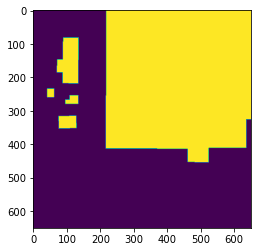

In [78]:
mask = rio.open(path_mask_img+"AOI_4_Shanghai_img1010.tif")
data = mask.read()
data = data.transpose(1,2,0)
print(data.shape)
mask = np.array(data)
plt.imshow(mask)

In [ ]:
# 益田の画像はdata数が足りないので, 重ねてタイルを作成
# + augmentationで10倍とかに増やす